In [44]:
from combined_statistics import combined_mean, combined_standard_deviation
from conference_plots import set_size
import datetime, gzip, pickle, pickletools
from pprint import pprint
import os
from os import listdir
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import rc
interactive(True)

In [2]:
def fairness_fn(harvester_rewards, fairness_metric):
    if (fairness_metric == 'jain'):
        fairness = jain_index_fn(harvester_rewards)
        assert 0 <= fairness <= 1
        return fairness
    elif (fairness_metric == 'gini'):
        fairness =  1 - gini_coefficient_fn(harvester_rewards) # We maximize fairness. According to the Gini coefficient, an allocation is fair iff the coefficient is 0.
        if fairness < 0:     # The Gini coefficient is not bounded
            fairness = 0
        assert 0 <= fairness <= 1
        return fairness
    elif (fairness_metric == 'atkinson'):
        fairness = 1 - atkinson_index_fn(harvester_rewards) # We maximize fairness. According to the Atkinson index, an allocation is fair iff the index is 0.
        assert 0 <= fairness <= 1
        return fairness
    else:
        raise ValueError('Invalid fairness metric: ' + fairness_metric)


def jain_index_fn(rewards):
    if np.count_nonzero(rewards) == 0:
        return 1 # Fair allocation; everybody got reward 0
    rewards = rewards.astype(np.float64)

    return np.sum(rewards) ** 2 / ( np.sum(rewards ** 2) * rewards.shape[0] )


def gini_coefficient_fn(rewards):
    if np.count_nonzero(rewards) == 0:
        return 0 # Fair allocation; everybody got reward 0
    rewards = rewards.astype(np.float64)

    G = np.sum(np.abs(rewards - np.array([np.roll(rewards,i) for i in range(rewards.shape[0])])))
    G /= sum(rewards) * 2 * rewards.shape[0]
    return G


# This is the Atkinson index for epsilon = 1
def atkinson_index_fn(rewards):
    # if np.count_nonzero(rewards) == 0:
    if np.allclose(rewards, np.zeros(rewards.shape[0]), rtol=0, atol=1e-6):
        return 0 # Fair allocation; everybody got reward 0
    rewards = rewards.astype(np.float64)
    product = np.prod(rewards)

    if not np.any(rewards == 0):
        assert product > 0 # Ensure there are no precision errors

    return 1 - ( pow(product, 1.0 / rewards.shape[0]) / np.mean(rewards) )

In [3]:
def parse_results(logs):
    harvester_fairness = []
    stock_difference = []
    stock_difference_min = []
    harvester_rewards = []
    harvester_rewards_mean = []
    harvester_revenue = []
    harvester_revenue_mean = []
    wasted_percentage = []
    wasted_percentage_mean = []
    buyers_utility = []
    buyers_utility_mean = []
    prices = []
    
    harvester_fairness_sd = []
    stock_difference_sd = []
    harvester_rewards_sd = []
    harvester_rewards_mean_sd = []
    harvester_revenue_sd = []
    harvester_revenue_mean_sd = []
    wasted_percentage_sd = []
    wasted_percentage_mean_sd = []
    buyers_utility_sd = []
    buyers_utility_mean_sd = []
    prices_sd = []

    num_episodes = len(logs['episodes'])

    for i in range(num_episodes):
        episode = logs['episodes'][i]

        # harvester_fairness
        x = episode['harvester_fairness'][1:] # Remove the first element because it is an 1 by default
        x_mean = np.mean(x)
        x_sd = np.std(x)
        harvester_fairness.append(x_mean)
        harvester_fairness_sd.append(x_sd)
        # stock_difference
        x = 100 * np.array(episode['stock_difference']) / logs['S_eq']
        x = np.delete(x, (0), axis=0)
        tmp = np.mean(x, axis=0)
        x_mean = np.mean(tmp)
        x_sd = np.std(tmp)
        x_min = np.min(np.min(x, axis=0))
        stock_difference.append(x_mean)
        stock_difference_sd.append(x_sd)
        stock_difference_min.append(x_min)
        # harvester_rewards
        x = np.array(episode['harvester_rewards'])
        x = np.delete(x, (0), axis=0)
        x_mean = np.mean(x, axis=0)
        x_sd = np.std(x, axis=0)
        x_mean_mean = np.mean(np.mean(x, axis=0))
        x_mean_sd = np.std(np.mean(x, axis=0))
        harvester_rewards.append(x_mean)
        harvester_rewards_mean.append(x_mean_mean)
        harvester_rewards_sd.append(x_sd)
        harvester_rewards_mean_sd.append(x_mean_sd)
        # harvester_revenue
        x = np.array(episode['harvester_revenue'])
        x = np.delete(x, (0), axis=0)
        x_mean = np.mean(x, axis=0)
        x_sd = np.std(x, axis=0)
        x_mean_mean = np.mean(np.mean(x, axis=0))
        x_mean_std = np.std(np.mean(x, axis=0))
        harvester_revenue.append(x_mean)
        harvester_revenue_mean.append(x_mean_mean)
        harvester_revenue_sd.append(x_sd)
        harvester_revenue_mean_sd.append(x_mean_sd)
        # wasted_percentage
        x = 100 * np.array(episode['wasted_percentage'])
        x = np.delete(x, (0), axis=0)
        x[x <0] = 0
        x_mean = np.mean(x, axis=2)
        x_mean_mean = np.mean(x_mean, axis=0)
        x_mean_sd = np.std(x_mean, axis=0)
        wasted_percentage.append(x_mean_mean)
        wasted_percentage_sd.append(x_mean_sd)
        x_mean_mean_mean = np.mean(x_mean_mean)
        x_mean_mean_sd = np.std(x_mean_mean)
        wasted_percentage_mean.append(x_mean_mean_mean)
        wasted_percentage_mean_sd.append(x_mean_mean_sd)
        # buyers_utility
        x = np.array(episode['buyers_utility'])
        x = np.delete(x, (0), axis=0)
        x_mean = np.mean(x, axis=0)
        x_sd = np.std(x, axis=0)
        x_mean_mean = np.mean(np.mean(x, axis=0))
        x_mean_sd = np.std(np.mean(x, axis=0))
        buyers_utility.append(x_mean)
        buyers_utility_mean.append(x_mean_mean)
        buyers_utility_sd.append(x_sd)
        buyers_utility_mean_sd.append(x_mean_sd)
        # prices
        x = np.array(episode['prices'])
        x = np.delete(x, (0), axis=0)
        x_mean = np.mean(x, axis=0)
        x_sd = np.std(x, axis=0)
        prices.append(x_mean)
        prices_sd.append(x_sd)



    harvester_fairness = np.array(harvester_fairness)
    stock_difference = np.array(stock_difference)
    stock_difference_min = np.array(stock_difference_min)
    harvester_rewards = np.array(harvester_rewards)
    harvester_rewards_mean = np.array(harvester_rewards_mean)
    harvester_revenue = np.array(harvester_revenue)
    harvester_revenue_mean = np.array(harvester_revenue_mean)
    wasted_percentage = np.array(wasted_percentage)
    wasted_percentage_mean = np.array(wasted_percentage_mean)
    buyers_utility = np.array(buyers_utility)
    buyers_utility_mean = np.array(buyers_utility_mean)
    prices = np.array(prices)
    
    harvester_fairness_sd = np.array(harvester_fairness_sd)
    stock_difference_sd = np.array(stock_difference_sd)
    harvester_rewards_sd = np.array(harvester_rewards_sd)
    harvester_rewards_mean_sd = np.array(harvester_rewards_mean_sd)
    harvester_revenue_sd = np.array(harvester_revenue_sd)
    harvester_revenue_mean_sd = np.array(harvester_revenue_mean_sd)
    wasted_percentage_sd = np.array(wasted_percentage_sd)
    wasted_percentage_mean_sd = np.array(wasted_percentage_mean_sd)
    buyers_utility_sd = np.array(buyers_utility_sd)
    buyers_utility_mean_sd = np.array(buyers_utility_mean_sd)
    prices_sd = np.array(prices_sd)
    
    return  harvester_fairness,\
            stock_difference,\
            stock_difference_min,\
            harvester_rewards,\
            harvester_rewards_mean,\
            harvester_revenue,\
            harvester_revenue_mean,\
            wasted_percentage,\
            wasted_percentage_mean,\
            buyers_utility,\
            buyers_utility_mean,\
            prices,\
            harvester_fairness_sd,\
            stock_difference_sd,\
            harvester_rewards_sd,\
            harvester_rewards_mean_sd,\
            harvester_revenue_sd,\
            harvester_revenue_mean_sd,\
            wasted_percentage_sd,\
            wasted_percentage_mean_sd,\
            buyers_utility_sd,\
            buyers_utility_mean_sd,\
            prices_sd,\
            num_episodes

In [4]:
def combine_logs(logs):
    n_harvesters = 8
    n_resources = 4
    n_buyers = 8
    
    
    harvester_fairness_0,\
    stock_difference_0,\
    stock_difference_min_0,\
    harvester_rewards_0,\
    harvester_rewards_mean_0,\
    harvester_revenue_0,\
    harvester_revenue_mean_0,\
    wasted_percentage_0,\
    wasted_percentage_mean_0,\
    buyers_utility_0,\
    buyers_utility_mean_0,\
    prices_0,\
    harvester_fairness_sd_0,\
    stock_difference_sd_0,\
    harvester_rewards_sd_0,\
    harvester_rewards_mean_sd_0,\
    harvester_revenue_sd_0,\
    harvester_revenue_mean_sd_0,\
    wasted_percentage_sd_0,\
    wasted_percentage_mean_sd_0,\
    buyers_utility_sd_0,\
    buyers_utility_mean_sd_0,\
    prices_sd_0,\
    num_episodes_0 = parse_results(logs[0])

    harvester_fairness_1,\
    stock_difference_1,\
    stock_difference_min_1,\
    harvester_rewards_1,\
    harvester_rewards_mean_1,\
    harvester_revenue_1,\
    harvester_revenue_mean_1,\
    wasted_percentage_1,\
    wasted_percentage_mean_1,\
    buyers_utility_1,\
    buyers_utility_mean_1,\
    prices_1,\
    harvester_fairness_sd_1,\
    stock_difference_sd_1,\
    harvester_rewards_sd_1,\
    harvester_rewards_mean_sd_1,\
    harvester_revenue_sd_1,\
    harvester_revenue_mean_sd_1,\
    wasted_percentage_sd_1,\
    wasted_percentage_mean_sd_1,\
    buyers_utility_sd_1,\
    buyers_utility_mean_sd_1,\
    prices_sd_1,\
    num_episodes_1 = parse_results(logs[1])

    harvester_fairness_2,\
    stock_difference_2,\
    stock_difference_min_2,\
    harvester_rewards_2,\
    harvester_rewards_mean_2,\
    harvester_revenue_2,\
    harvester_revenue_mean_2,\
    wasted_percentage_2,\
    wasted_percentage_mean_2,\
    buyers_utility_2,\
    buyers_utility_mean_2,\
    prices_2,\
    harvester_fairness_sd_2,\
    stock_difference_sd_2,\
    harvester_rewards_sd_2,\
    harvester_rewards_mean_sd_2,\
    harvester_revenue_sd_2,\
    harvester_revenue_mean_sd_2,\
    wasted_percentage_sd_2,\
    wasted_percentage_mean_sd_2,\
    buyers_utility_sd_2,\
    buyers_utility_mean_sd_2,\
    prices_sd_2,\
    num_episodes_2 = parse_results(logs[2])

    harvester_fairness_3,\
    stock_difference_3,\
    stock_difference_min_3,\
    harvester_rewards_3,\
    harvester_rewards_mean_3,\
    harvester_revenue_3,\
    harvester_revenue_mean_3,\
    wasted_percentage_3,\
    wasted_percentage_mean_3,\
    buyers_utility_3,\
    buyers_utility_mean_3,\
    prices_3,\
    harvester_fairness_sd_3,\
    stock_difference_sd_3,\
    harvester_rewards_sd_3,\
    harvester_rewards_mean_sd_3,\
    harvester_revenue_sd_3,\
    harvester_revenue_mean_sd_3,\
    wasted_percentage_sd_3,\
    wasted_percentage_mean_sd_3,\
    buyers_utility_sd_3,\
    buyers_utility_mean_sd_3,\
    prices_sd_3,\
    num_episodes_3 = parse_results(logs[3])

    harvester_fairness_4,\
    stock_difference_4,\
    stock_difference_min_4,\
    harvester_rewards_4,\
    harvester_rewards_mean_4,\
    harvester_revenue_4,\
    harvester_revenue_mean_4,\
    wasted_percentage_4,\
    wasted_percentage_mean_4,\
    buyers_utility_4,\
    buyers_utility_mean_4,\
    prices_4,\
    harvester_fairness_sd_4,\
    stock_difference_sd_4,\
    harvester_rewards_sd_4,\
    harvester_rewards_mean_sd_4,\
    harvester_revenue_sd_4,\
    harvester_revenue_mean_sd_4,\
    wasted_percentage_sd_4,\
    wasted_percentage_mean_sd_4,\
    buyers_utility_sd_4,\
    buyers_utility_mean_sd_4,\
    prices_sd_4,\
    num_episodes_4 = parse_results(logs[4])

    harvester_fairness_5,\
    stock_difference_5,\
    stock_difference_min_5,\
    harvester_rewards_5,\
    harvester_rewards_mean_5,\
    harvester_revenue_5,\
    harvester_revenue_mean_5,\
    wasted_percentage_5,\
    wasted_percentage_mean_5,\
    buyers_utility_5,\
    buyers_utility_mean_5,\
    prices_5,\
    harvester_fairness_sd_5,\
    stock_difference_sd_5,\
    harvester_rewards_sd_5,\
    harvester_rewards_mean_sd_5,\
    harvester_revenue_sd_5,\
    harvester_revenue_mean_sd_5,\
    wasted_percentage_sd_5,\
    wasted_percentage_mean_sd_5,\
    buyers_utility_sd_5,\
    buyers_utility_mean_sd_5,\
    prices_sd_5,\
    num_episodes_5 = parse_results(logs[5])

    harvester_fairness_6,\
    stock_difference_6,\
    stock_difference_min_6,\
    harvester_rewards_6,\
    harvester_rewards_mean_6,\
    harvester_revenue_6,\
    harvester_revenue_mean_6,\
    wasted_percentage_6,\
    wasted_percentage_mean_6,\
    buyers_utility_6,\
    buyers_utility_mean_6,\
    prices_6,\
    harvester_fairness_sd_6,\
    stock_difference_sd_6,\
    harvester_rewards_sd_6,\
    harvester_rewards_mean_sd_6,\
    harvester_revenue_sd_6,\
    harvester_revenue_mean_sd_6,\
    wasted_percentage_sd_6,\
    wasted_percentage_mean_sd_6,\
    buyers_utility_sd_6,\
    buyers_utility_mean_sd_6,\
    prices_sd_6,\
    num_episodes_6 = parse_results(logs[6])

    harvester_fairness_7,\
    stock_difference_7,\
    stock_difference_min_7,\
    harvester_rewards_7,\
    harvester_rewards_mean_7,\
    harvester_revenue_7,\
    harvester_revenue_mean_7,\
    wasted_percentage_7,\
    wasted_percentage_mean_7,\
    buyers_utility_7,\
    buyers_utility_mean_7,\
    prices_7,\
    harvester_fairness_sd_7,\
    stock_difference_sd_7,\
    harvester_rewards_sd_7,\
    harvester_rewards_mean_sd_7,\
    harvester_revenue_sd_7,\
    harvester_revenue_mean_sd_7,\
    wasted_percentage_sd_7,\
    wasted_percentage_mean_sd_7,\
    buyers_utility_sd_7,\
    buyers_utility_mean_sd_7,\
    prices_sd_7,\
    num_episodes_7 = parse_results(logs[7])
    

    num_episodes_list = [num_episodes_0, num_episodes_1, num_episodes_2, num_episodes_3, num_episodes_4, num_episodes_5, num_episodes_6, num_episodes_7]
    num_episodes = min(num_episodes_list)
    print('num_episodes = ' + str(num_episodes))

    harvester_fairness = []
    harvester_fairness_sd = []
    stock_difference = []
    stock_difference_sd = []
    stock_difference_min = []
    harvester_rewards = []
    harvester_rewards_sd = []
    harvester_rewards_mean = []
    harvester_rewards_mean_sd = []
    harvester_revenue = []
    harvester_revenue_sd = []
    harvester_revenue_mean = []
    harvester_revenue_mean_sd = []
    wasted_percentage = []
    wasted_percentage_sd = []
    wasted_percentage_mean = []
    wasted_percentage_mean_sd = []
    buyers_utility = []
    buyers_utility_sd = []
    buyers_utility_mean = []
    buyers_utility_mean_sd = []
    prices = []
    prices_sd = []

    for i in range(num_episodes):
        # Harvester Fairness
        harvester_fairness.append(combined_mean([harvester_fairness_0[i],
                                                harvester_fairness_1[i],
                                                harvester_fairness_2[i],
                                                harvester_fairness_3[i],
                                                harvester_fairness_4[i],
                                                harvester_fairness_5[i],
                                                harvester_fairness_6[i],
                                                harvester_fairness_7[i]], 8 * [500]))
        harvester_fairness_sd.append(combined_standard_deviation([harvester_fairness_0[i],
                                                                harvester_fairness_1[i],
                                                                harvester_fairness_2[i],
                                                                harvester_fairness_3[i],
                                                                harvester_fairness_4[i],
                                                                harvester_fairness_5[i],
                                                                harvester_fairness_6[i],
                                                                harvester_fairness_7[i]],
                                                                 [harvester_fairness_sd_0[i],
                                                                 harvester_fairness_sd_1[i],
                                                                 harvester_fairness_sd_2[i],
                                                                 harvester_fairness_sd_3[i],
                                                                 harvester_fairness_sd_4[i],
                                                                 harvester_fairness_sd_5[i],
                                                                 harvester_fairness_sd_6[i],
                                                                 harvester_fairness_sd_7[i]],
                                                                 8 * [500]))

        # Stock Difference
        stock_difference.append(combined_mean([stock_difference_0[i],
                                                stock_difference_1[i],
                                                stock_difference_2[i],
                                                stock_difference_3[i],
                                                stock_difference_4[i],
                                                stock_difference_5[i],
                                                stock_difference_6[i],
                                                stock_difference_7[i]], 8 * [500]))
        stock_difference_sd.append(combined_standard_deviation([stock_difference_0[i],
                                                                stock_difference_1[i],
                                                                stock_difference_2[i],
                                                                stock_difference_3[i],
                                                                stock_difference_4[i],
                                                                stock_difference_5[i],
                                                                stock_difference_6[i],
                                                                stock_difference_7[i]],
                                                                 [stock_difference_sd_0[i],
                                                                 stock_difference_sd_1[i],
                                                                 stock_difference_sd_2[i],
                                                                 stock_difference_sd_3[i],
                                                                 stock_difference_sd_4[i],
                                                                 stock_difference_sd_5[i],
                                                                 stock_difference_sd_6[i],
                                                                 stock_difference_sd_7[i]],
                                                                 8 * [500]))
        stock_difference_min.append(min(stock_difference_min_0[i],
                                        stock_difference_min_1[i],
                                        stock_difference_min_2[i],
                                        stock_difference_min_3[i],
                                        stock_difference_min_4[i],
                                        stock_difference_min_5[i],
                                        stock_difference_min_6[i],
                                        stock_difference_min_7[i]))

        # Harvester Rewards
        harvester_rewards_mean.append(combined_mean([harvester_rewards_mean_0[i],
                                                harvester_rewards_mean_1[i],
                                                harvester_rewards_mean_2[i],
                                                harvester_rewards_mean_3[i],
                                                harvester_rewards_mean_4[i],
                                                harvester_rewards_mean_5[i],
                                                harvester_rewards_mean_6[i],
                                                harvester_rewards_mean_7[i]], 8 * [500]))
        harvester_rewards_mean_sd.append(combined_standard_deviation([harvester_rewards_mean_0[i],
                                                                harvester_rewards_mean_1[i],
                                                                harvester_rewards_mean_2[i],
                                                                harvester_rewards_mean_3[i],
                                                                harvester_rewards_mean_4[i],
                                                                harvester_rewards_mean_5[i],
                                                                harvester_rewards_mean_6[i],
                                                                harvester_rewards_mean_7[i]],
                                                                 [harvester_rewards_mean_sd_0[i],
                                                                 harvester_rewards_mean_sd_1[i],
                                                                 harvester_rewards_mean_sd_2[i],
                                                                 harvester_rewards_mean_sd_3[i],
                                                                 harvester_rewards_mean_sd_4[i],
                                                                 harvester_rewards_mean_sd_5[i],
                                                                 harvester_rewards_mean_sd_6[i],
                                                                 harvester_rewards_mean_sd_7[i]],
                                                                 8 * [500]))
        mean = []
        sd = []
        for h in range(n_harvesters):
            mean.append(combined_mean([harvester_rewards_0[i][h],
                                    harvester_rewards_1[i][h],
                                    harvester_rewards_2[i][h],
                                    harvester_rewards_3[i][h],
                                    harvester_rewards_4[i][h],
                                    harvester_rewards_5[i][h],
                                    harvester_rewards_6[i][h],
                                    harvester_rewards_7[i][h]], 8 * [500]))
            sd.append(combined_standard_deviation([harvester_rewards_0[i][h],
                                                harvester_rewards_1[i][h],
                                                harvester_rewards_2[i][h],
                                                harvester_rewards_3[i][h],
                                                harvester_rewards_4[i][h],
                                                harvester_rewards_5[i][h],
                                                harvester_rewards_6[i][h],
                                                harvester_rewards_7[i][h]],
                                                 [harvester_rewards_sd_0[i][h],
                                                 harvester_rewards_sd_1[i][h],
                                                 harvester_rewards_sd_2[i][h],
                                                 harvester_rewards_sd_3[i][h],
                                                 harvester_rewards_sd_4[i][h],
                                                 harvester_rewards_sd_5[i][h],
                                                 harvester_rewards_sd_6[i][h],
                                                 harvester_rewards_sd_7[i][h]],
                                                 8 * [500]))
        harvester_rewards.append(mean)
        harvester_rewards_sd.append(sd)

        # Harvester Revenue
        harvester_revenue_mean.append(combined_mean([harvester_revenue_mean_0[i],
                                                harvester_revenue_mean_1[i],
                                                harvester_revenue_mean_2[i],
                                                harvester_revenue_mean_3[i],
                                                harvester_revenue_mean_4[i],
                                                harvester_revenue_mean_5[i],
                                                harvester_revenue_mean_6[i],
                                                harvester_revenue_mean_7[i]], 8 * [500]))
        harvester_revenue_mean_sd.append(combined_standard_deviation([harvester_revenue_mean_0[i],
                                                                harvester_revenue_mean_1[i],
                                                                harvester_revenue_mean_2[i],
                                                                harvester_revenue_mean_3[i],
                                                                harvester_revenue_mean_4[i],
                                                                harvester_revenue_mean_5[i],
                                                                harvester_revenue_mean_6[i],
                                                                harvester_revenue_mean_7[i]],
                                                                 [harvester_revenue_mean_sd_0[i],
                                                                 harvester_revenue_mean_sd_1[i],
                                                                 harvester_revenue_mean_sd_2[i],
                                                                 harvester_revenue_mean_sd_3[i],
                                                                 harvester_revenue_mean_sd_4[i],
                                                                 harvester_revenue_mean_sd_5[i],
                                                                 harvester_revenue_mean_sd_6[i],
                                                                 harvester_revenue_mean_sd_7[i]],
                                                                 8 * [500]))
        mean = []
        sd = []
        for h in range(n_harvesters):
            mean.append(combined_mean([harvester_revenue_0[i][h],
                                    harvester_revenue_1[i][h],
                                    harvester_revenue_2[i][h],
                                    harvester_revenue_3[i][h],
                                    harvester_revenue_4[i][h],
                                    harvester_revenue_5[i][h],
                                    harvester_revenue_6[i][h],
                                    harvester_revenue_7[i][h]], 8 * [500]))
            sd.append(combined_standard_deviation([harvester_revenue_0[i][h],
                                                harvester_revenue_1[i][h],
                                                harvester_revenue_2[i][h],
                                                harvester_revenue_3[i][h],
                                                harvester_revenue_4[i][h],
                                                harvester_revenue_5[i][h],
                                                harvester_revenue_6[i][h],
                                                harvester_revenue_7[i][h]],
                                                 [harvester_revenue_sd_0[i][h],
                                                 harvester_revenue_sd_1[i][h],
                                                 harvester_revenue_sd_2[i][h],
                                                 harvester_revenue_sd_3[i][h],
                                                 harvester_revenue_sd_4[i][h],
                                                 harvester_revenue_sd_5[i][h],
                                                 harvester_revenue_sd_6[i][h],
                                                 harvester_revenue_sd_7[i][h]],
                                                 8 * [500]))
        harvester_revenue.append(mean)
        harvester_revenue_sd.append(sd)
        
        # Wasted Percentage
        wasted_percentage_mean.append(combined_mean([wasted_percentage_mean_0[i],
                                                wasted_percentage_mean_1[i],
                                                wasted_percentage_mean_2[i],
                                                wasted_percentage_mean_3[i],
                                                wasted_percentage_mean_4[i],
                                                wasted_percentage_mean_5[i],
                                                wasted_percentage_mean_6[i],
                                                wasted_percentage_mean_7[i]], 8 * [500]))
        wasted_percentage_mean_sd.append(combined_standard_deviation([wasted_percentage_mean_0[i],
                                                                wasted_percentage_mean_1[i],
                                                                wasted_percentage_mean_2[i],
                                                                wasted_percentage_mean_3[i],
                                                                wasted_percentage_mean_4[i],
                                                                wasted_percentage_mean_5[i],
                                                                wasted_percentage_mean_6[i],
                                                                wasted_percentage_mean_7[i]],
                                                                 [wasted_percentage_mean_sd_0[i],
                                                                 wasted_percentage_mean_sd_1[i],
                                                                 wasted_percentage_mean_sd_2[i],
                                                                 wasted_percentage_mean_sd_3[i],
                                                                 wasted_percentage_mean_sd_4[i],
                                                                 wasted_percentage_mean_sd_5[i],
                                                                 wasted_percentage_mean_sd_6[i],
                                                                 wasted_percentage_mean_sd_7[i]],
                                                                 8 * [500]))
        
        mean = []
        sd = []
        for h in range(n_harvesters):
            mean.append(combined_mean([wasted_percentage_0[i][h],
                                    wasted_percentage_1[i][h],
                                    wasted_percentage_2[i][h],
                                    wasted_percentage_3[i][h],
                                    wasted_percentage_4[i][h],
                                    wasted_percentage_5[i][h],
                                    wasted_percentage_6[i][h],
                                    wasted_percentage_7[i][h]], 8 * [500]))
            sd.append(combined_standard_deviation([wasted_percentage_0[i][h],
                                                wasted_percentage_1[i][h],
                                                wasted_percentage_2[i][h],
                                                wasted_percentage_3[i][h],
                                                wasted_percentage_4[i][h],
                                                wasted_percentage_5[i][h],
                                                wasted_percentage_6[i][h],
                                                wasted_percentage_7[i][h]],
                                                 [wasted_percentage_sd_0[i][h],
                                                 wasted_percentage_sd_1[i][h],
                                                 wasted_percentage_sd_2[i][h],
                                                 wasted_percentage_sd_3[i][h],
                                                 wasted_percentage_sd_4[i][h],
                                                 wasted_percentage_sd_5[i][h],
                                                 wasted_percentage_sd_6[i][h],
                                                 wasted_percentage_sd_7[i][h]],
                                                 8 * [500]))
        wasted_percentage.append(mean)
        wasted_percentage_sd.append(sd)
        

        # Buyers Utility
        buyers_utility_mean.append(combined_mean([buyers_utility_mean_0[i],
                                                buyers_utility_mean_1[i],
                                                buyers_utility_mean_2[i],
                                                buyers_utility_mean_3[i],
                                                buyers_utility_mean_4[i],
                                                buyers_utility_mean_5[i],
                                                buyers_utility_mean_6[i],
                                                buyers_utility_mean_7[i]], 8 * [500]))
        buyers_utility_mean_sd.append(combined_standard_deviation([buyers_utility_mean_0[i],
                                                                buyers_utility_mean_1[i],
                                                                buyers_utility_mean_2[i],
                                                                buyers_utility_mean_3[i],
                                                                buyers_utility_mean_4[i],
                                                                buyers_utility_mean_5[i],
                                                                buyers_utility_mean_6[i],
                                                                buyers_utility_mean_7[i]],
                                                                 [buyers_utility_mean_sd_0[i],
                                                                 buyers_utility_mean_sd_1[i],
                                                                 buyers_utility_mean_sd_2[i],
                                                                 buyers_utility_mean_sd_3[i],
                                                                 buyers_utility_mean_sd_4[i],
                                                                 buyers_utility_mean_sd_5[i],
                                                                 buyers_utility_mean_sd_6[i],
                                                                 buyers_utility_mean_sd_7[i]],
                                                                 8 * [500]))
        mean = []
        sd = []
        for h in range(n_buyers):
            mean.append(combined_mean([buyers_utility_0[i][h],
                                    buyers_utility_1[i][h],
                                    buyers_utility_2[i][h],
                                    buyers_utility_3[i][h],
                                    buyers_utility_4[i][h],
                                    buyers_utility_5[i][h],
                                    buyers_utility_6[i][h],
                                    buyers_utility_7[i][h]], 8 * [500]))
            sd.append(combined_standard_deviation([buyers_utility_0[i][h],
                                                buyers_utility_1[i][h],
                                                buyers_utility_2[i][h],
                                                buyers_utility_3[i][h],
                                                buyers_utility_4[i][h],
                                                buyers_utility_5[i][h],
                                                buyers_utility_6[i][h],
                                                buyers_utility_7[i][h]],
                                                 [buyers_utility_sd_0[i][h],
                                                 buyers_utility_sd_1[i][h],
                                                 buyers_utility_sd_2[i][h],
                                                 buyers_utility_sd_3[i][h],
                                                 buyers_utility_sd_4[i][h],
                                                 buyers_utility_sd_5[i][h],
                                                 buyers_utility_sd_6[i][h],
                                                 buyers_utility_sd_7[i][h]],
                                                 8 * [500]))
        buyers_utility.append(mean)
        buyers_utility_sd.append(sd)

        # Prices
        mean = []
        sd = []
        for h in range(n_resources):
            mean.append(combined_mean([prices_0[i][h],
                                    prices_1[i][h],
                                    prices_2[i][h],
                                    prices_3[i][h],
                                    prices_4[i][h],
                                    prices_5[i][h],
                                    prices_6[i][h],
                                    prices_7[i][h]], 8 * [500]))
            sd.append(combined_standard_deviation([prices_0[i][h],
                                                prices_1[i][h],
                                                prices_2[i][h],
                                                prices_3[i][h],
                                                prices_4[i][h],
                                                prices_5[i][h],
                                                prices_6[i][h],
                                                prices_7[i][h]],
                                                 [prices_sd_0[i][h],
                                                 prices_sd_1[i][h],
                                                 prices_sd_2[i][h],
                                                 prices_sd_3[i][h],
                                                 prices_sd_4[i][h],
                                                 prices_sd_5[i][h],
                                                 prices_sd_6[i][h],
                                                 prices_sd_7[i][h]],
                                                 8 * [500]))
        prices.append(mean)
        prices_sd.append(sd)



    harvester_fairness = np.array(harvester_fairness)
    harvester_fairness_sd = np.array(harvester_fairness_sd)
    stock_difference = np.array(stock_difference)
    stock_difference_sd = np.array(stock_difference_sd)
    stock_difference_min = np.array(stock_difference_min)
    harvester_rewards = np.array(harvester_rewards)
    harvester_rewards_sd = np.array(harvester_rewards_sd)
    harvester_rewards_mean = np.array(harvester_rewards_mean)
    harvester_rewards_mean_sd = np.array(harvester_rewards_mean_sd)
    harvester_revenue = np.array(harvester_revenue)
    harvester_revenue_sd = np.array(harvester_revenue_sd)
    harvester_revenue_mean = np.array(harvester_revenue_mean)
    harvester_revenue_mean_sd = np.array(harvester_revenue_mean_sd)
    wasted_percentage = np.array(wasted_percentage)
    wasted_percentage_sd = np.array(wasted_percentage_sd)
    wasted_percentage_mean = np.array(wasted_percentage_mean)
    wasted_percentage_mean_sd = np.array(wasted_percentage_mean_sd)
    buyers_utility = np.array(buyers_utility)
    buyers_utility_sd = np.array(buyers_utility_sd)
    buyers_utility_mean = np.array(buyers_utility_mean)
    buyers_utility_mean_sd = np.array(buyers_utility_mean_sd)
    prices = np.array(prices)
    prices_sd = np.array(prices_sd)
    
    
    return  harvester_fairness,\
            stock_difference,\
            stock_difference_min,\
            harvester_rewards,\
            harvester_rewards_mean,\
            harvester_revenue,\
            harvester_revenue_mean,\
            wasted_percentage,\
            wasted_percentage_mean,\
            buyers_utility,\
            buyers_utility_mean,\
            prices,\
            harvester_fairness_sd,\
            stock_difference_sd,\
            harvester_rewards_sd,\
            harvester_rewards_mean_sd,\
            harvester_revenue_sd,\
            harvester_revenue_mean_sd,\
            wasted_percentage_sd,\
            wasted_percentage_mean_sd,\
            buyers_utility_sd,\
            buyers_utility_mean_sd,\
            prices_sd,\
            num_episodes,\
            num_episodes_list

In [5]:
def get_numerical_results(logs):
    n_harvesters = 8
    n_resources = 4
    n_buyers = 8
    
    

    fairness_jain = []
    fairness_gini = []
    fairness_atkinson = []
    social_welfare = []
    fairness_revenue_jain = []
    fairness_revenue_gini = []
    fairness_revenue_atkinson = []
    social_welfare_revenue = []
    stock_difference = []
    wasted_percentage = []
    fairness_buyers_jain = []
    fairness_buyers_gini = []
    fairness_buyers_atkinson = []
    social_welfare_buyers = []
    
    n_episodes = 17 # This corresponds to 24 (workers) * 17 = 408 episodes
    
    for log in logs:
        harvester_fairness_0,\
        stock_difference_0,\
        stock_difference_min_0,\
        harvester_rewards_0,\
        harvester_rewards_mean_0,\
        harvester_revenue_0,\
        harvester_revenue_mean_0,\
        wasted_percentage_0,\
        wasted_percentage_mean_0,\
        buyers_utility_0,\
        buyers_utility_mean_0,\
        prices_0,\
        harvester_fairness_sd_0,\
        stock_difference_sd_0,\
        harvester_rewards_sd_0,\
        harvester_rewards_mean_sd_0,\
        harvester_revenue_sd_0,\
        harvester_revenue_mean_sd_0,\
        wasted_percentage_sd_0,\
        wasted_percentage_mean_sd_0,\
        buyers_utility_sd_0,\
        buyers_utility_mean_sd_0,\
        prices_sd_0,\
        num_episodes_0 = parse_results(log)
    
        cumulative_rewards = np.sum(harvester_rewards_0[-n_episodes:][:], axis=0)
        fairness_jain.append(fairness_fn(cumulative_rewards, 'jain'))
        fairness_gini.append(fairness_fn(cumulative_rewards, 'gini'))
        fairness_atkinson.append(fairness_fn(cumulative_rewards, 'atkinson'))
        social_welfare.append(np.sum(cumulative_rewards))
    
        cumulative_rewards = np.sum(harvester_revenue_0[-n_episodes:][:], axis=0)
        fairness_revenue_jain.append(fairness_fn(cumulative_rewards, 'jain'))
        fairness_revenue_gini.append(fairness_fn(cumulative_rewards, 'gini'))
        fairness_revenue_atkinson.append(fairness_fn(cumulative_rewards, 'atkinson'))
        social_welfare_revenue.append(np.sum(cumulative_rewards))
    
    
        stock_difference.append(np.mean(stock_difference_0[-n_episodes:]))
        wasted_percentage.append(np.mean(np.mean(wasted_percentage_0[-n_episodes:][:], axis=0)))
        
        cumulative_rewards = np.sum(buyers_utility_0[-n_episodes:][:], axis=0)
        fairness_buyers_jain.append(fairness_fn(cumulative_rewards, 'jain'))
        fairness_buyers_gini.append(fairness_fn(cumulative_rewards, 'gini'))
        fairness_buyers_atkinson.append(fairness_fn(cumulative_rewards, 'atkinson'))
        social_welfare_buyers.append(np.sum(cumulative_rewards))
        

    return fairness_jain,\
    fairness_gini,\
    fairness_atkinson,\
    social_welfare,\
    fairness_revenue_jain,\
    fairness_revenue_gini,\
    fairness_revenue_atkinson,\
    social_welfare_revenue,\
    stock_difference,\
    wasted_percentage,\
    fairness_buyers_jain,\
    fairness_buyers_gini,\
    fairness_buyers_atkinson,\
    social_welfare_buyers

In [6]:
logs_path = './logs'

In [7]:
logs_directories = [
'logs_true', 
'logs_true_Ms_0p45', 
'logs', 
'logs_Ms_0p45', 
'logs_Ms_0p45_sustainability', 
'logs_harvesters', 
'logs_buyers', 
'logs_fairness', 
'logs_sustainability', 
'logs_true_gini', 
'logs_true_atkinson', 
'logs_gini', 
'logs_atkinson', 
'logs_gini_fairness', 
'logs_atkinson_fairness',
'logs_true_uniform', 
'logs_uniform_0p01', 
'logs_uniform_0p025', 
'logs_uniform_0p05', 
'logs_uniform_0p075', 
'logs_uniform_0p1', 
'logs_bins_100', 
'logs_bins_75', 
'logs_bins_50', 
'logs_bins_25', 
'logs_bins_10', 
]

In [8]:
print(logs_directories)

['logs_true', 'logs_true_Ms_0p45', 'logs', 'logs_Ms_0p45', 'logs_Ms_0p45_sustainability', 'logs_harvesters', 'logs_buyers', 'logs_fairness', 'logs_sustainability', 'logs_true_gini', 'logs_true_atkinson', 'logs_gini', 'logs_atkinson', 'logs_gini_fairness', 'logs_atkinson_fairness', 'logs_true_uniform', 'logs_uniform_0p01', 'logs_uniform_0p025', 'logs_uniform_0p05', 'logs_uniform_0p075', 'logs_uniform_0p1', 'logs_bins_100', 'logs_bins_75', 'logs_bins_50', 'logs_bins_25', 'logs_bins_10']


In [9]:
results = {}

for directory_name in logs_directories:
    print('Parsing ' + directory_name)
    directory = os.path.join(logs_path, directory_name)
#     l_list = [name for name in listdir(directory) if 'workerID_10' in name]
    l_list = [name for name in listdir(directory) if 'workerID' in name]
    print(l_list)
    print(len(l_list))
    
    logs = []
    for l in l_list:
        with gzip.open(os.path.join(directory, l), 'rb') as f:
            p = pickle.Unpickler(f)
            log = p.load()
            logs.append(log)
            
    harvester_fairness,\
    stock_difference,\
    stock_difference_min,\
    harvester_rewards,\
    harvester_rewards_mean,\
    harvester_revenue,\
    harvester_revenue_mean,\
    wasted_percentage,\
    wasted_percentage_mean,\
    buyers_utility,\
    buyers_utility_mean,\
    prices,\
    harvester_fairness_sd,\
    stock_difference_sd,\
    harvester_rewards_sd,\
    harvester_rewards_mean_sd,\
    harvester_revenue_sd,\
    harvester_revenue_mean_sd,\
    wasted_percentage_sd,\
    wasted_percentage_mean_sd,\
    buyers_utility_sd,\
    buyers_utility_mean_sd,\
    prices_sd,\
    num_episodes,\
    num_episodes_list = combine_logs(logs)
    
    
    numerical_fairness_jain,\
    numerical_fairness_gini,\
    numerical_fairness_atkinson,\
    numerical_social_welfare,\
    numerical_fairness_revenue_jain,\
    numerical_fairness_revenue_gini,\
    numerical_fairness_revenue_atkinson,\
    numerical_social_welfare_revenue,\
    numerical_stock_difference,\
    numerical_wasted_percentage,\
    numerical_fairness_buyers_jain,\
    numerical_fairness_buyers_gini,\
    numerical_fairness_buyers_atkinson,\
    numerical_social_welfare_buyers = get_numerical_results(logs)
    
    res = {
        'harvester_fairness' : harvester_fairness,
        'stock_difference' : stock_difference,
        'stock_difference_min' : stock_difference_min,
        'harvester_rewards' : harvester_rewards,
        'harvester_rewards_mean' : harvester_rewards_mean,
        'harvester_revenue' : harvester_revenue,
        'harvester_revenue_mean' : harvester_revenue_mean,
        'wasted_percentage' : wasted_percentage,
        'wasted_percentage_mean' : wasted_percentage_mean,
        'buyers_utility' : buyers_utility,
        'buyers_utility_mean' : buyers_utility_mean,
        'prices' : prices,
        'harvester_fairness_sd' : harvester_fairness_sd,
        'stock_difference_sd' : stock_difference_sd,
        'harvester_rewards_sd' : harvester_rewards_sd,
        'harvester_rewards_mean_sd' : harvester_rewards_mean_sd,
        'harvester_revenue_sd' : harvester_revenue_sd,
        'harvester_revenue_mean_sd' : harvester_revenue_mean_sd,
        'wasted_percentage_sd' : wasted_percentage_sd,
        'wasted_percentage_mean_sd' : wasted_percentage_mean_sd,
        'buyers_utility_sd' : buyers_utility_sd,
        'buyers_utility_mean_sd' : buyers_utility_mean_sd,
        'prices_sd' : prices_sd,
        'num_episodes' : num_episodes,
        'num_episodes_list' : num_episodes_list,
        'numerical_fairness_jain' : numerical_fairness_jain,
        'numerical_fairness_gini' : numerical_fairness_gini,
        'numerical_fairness_atkinson' : numerical_fairness_atkinson,
        'numerical_social_welfare' : numerical_social_welfare,
        'numerical_fairness_revenue_jain' : numerical_fairness_revenue_jain,
        'numerical_fairness_revenue_gini' : numerical_fairness_revenue_gini,
        'numerical_fairness_revenue_atkinson' : numerical_fairness_revenue_atkinson,
        'numerical_social_welfare_revenue' : numerical_social_welfare_revenue,
        'numerical_stock_difference' : numerical_stock_difference,
        'numerical_wasted_percentage' : numerical_wasted_percentage,
        'numerical_fairness_buyers_jain' : numerical_fairness_buyers_jain,
        'numerical_fairness_buyers_gini' : numerical_fairness_buyers_gini,
        'numerical_fairness_buyers_atkinson' : numerical_fairness_buyers_atkinson,
        'numerical_social_welfare_buyers' : numerical_social_welfare_buyers,
    }
    
    # Sanity check
    assert np.allclose(harvester_rewards, harvester_revenue, atol=1e-06)
    assert np.allclose(harvester_rewards_mean, harvester_revenue_mean, atol=1e-06)
    for key in res.keys():
        if key == 'num_episodes' or key == 'num_episodes_list' or 'numerical_' in key:
            continue
        assert res[key].size != 0, key + ' = ' + str(res[key])
    
    results[directory_name] = res
    print()
    
# print(results)

Parsing logs_true
['logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210520_19_27_16_834816', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210520_20_32_28_770051', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210520_20_34_23_596212', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210520_20_42_28_445689', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210520_20_59_34_280496', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210520_21_00_26_191640', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210520_21_01_04_358331', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210520_21_01_43_188603']
8
num_episodes = 100

Parsing logs_true_Ms_0p45
['logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210521_13_21_37_046344', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210521_14_10_48_461107', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210521_14_11_09_833128', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210521_14_13_13_327182', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_10_20210521_14_25_10_45382

num_episodes = 100

Parsing logs_atkinson_fairness
['logs_ep_memory_H_8_B_8_R_4_False_workerID_10_20210525_18_03_40_047862', 'logs_ep_memory_H_8_B_8_R_4_False_workerID_10_20210525_18_34_18_129548', 'logs_ep_memory_H_8_B_8_R_4_False_workerID_10_20210525_20_14_38_706848', 'logs_ep_memory_H_8_B_8_R_4_False_workerID_10_20210525_21_42_21_425780', 'logs_ep_memory_H_8_B_8_R_4_False_workerID_10_20210525_21_48_16_895796', 'logs_ep_memory_H_8_B_8_R_4_False_workerID_10_20210525_23_00_30_639219', 'logs_ep_memory_H_8_B_8_R_4_False_workerID_10_20210526_00_15_08_738975', 'logs_ep_memory_H_8_B_8_R_4_False_workerID_10_20210526_02_43_48_620393']
8
num_episodes = 100

Parsing logs_true_uniform
['logs_ep_memory_H_8_B_8_R_4_True_workerID_1_20210525_22_20_09_677322', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_2_20210525_22_20_09_677322', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_3_20210525_22_20_09_677322', 'logs_ep_memory_H_8_B_8_R_4_True_workerID_4_20210525_22_20_09_677322', 'logs_ep_memory_H_8_B_8_R_4_Tru

In [10]:
path = "./Figures"
optimised = ' Opt'
# OPTIONS:
SAVE = True;
ERRORBARS = True;  # Plot 1 sd error bars
LOGSCALE = False;   # Logarithmic scale
LINEWIDTH = 2;
figure_size = (6, 2)
# palette = ListedColormap(sns.color_palette("colorblind").as_hex())
palette = ListedColormap(sns.color_palette().as_hex())
markers = ("", "o", "d", "v", "^", "<", ">", "s", "p", "P", "*", "+", "X", "D", "1", "2", "3", "4", "x", "H")
markers = ("", "")
linestyles = ['-', '--', '-.', ':']

# nice_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
#     "font.family": "serif",
#     # Use 10pt font in plots, to match 10pt font in document
#     "axes.labelsize": 9,
#     "font.size": 9,
#     # Make the legend/label fonts a little smaller
#     "legend.fontsize": 7,
#     "xtick.labelsize": 7,
#     "ytick.labelsize": 7,
# }

nice_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 14,
    "font.size": 14,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}
mpl.rcParams.update(nice_fonts)

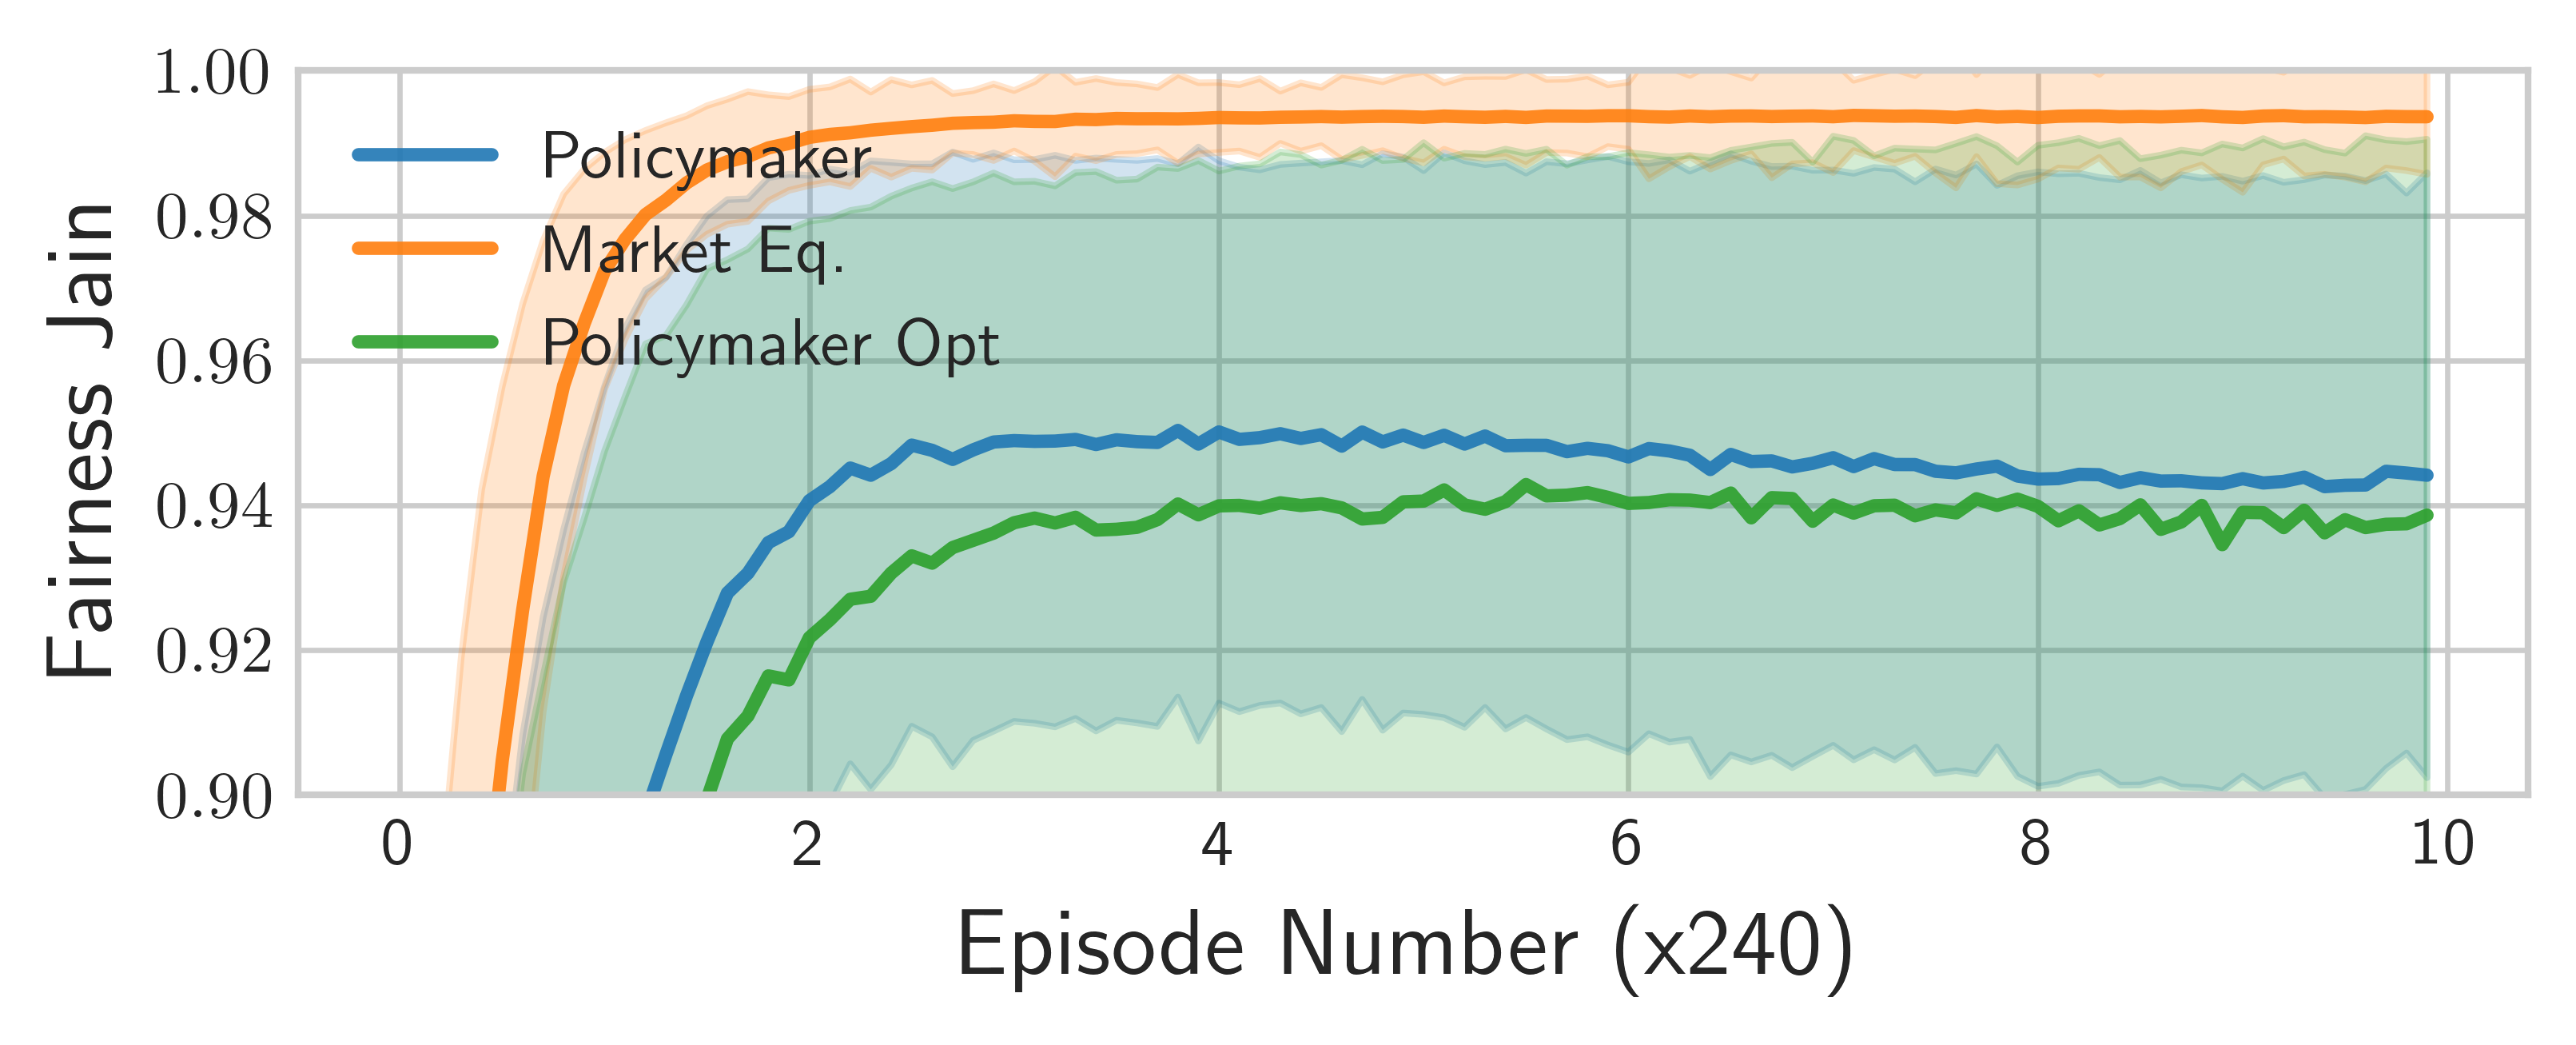

In [11]:
# Fairness Jain
y_axis_title = r'Fairness Jain'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['harvester_fairness'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker')
plt.fill_between(x_axis, np.array(results['logs']['harvester_fairness']) - np.array(results['logs']['harvester_fairness_sd']), np.array(results['logs']['harvester_fairness']) + np.array(results['logs']['harvester_fairness_sd']), color=palette(0), alpha=0.2)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['harvester_fairness'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Market Eq.')
plt.fill_between(x_axis, np.array(results['logs_true']['harvester_fairness']) - np.array(results['logs_true']['harvester_fairness_sd']), np.array(results['logs_true']['harvester_fairness']) + np.array(results['logs_true']['harvester_fairness_sd']), color=palette(1), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_fairness']['harvester_fairness'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker' + optimised)
plt.fill_between(x_axis, np.array(results['logs_fairness']['harvester_fairness']) - np.array(results['logs_fairness']['harvester_fairness_sd']), np.array(results['logs_fairness']['harvester_fairness']) + np.array(results['logs_fairness']['harvester_fairness_sd']), color=palette(2), alpha=0.2)


plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
axes.set_ylim([0.9,1])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

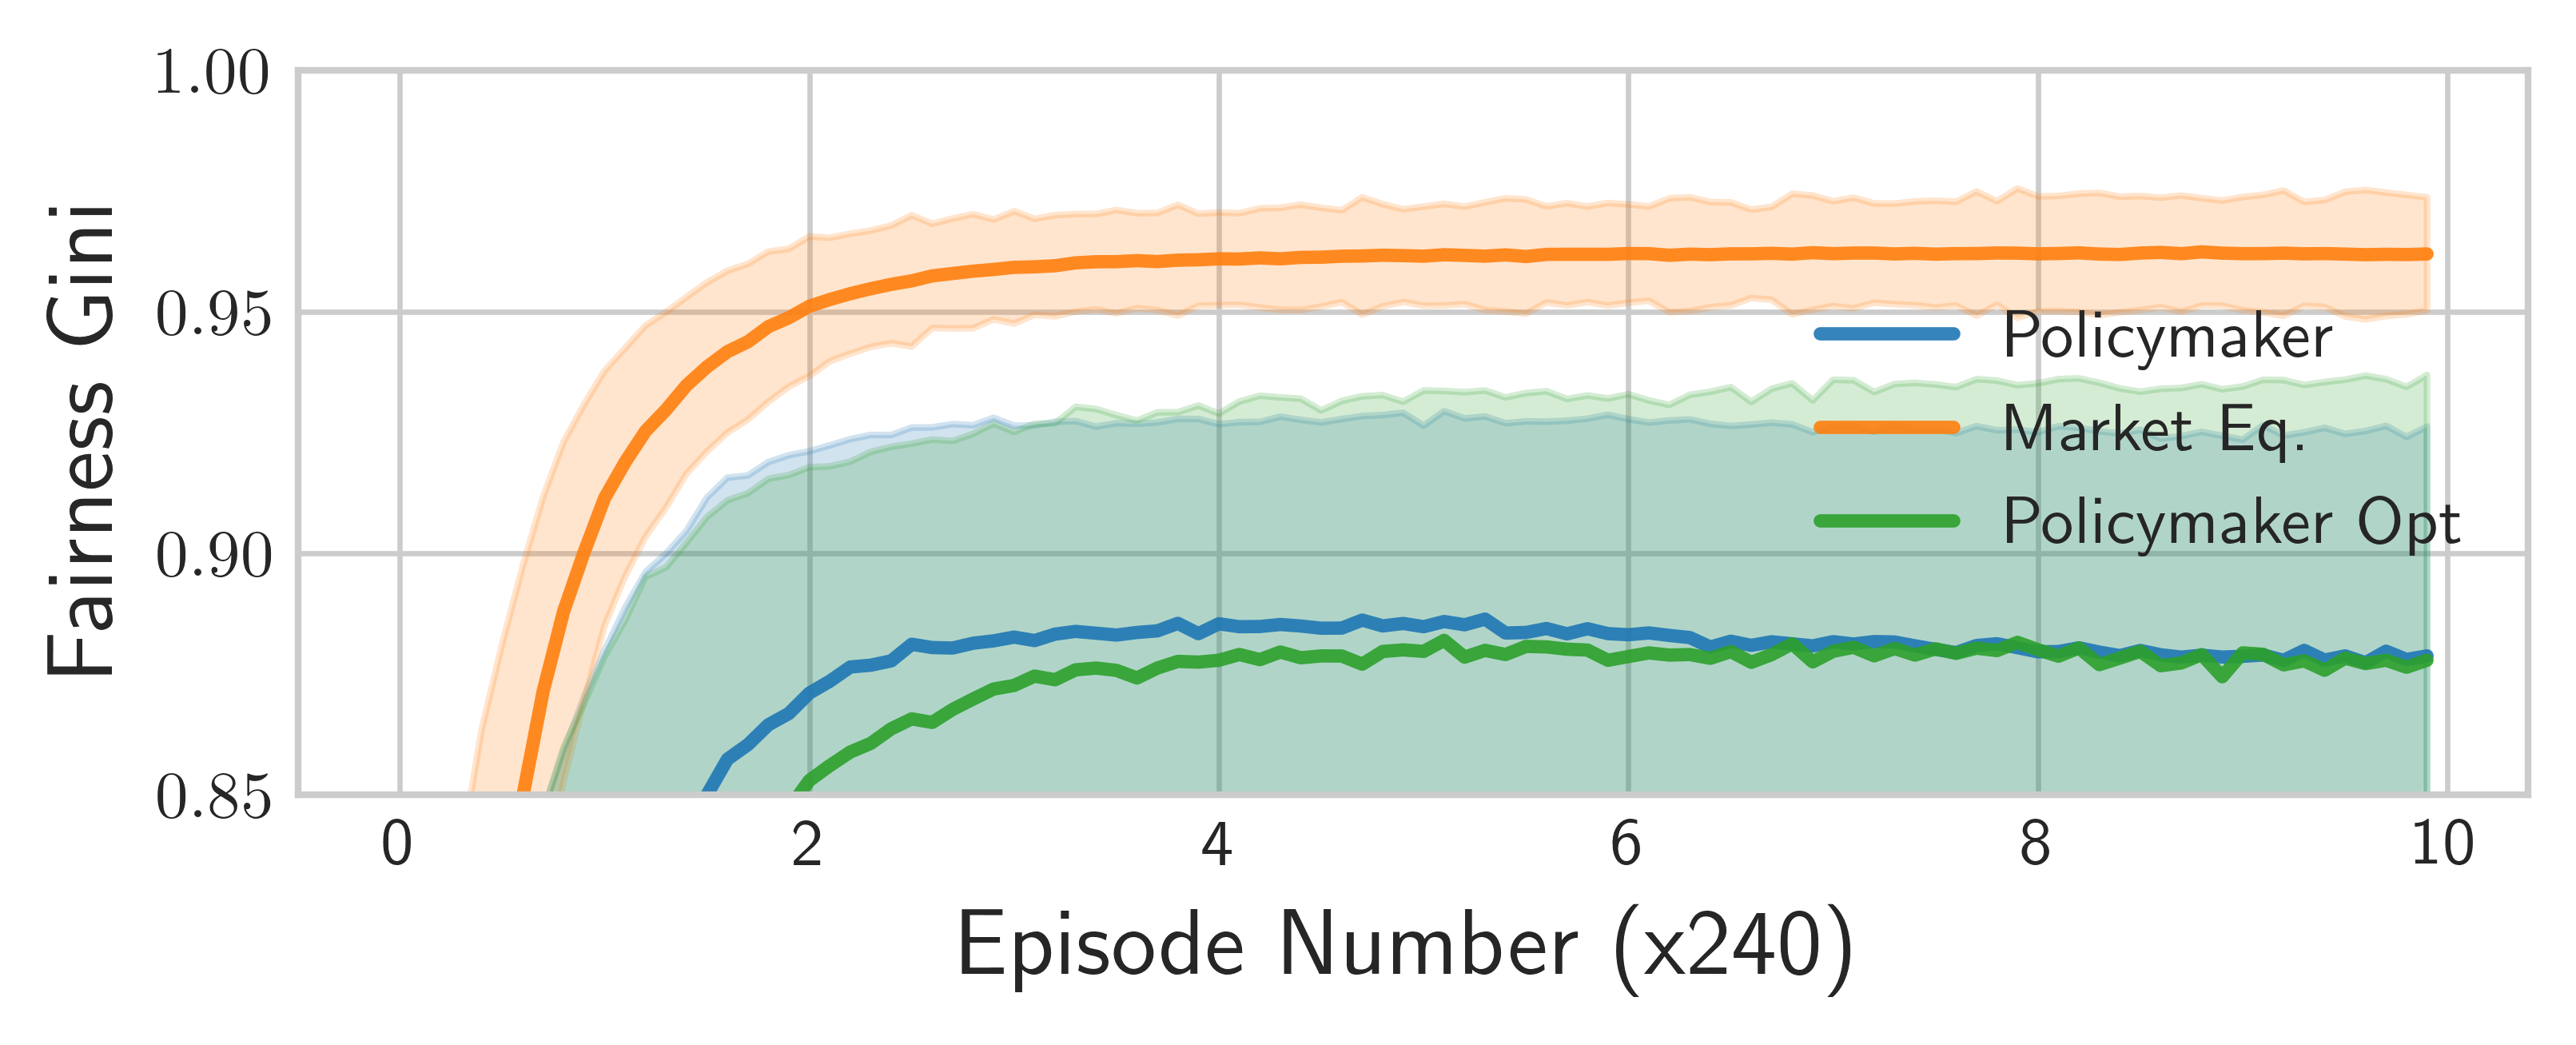

In [12]:
# Fairness Gini
y_axis_title = r'Fairness Gini'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs_gini']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs_gini']['harvester_fairness'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker')
plt.fill_between(x_axis, np.array(results['logs_gini']['harvester_fairness']) - np.array(results['logs_gini']['harvester_fairness_sd']), np.array(results['logs_gini']['harvester_fairness']) + np.array(results['logs_gini']['harvester_fairness_sd']), color=palette(0), alpha=0.2)
# Market Equilibrium
plt.plot(x_axis, results['logs_true_gini']['harvester_fairness'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Market Eq.')
plt.fill_between(x_axis, np.array(results['logs_true_gini']['harvester_fairness']) - np.array(results['logs_true_gini']['harvester_fairness_sd']), np.array(results['logs_true_gini']['harvester_fairness']) + np.array(results['logs_true_gini']['harvester_fairness_sd']), color=palette(1), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_gini_fairness']['harvester_fairness'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker' + optimised)
plt.fill_between(x_axis, np.array(results['logs_gini_fairness']['harvester_fairness']) - np.array(results['logs_gini_fairness']['harvester_fairness_sd']), np.array(results['logs_gini_fairness']['harvester_fairness']) + np.array(results['logs_gini_fairness']['harvester_fairness_sd']), color=palette(2), alpha=0.2)


plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
axes.set_ylim([0.85,1])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

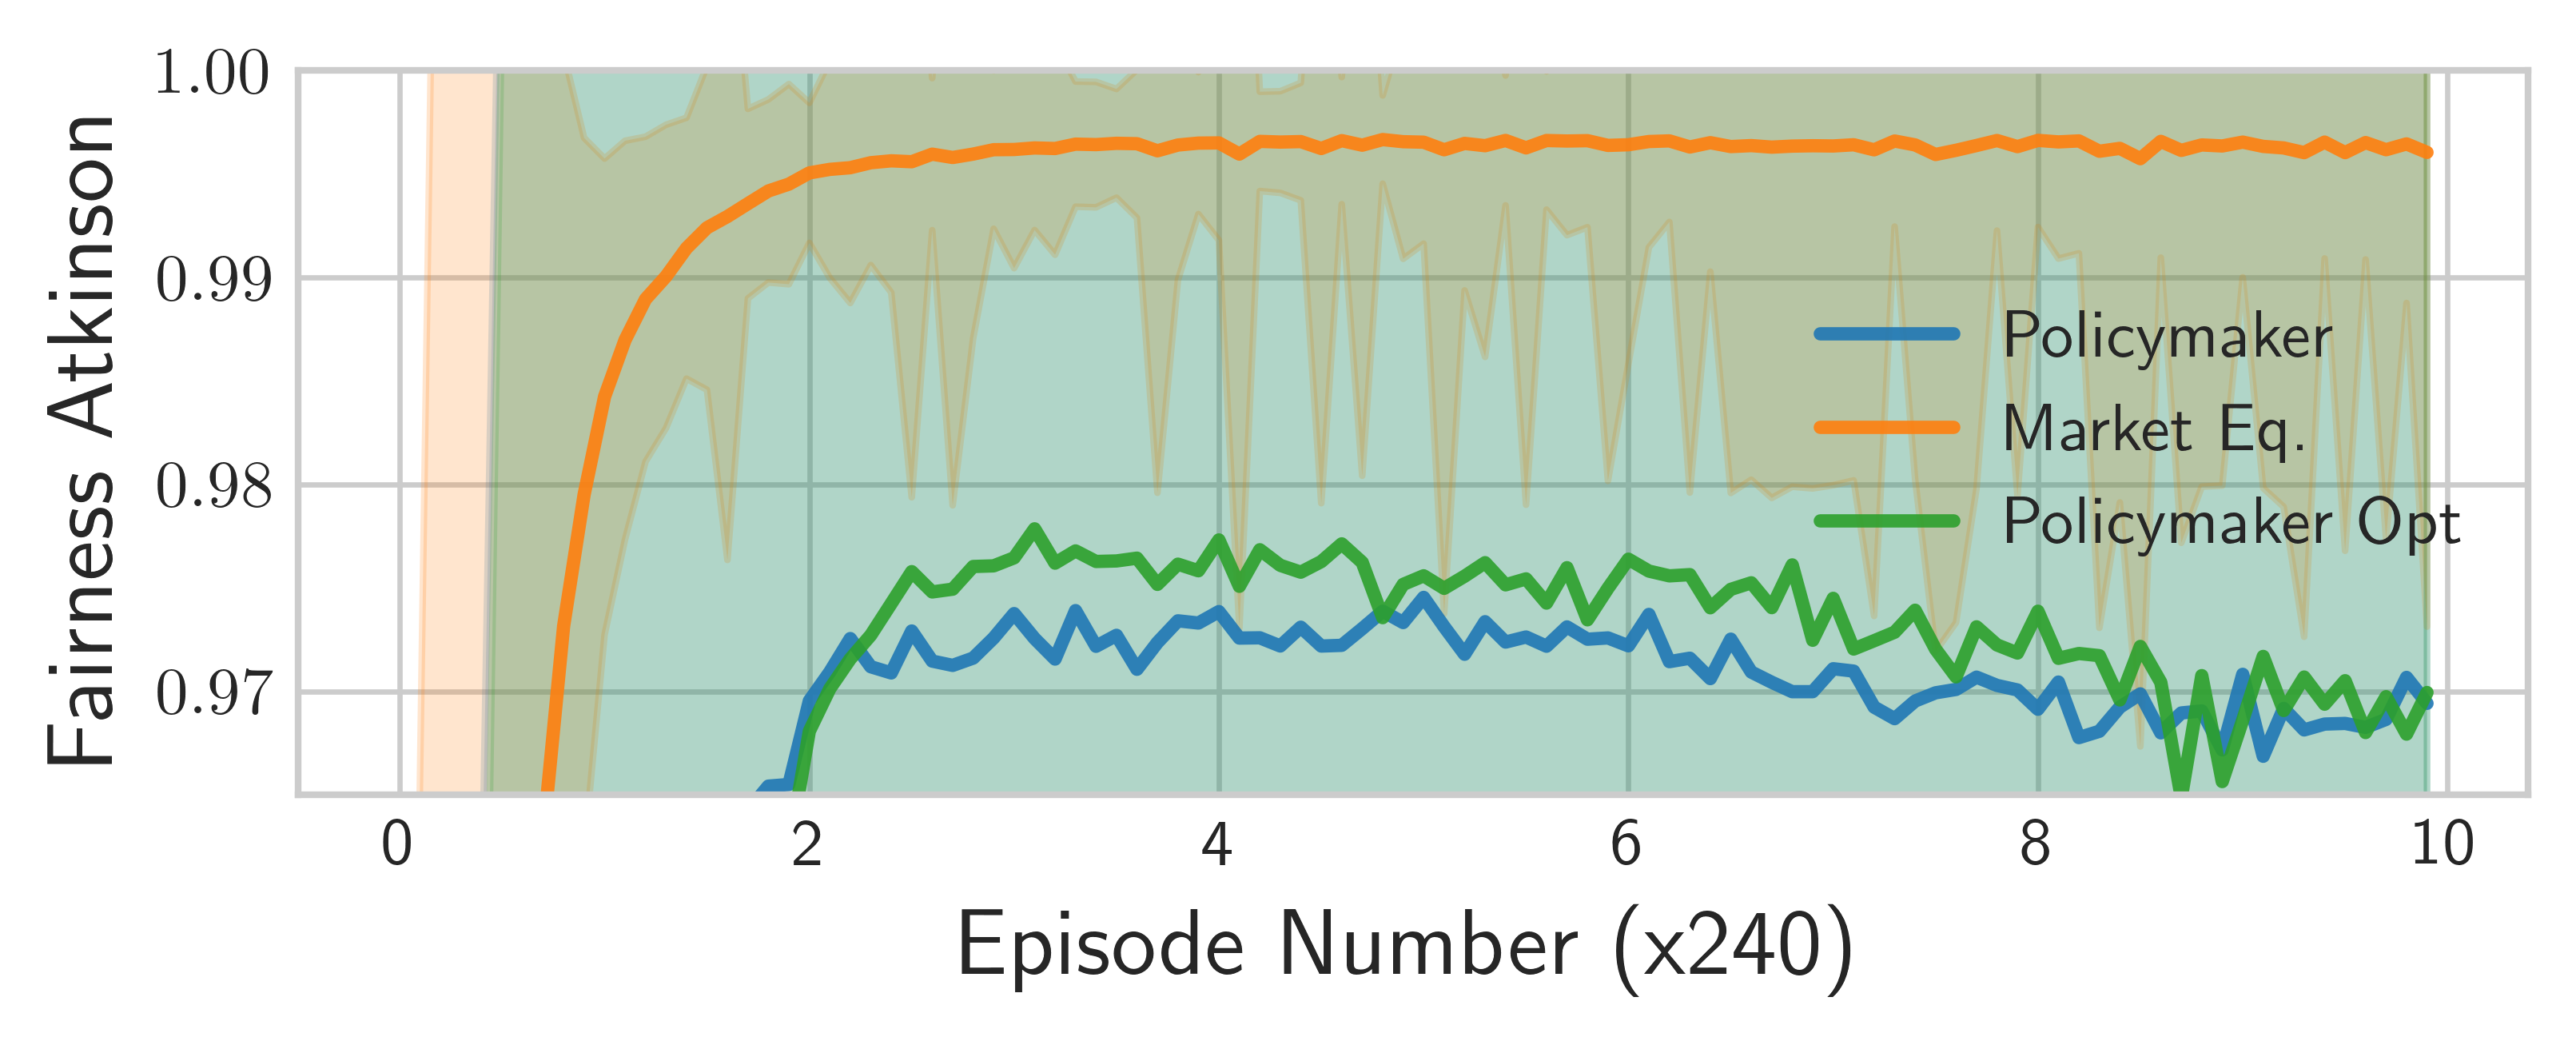

In [13]:
# Fairness Atkinson
y_axis_title = r'Fairness Atkinson'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs_atkinson']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs_atkinson']['harvester_fairness'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker')
plt.fill_between(x_axis, np.array(results['logs_atkinson']['harvester_fairness']) - np.array(results['logs_atkinson']['harvester_fairness_sd']), np.array(results['logs_atkinson']['harvester_fairness']) + np.array(results['logs_atkinson']['harvester_fairness_sd']), color=palette(0), alpha=0.2)
# Market Equilibrium
plt.plot(x_axis, results['logs_true_atkinson']['harvester_fairness'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Market Eq.')
plt.fill_between(x_axis, np.array(results['logs_true_atkinson']['harvester_fairness']) - np.array(results['logs_true_atkinson']['harvester_fairness_sd']), np.array(results['logs_true_atkinson']['harvester_fairness']) + np.array(results['logs_true_atkinson']['harvester_fairness_sd']), color=palette(1), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_atkinson_fairness']['harvester_fairness'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker' + optimised)
plt.fill_between(x_axis, np.array(results['logs_atkinson_fairness']['harvester_fairness']) - np.array(results['logs_atkinson_fairness']['harvester_fairness_sd']), np.array(results['logs_atkinson_fairness']['harvester_fairness']) + np.array(results['logs_atkinson_fairness']['harvester_fairness_sd']), color=palette(2), alpha=0.2)


plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
axes.set_ylim([0.965,1])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

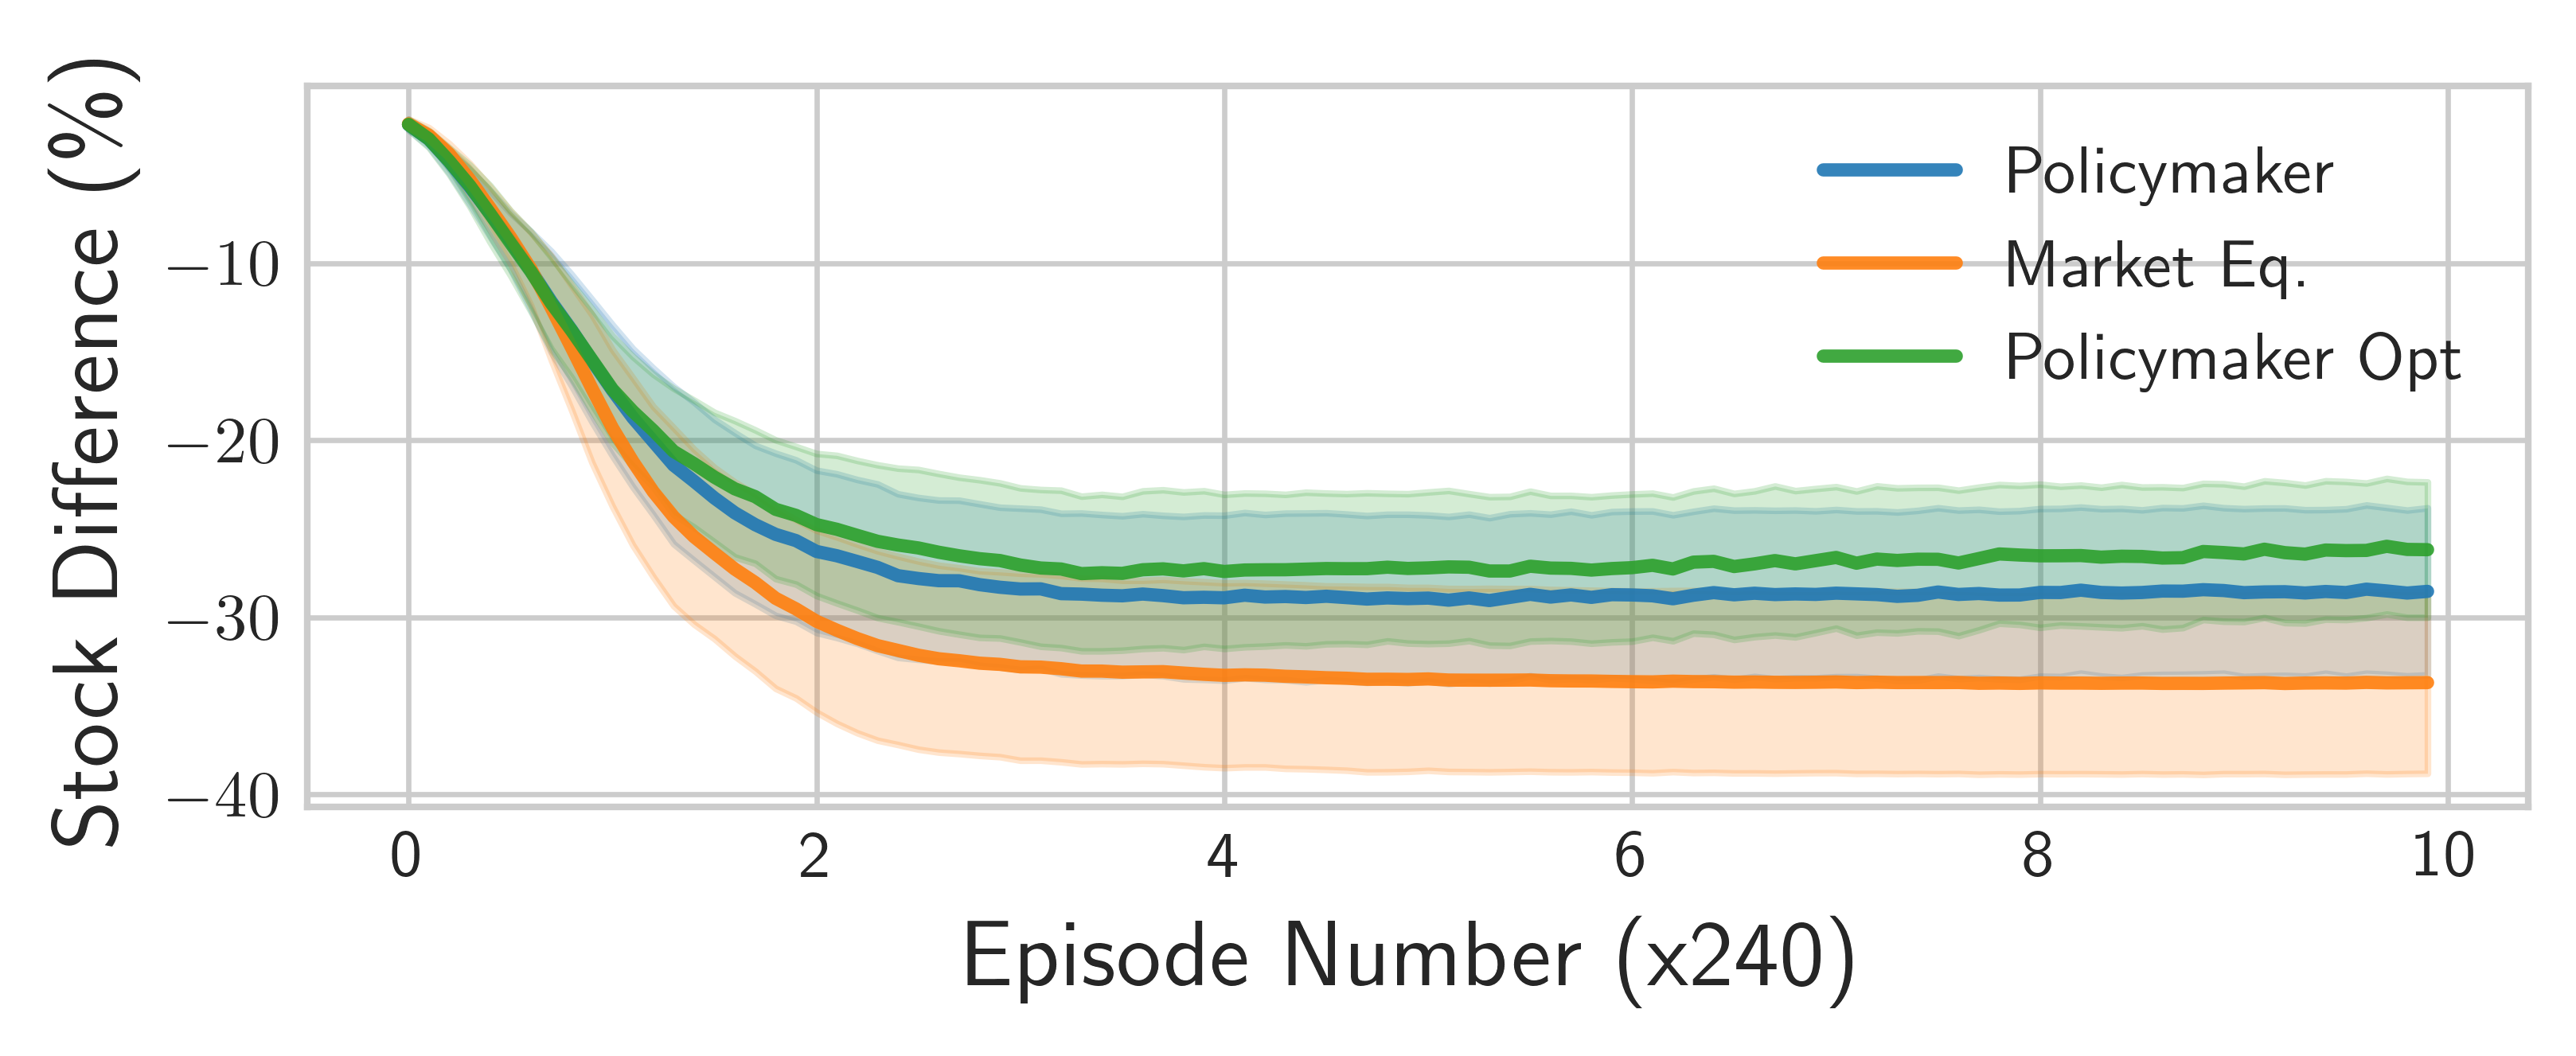

In [14]:
# Stock Difference
y_axis_title = r'Stock Difference (\%)'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['stock_difference'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker')
plt.fill_between(x_axis, np.array(results['logs']['stock_difference']) - np.array(results['logs']['stock_difference_sd']), np.array(results['logs']['stock_difference']) + np.array(results['logs']['stock_difference_sd']), color=palette(0), alpha=0.2)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['stock_difference'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Market Eq.')
plt.fill_between(x_axis, np.array(results['logs_true']['stock_difference']) - np.array(results['logs_true']['stock_difference_sd']), np.array(results['logs_true']['stock_difference']) + np.array(results['logs_true']['stock_difference_sd']), color=palette(1), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_sustainability']['stock_difference'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker' + optimised)
plt.fill_between(x_axis, np.array(results['logs_sustainability']['stock_difference']) - np.array(results['logs_sustainability']['stock_difference_sd']), np.array(results['logs_sustainability']['stock_difference']) + np.array(results['logs_sustainability']['stock_difference_sd']), color=palette(2), alpha=0.2)

# # Policymaker
# plt.plot(x_axis, results['logs']['stock_difference_min'], color=palette(0), marker=markers[0], linestyle=linestyles[3], linewidth=LINEWIDTH, alpha=0.9)
# # Market Equilibrium
# plt.plot(x_axis, results['logs_true']['stock_difference_min'], color=palette(1), marker=markers[0], linestyle=linestyles[3], linewidth=LINEWIDTH, alpha=0.9)
# # Policymaker
# plt.plot(x_axis, results['logs_sustainability']['stock_difference_min'], color=palette(2), marker=markers[0], linestyle=linestyles[3], linewidth=LINEWIDTH, alpha=0.9)

plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
# axes.set_ylim([0,5])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

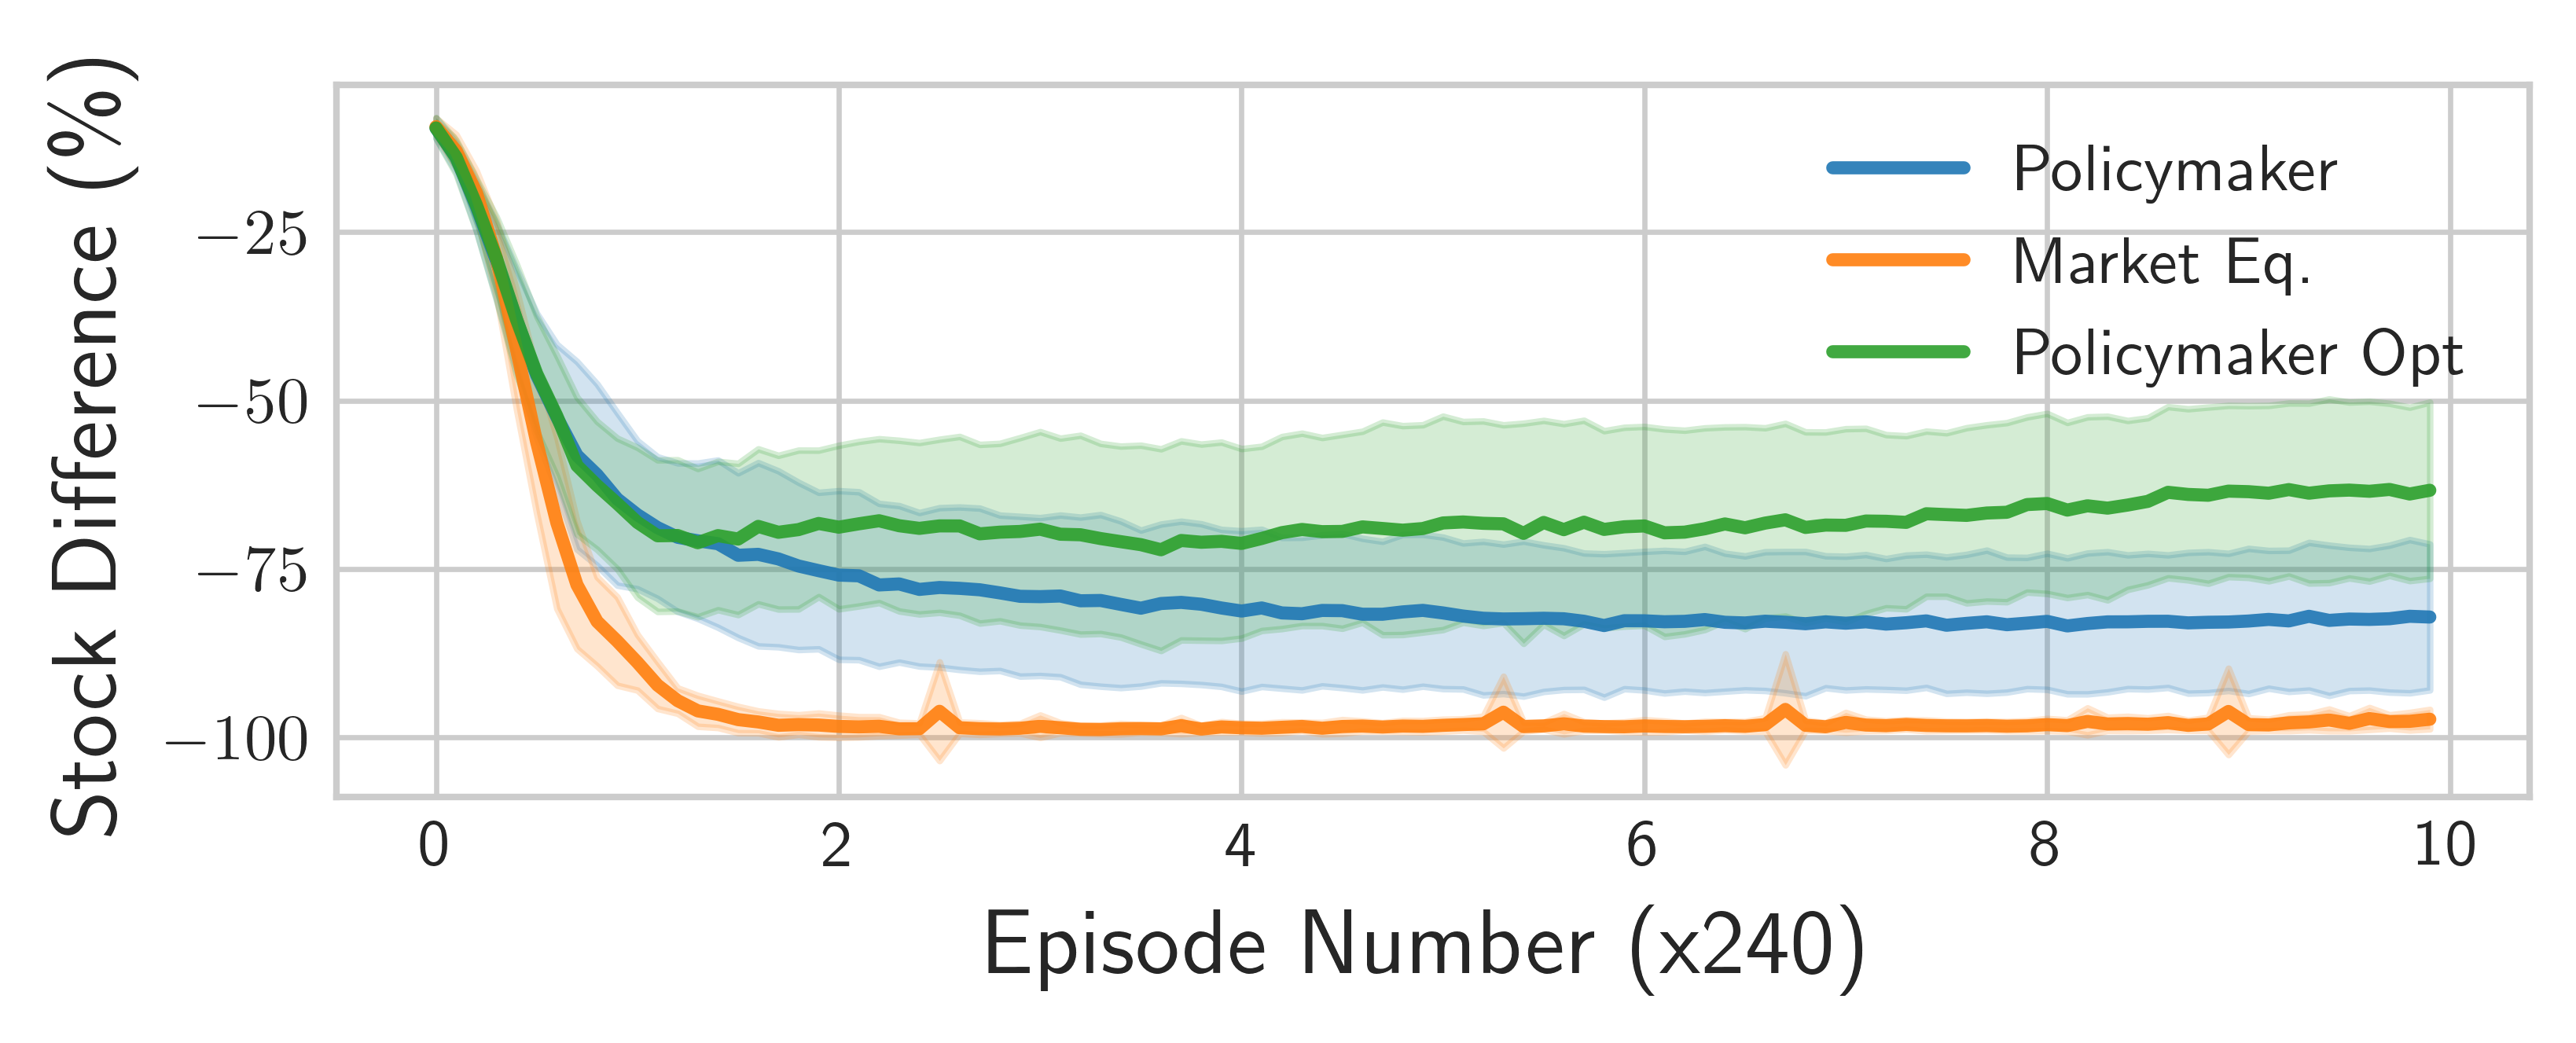

In [15]:
# Stock Difference, Scare Resources
y_axis_title = r'Stock Difference (\%)'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs_Ms_0p45']['stock_difference'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker')
plt.fill_between(x_axis, np.array(results['logs_Ms_0p45']['stock_difference']) - np.array(results['logs_Ms_0p45']['stock_difference_sd']), np.array(results['logs_Ms_0p45']['stock_difference']) + np.array(results['logs_Ms_0p45']['stock_difference_sd']), color=palette(0), alpha=0.2)
# Market Equilibrium
plt.plot(x_axis, results['logs_true_Ms_0p45']['stock_difference'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Market Eq.')
plt.fill_between(x_axis, np.array(results['logs_true_Ms_0p45']['stock_difference']) - np.array(results['logs_true_Ms_0p45']['stock_difference_sd']), np.array(results['logs_true_Ms_0p45']['stock_difference']) + np.array(results['logs_true_Ms_0p45']['stock_difference_sd']), color=palette(1), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_Ms_0p45_sustainability']['stock_difference'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker' + optimised)
plt.fill_between(x_axis, np.array(results['logs_Ms_0p45_sustainability']['stock_difference']) - np.array(results['logs_Ms_0p45_sustainability']['stock_difference_sd']), np.array(results['logs_Ms_0p45_sustainability']['stock_difference']) + np.array(results['logs_Ms_0p45_sustainability']['stock_difference_sd']), color=palette(2), alpha=0.2)


plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
# axes.set_ylim([0,5])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower() + '_scarce'
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

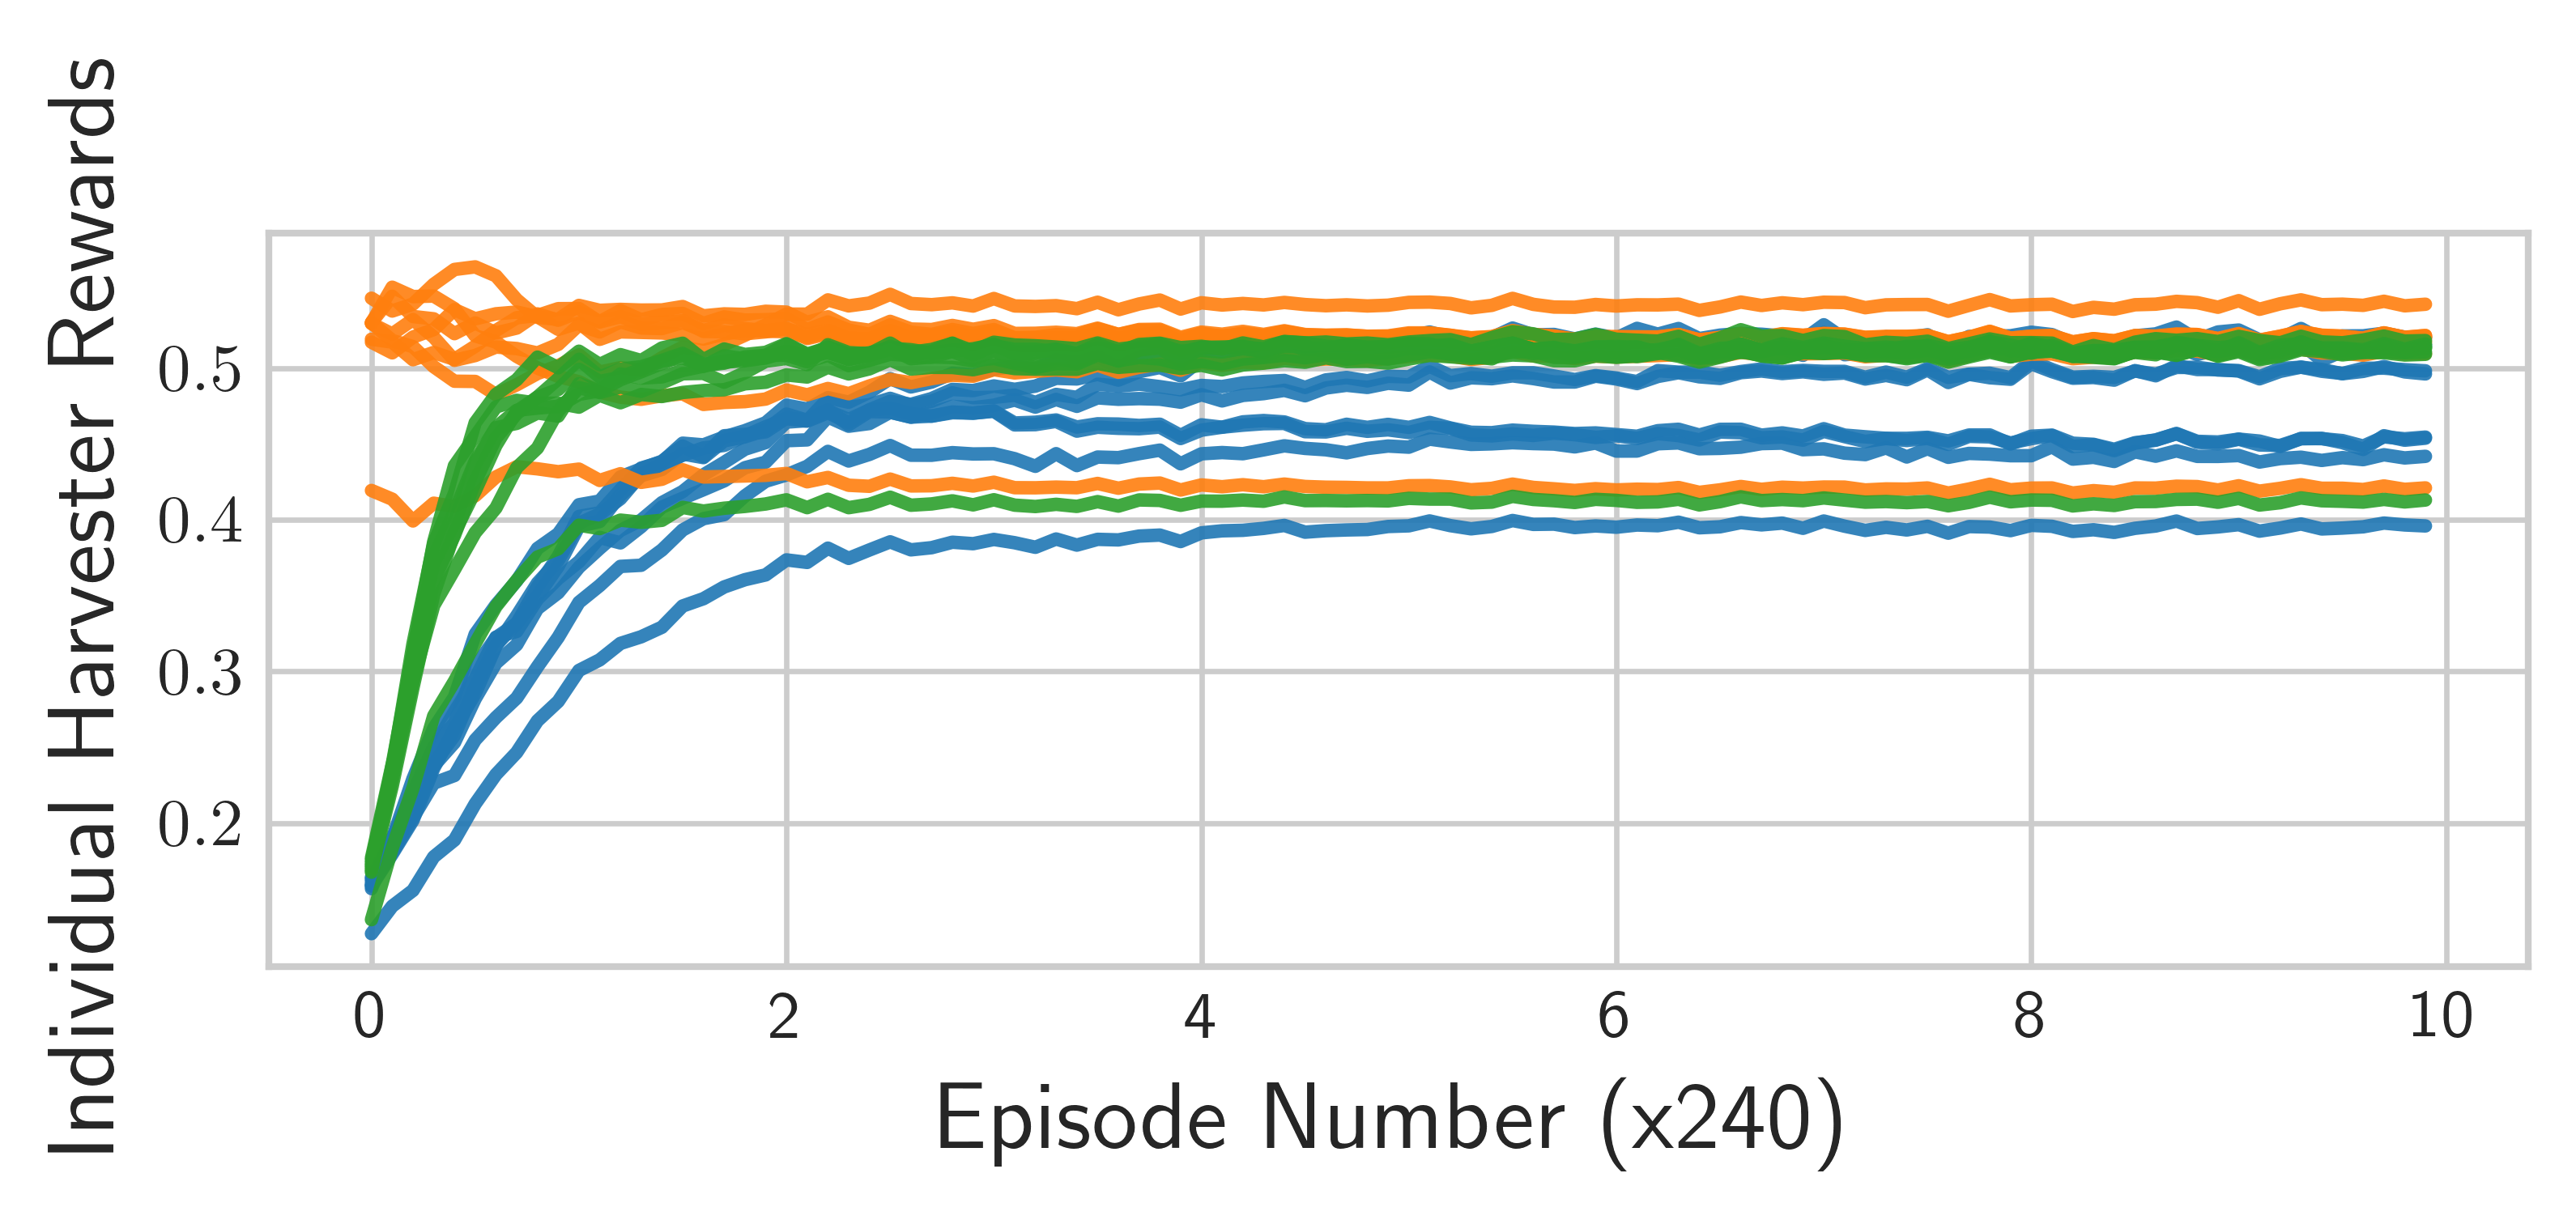

In [16]:
# Individual Harvester Rewards
y_axis_title = r'Individual Harvester Rewards'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['harvester_rewards'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['harvester_rewards'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)
# Policymaker
plt.plot(x_axis, results['logs_harvesters']['harvester_rewards'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)

plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
# legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
# axes.set_ylim([0,5])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

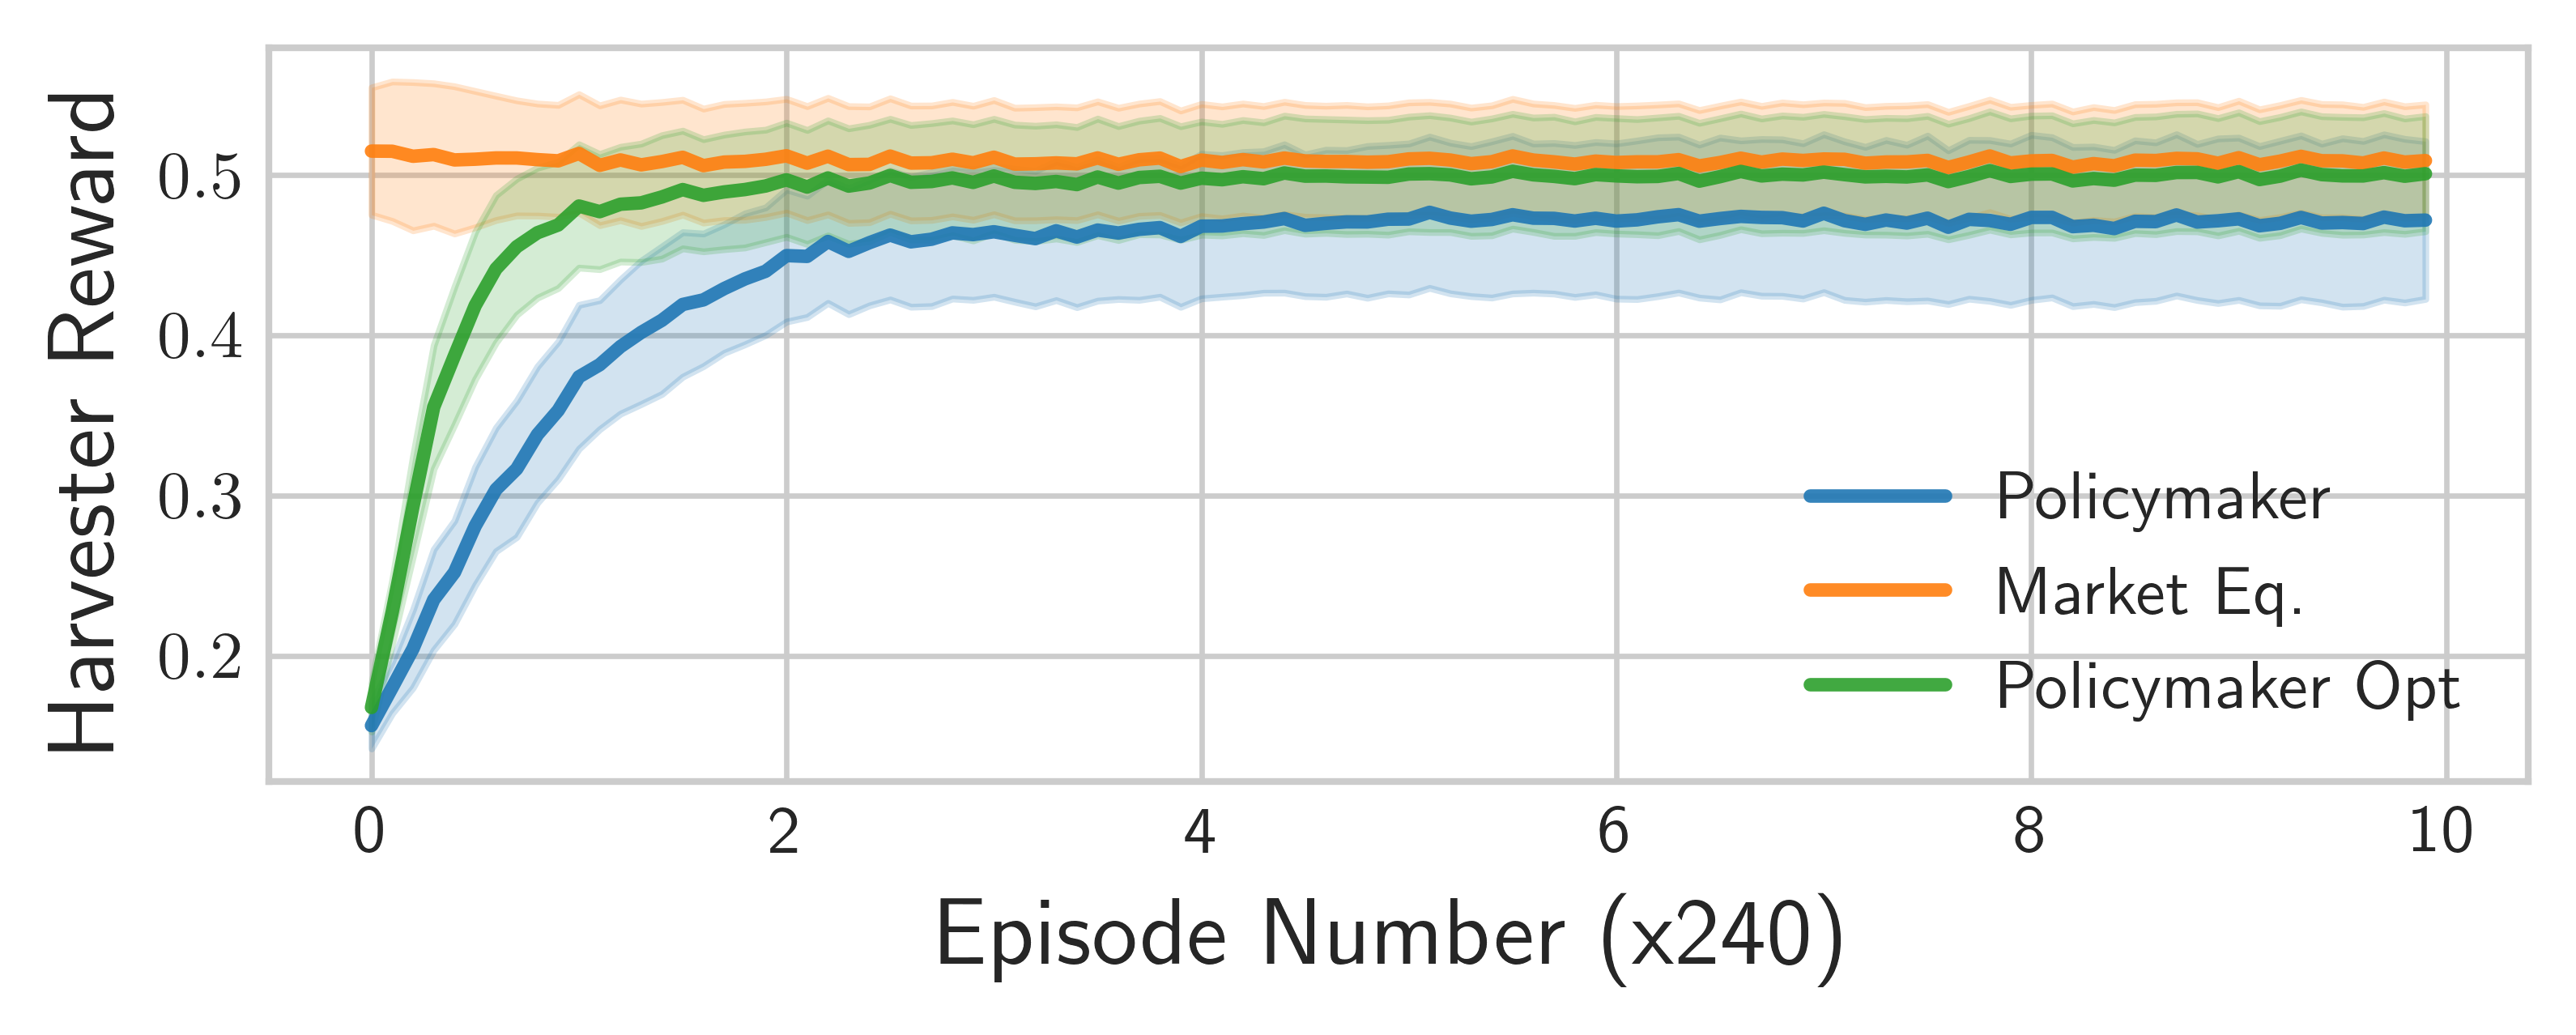

In [17]:
# Harvester Rewards Mean
y_axis_title = r'Harvester Reward'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['harvester_rewards_mean'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker')
plt.fill_between(x_axis, np.array(results['logs']['harvester_rewards_mean']) - np.array(results['logs']['harvester_rewards_mean_sd']), np.array(results['logs']['harvester_rewards_mean']) + np.array(results['logs']['harvester_rewards_mean_sd']), color=palette(0), alpha=0.2)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['harvester_rewards_mean'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Market Eq.')
plt.fill_between(x_axis, np.array(results['logs_true']['harvester_rewards_mean']) - np.array(results['logs_true']['harvester_rewards_mean_sd']), np.array(results['logs_true']['harvester_rewards_mean']) + np.array(results['logs_true']['harvester_rewards_mean_sd']), color=palette(1), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_harvesters']['harvester_rewards_mean'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker' + optimised)
plt.fill_between(x_axis, np.array(results['logs_harvesters']['harvester_rewards_mean']) - np.array(results['logs_harvesters']['harvester_rewards_mean_sd']), np.array(results['logs_harvesters']['harvester_rewards_mean']) + np.array(results['logs_harvesters']['harvester_rewards_mean_sd']), color=palette(2), alpha=0.2)

plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
# axes.set_ylim([0,5])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

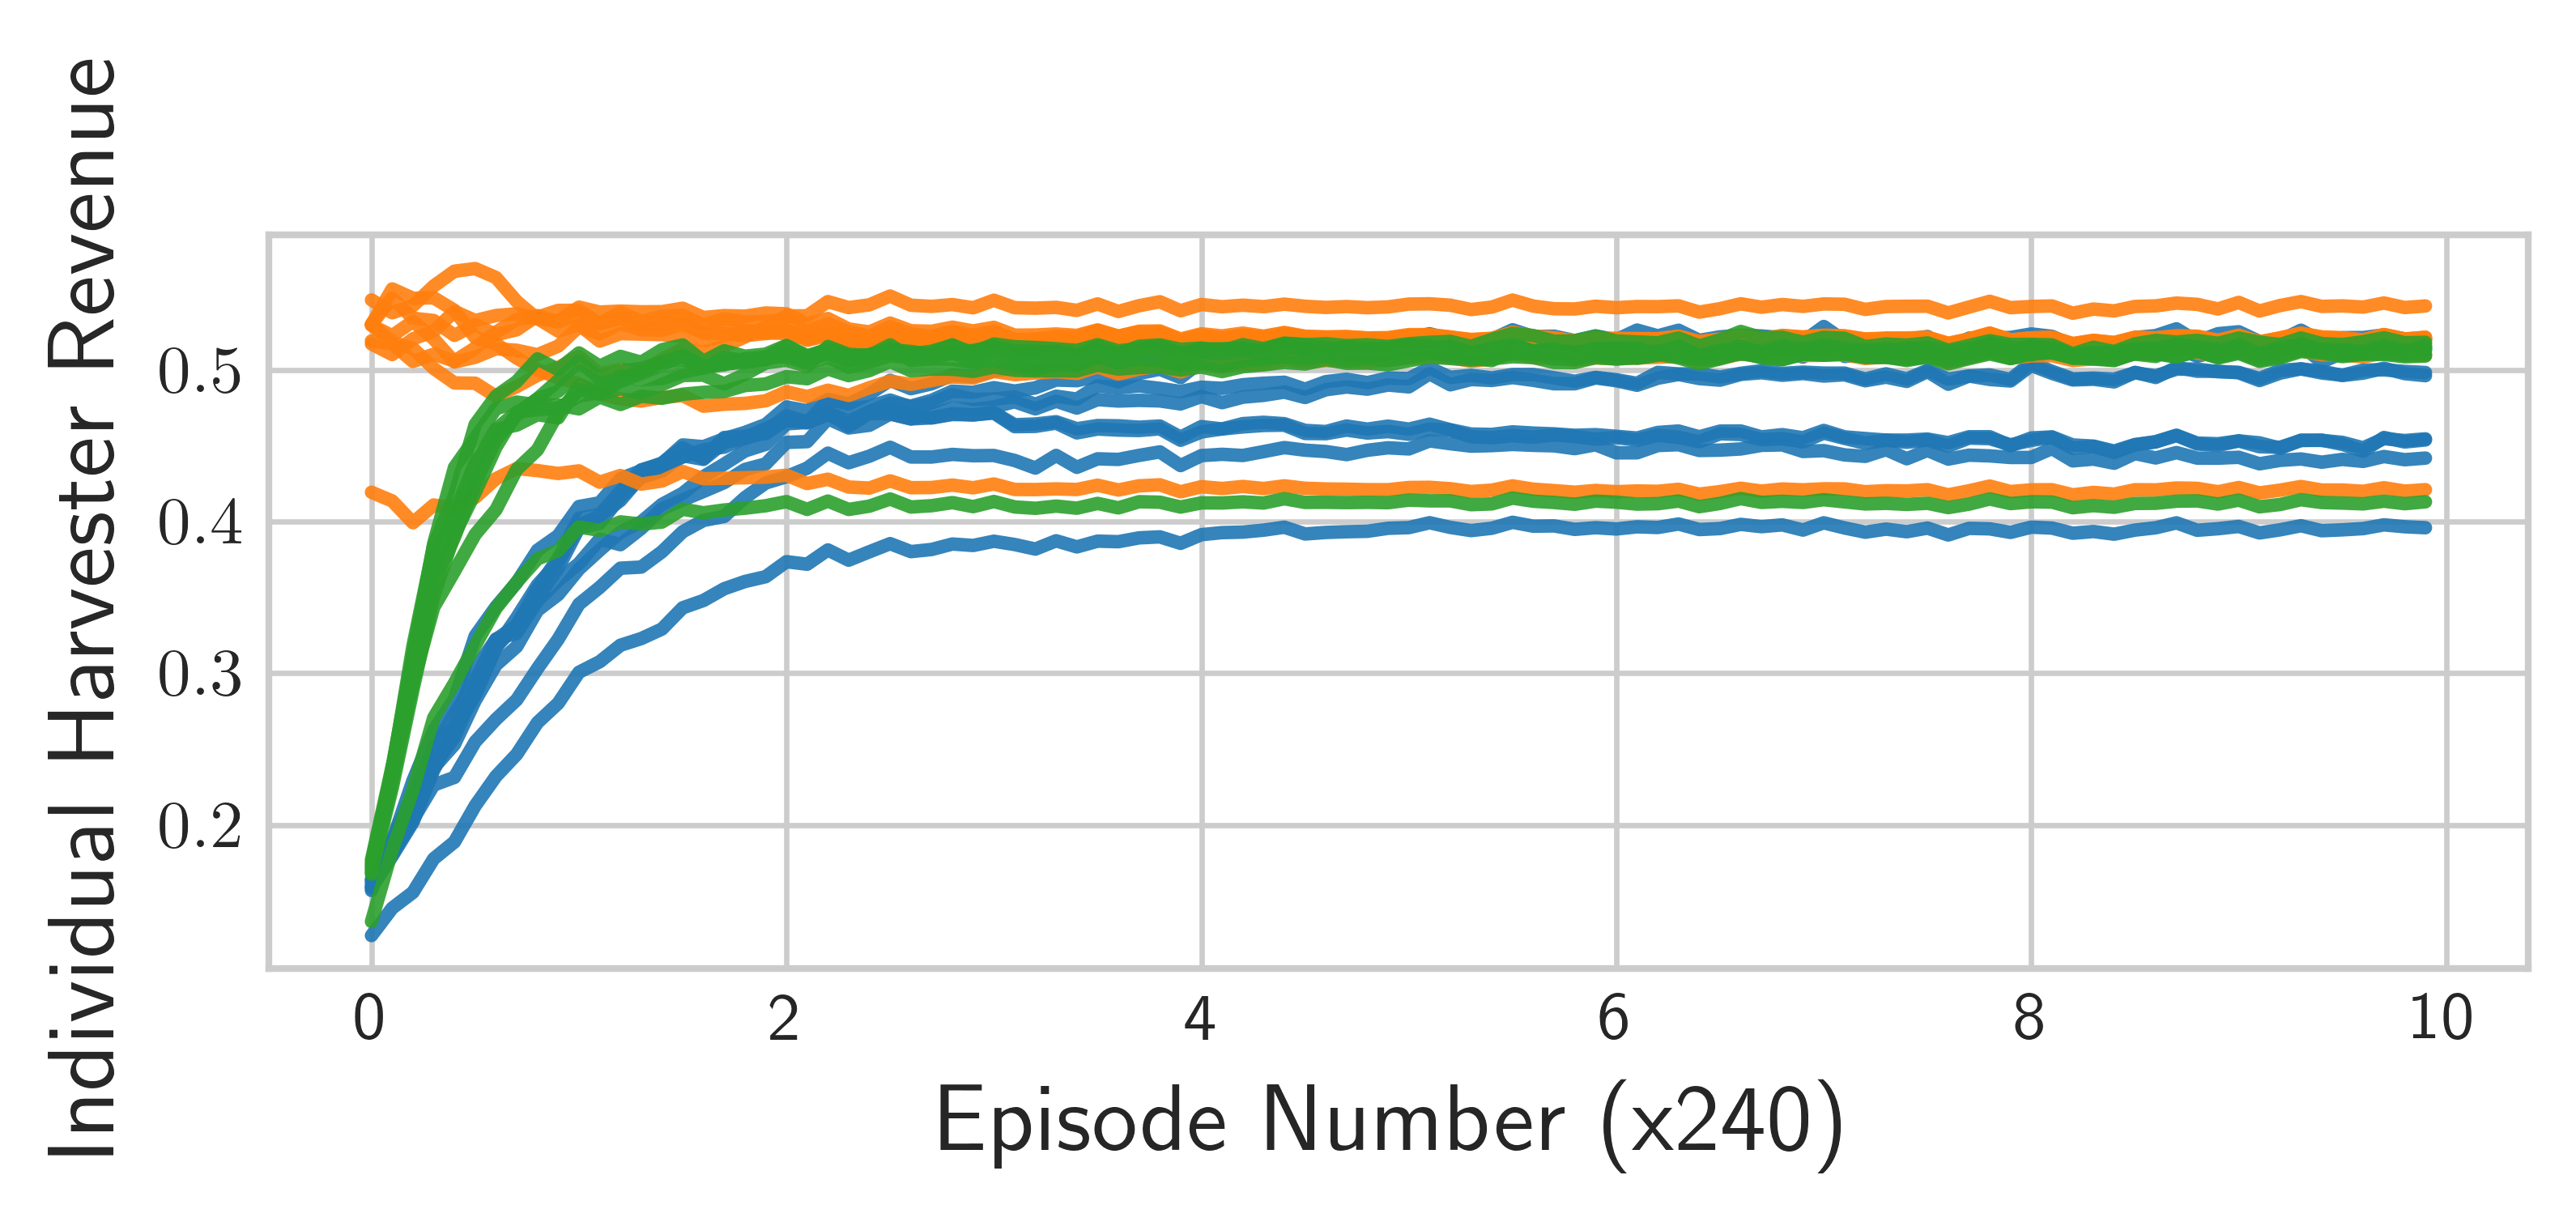

In [18]:
# Individual Harvester Revenue
y_axis_title = r'Individual Harvester Revenue'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['harvester_revenue'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['harvester_revenue'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)
# Policymaker
plt.plot(x_axis, results['logs_harvesters']['harvester_revenue'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)

plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
# legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
# axes.set_ylim([0,5])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

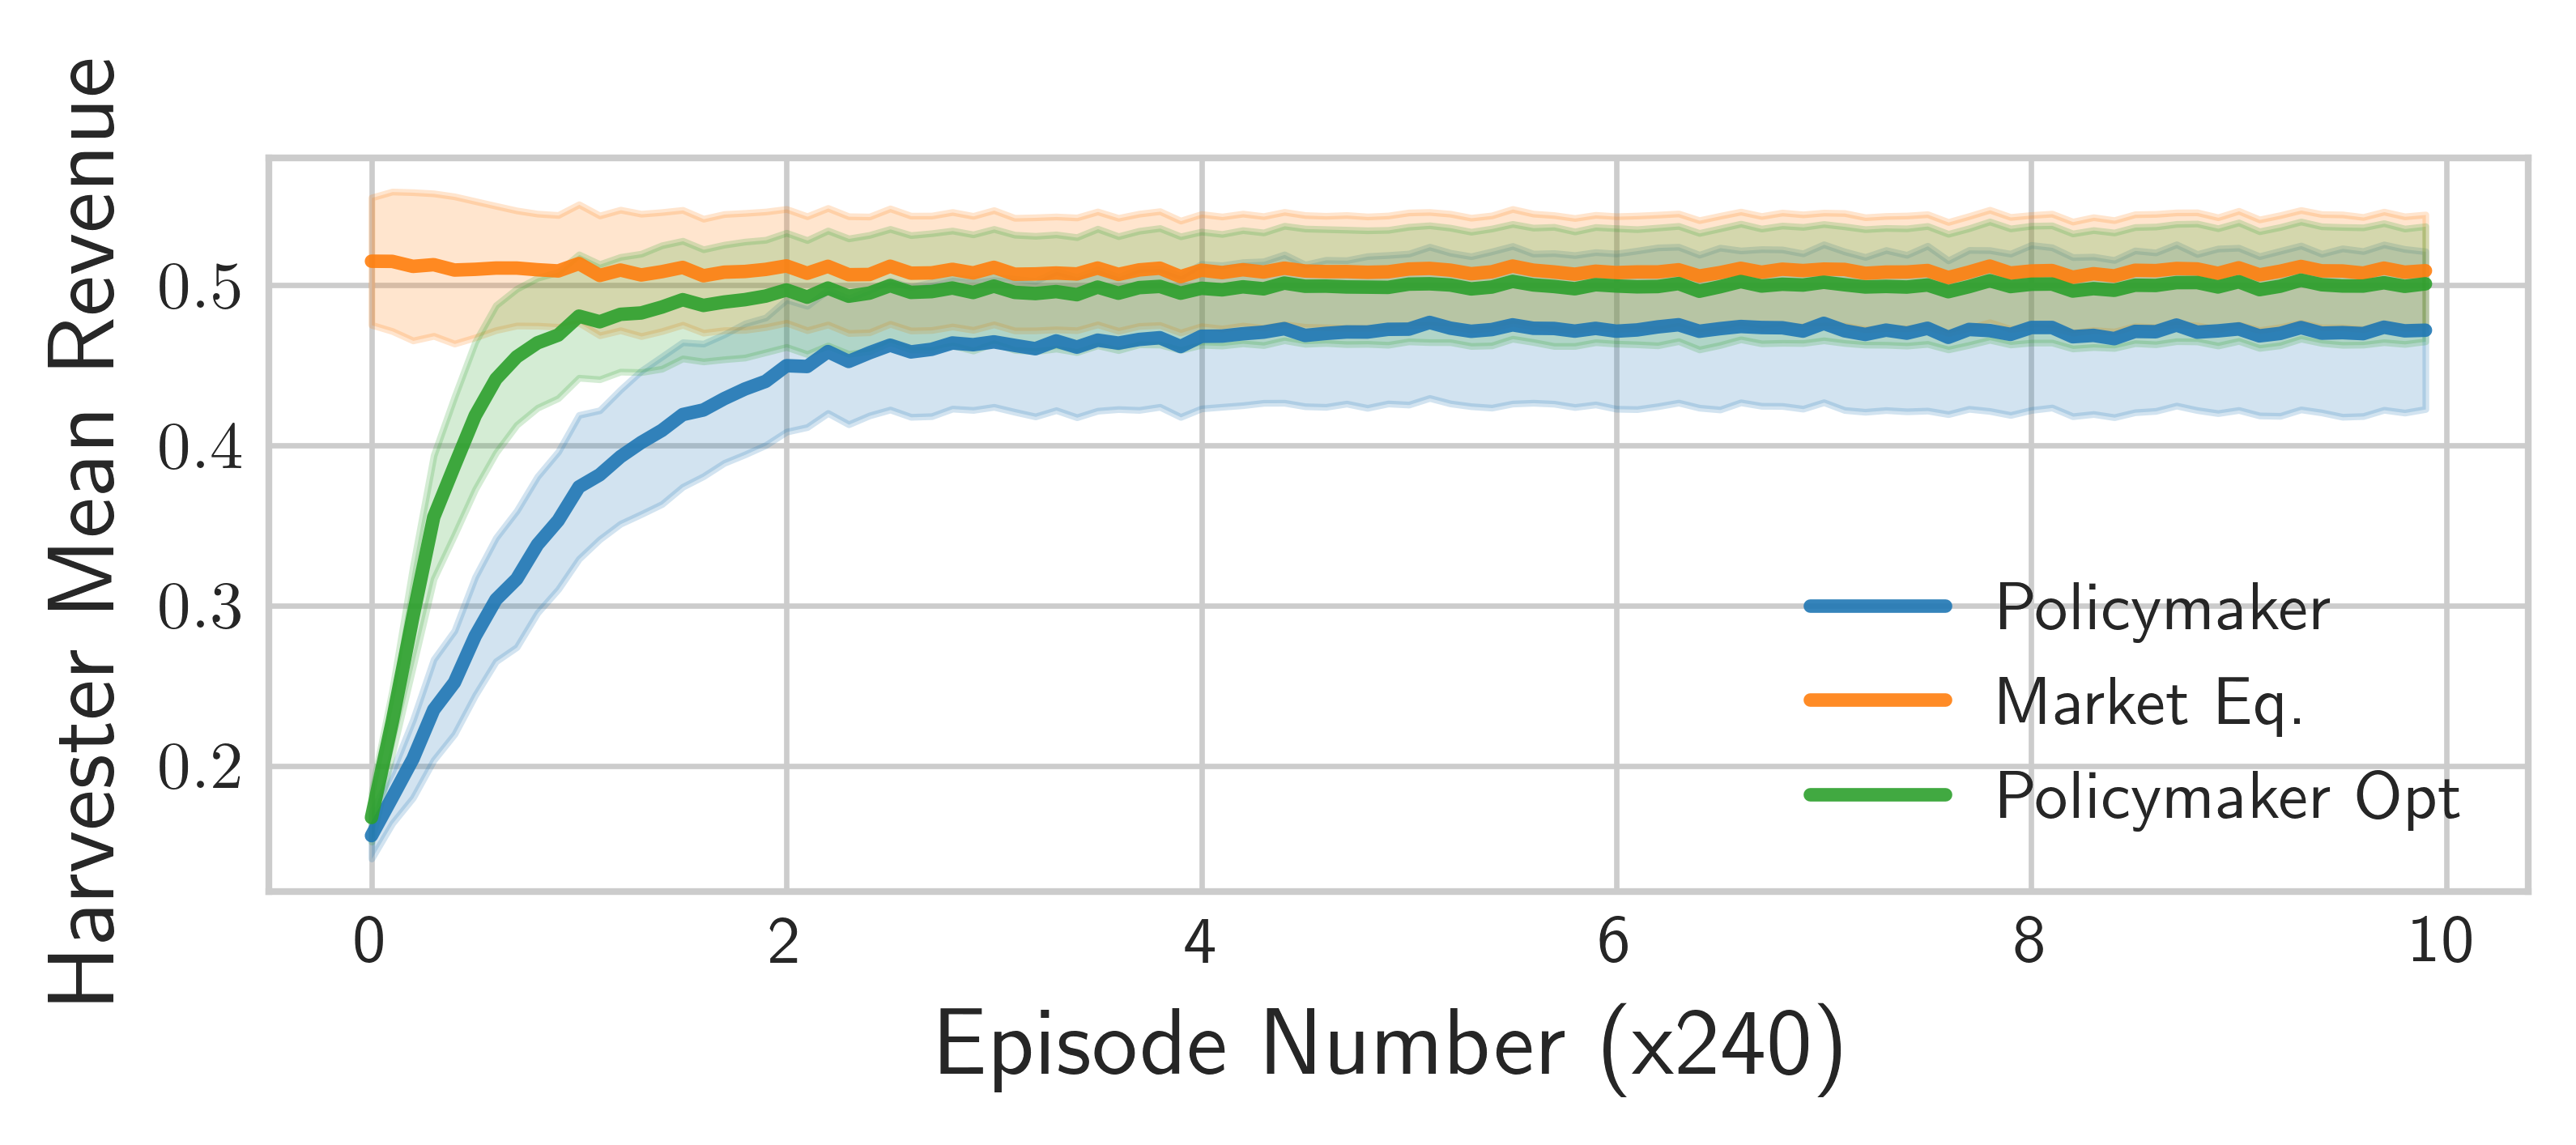

In [19]:
# Harvester Revenue Mean
y_axis_title = r'Harvester Mean Revenue'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['harvester_revenue_mean'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker')
plt.fill_between(x_axis, np.array(results['logs']['harvester_revenue_mean']) - np.array(results['logs']['harvester_revenue_mean_sd']), np.array(results['logs']['harvester_revenue_mean']) + np.array(results['logs']['harvester_revenue_mean_sd']), color=palette(0), alpha=0.2)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['harvester_revenue_mean'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Market Eq.')
plt.fill_between(x_axis, np.array(results['logs_true']['harvester_revenue_mean']) - np.array(results['logs_true']['harvester_revenue_mean_sd']), np.array(results['logs_true']['harvester_revenue_mean']) + np.array(results['logs_true']['harvester_revenue_mean_sd']), color=palette(1), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_harvesters']['harvester_revenue_mean'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker' + optimised)
plt.fill_between(x_axis, np.array(results['logs_harvesters']['harvester_revenue_mean']) - np.array(results['logs_harvesters']['harvester_revenue_mean_sd']), np.array(results['logs_harvesters']['harvester_revenue_mean']) + np.array(results['logs_harvesters']['harvester_revenue_mean_sd']), color=palette(2), alpha=0.2)

plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
# axes.set_ylim([0,5])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

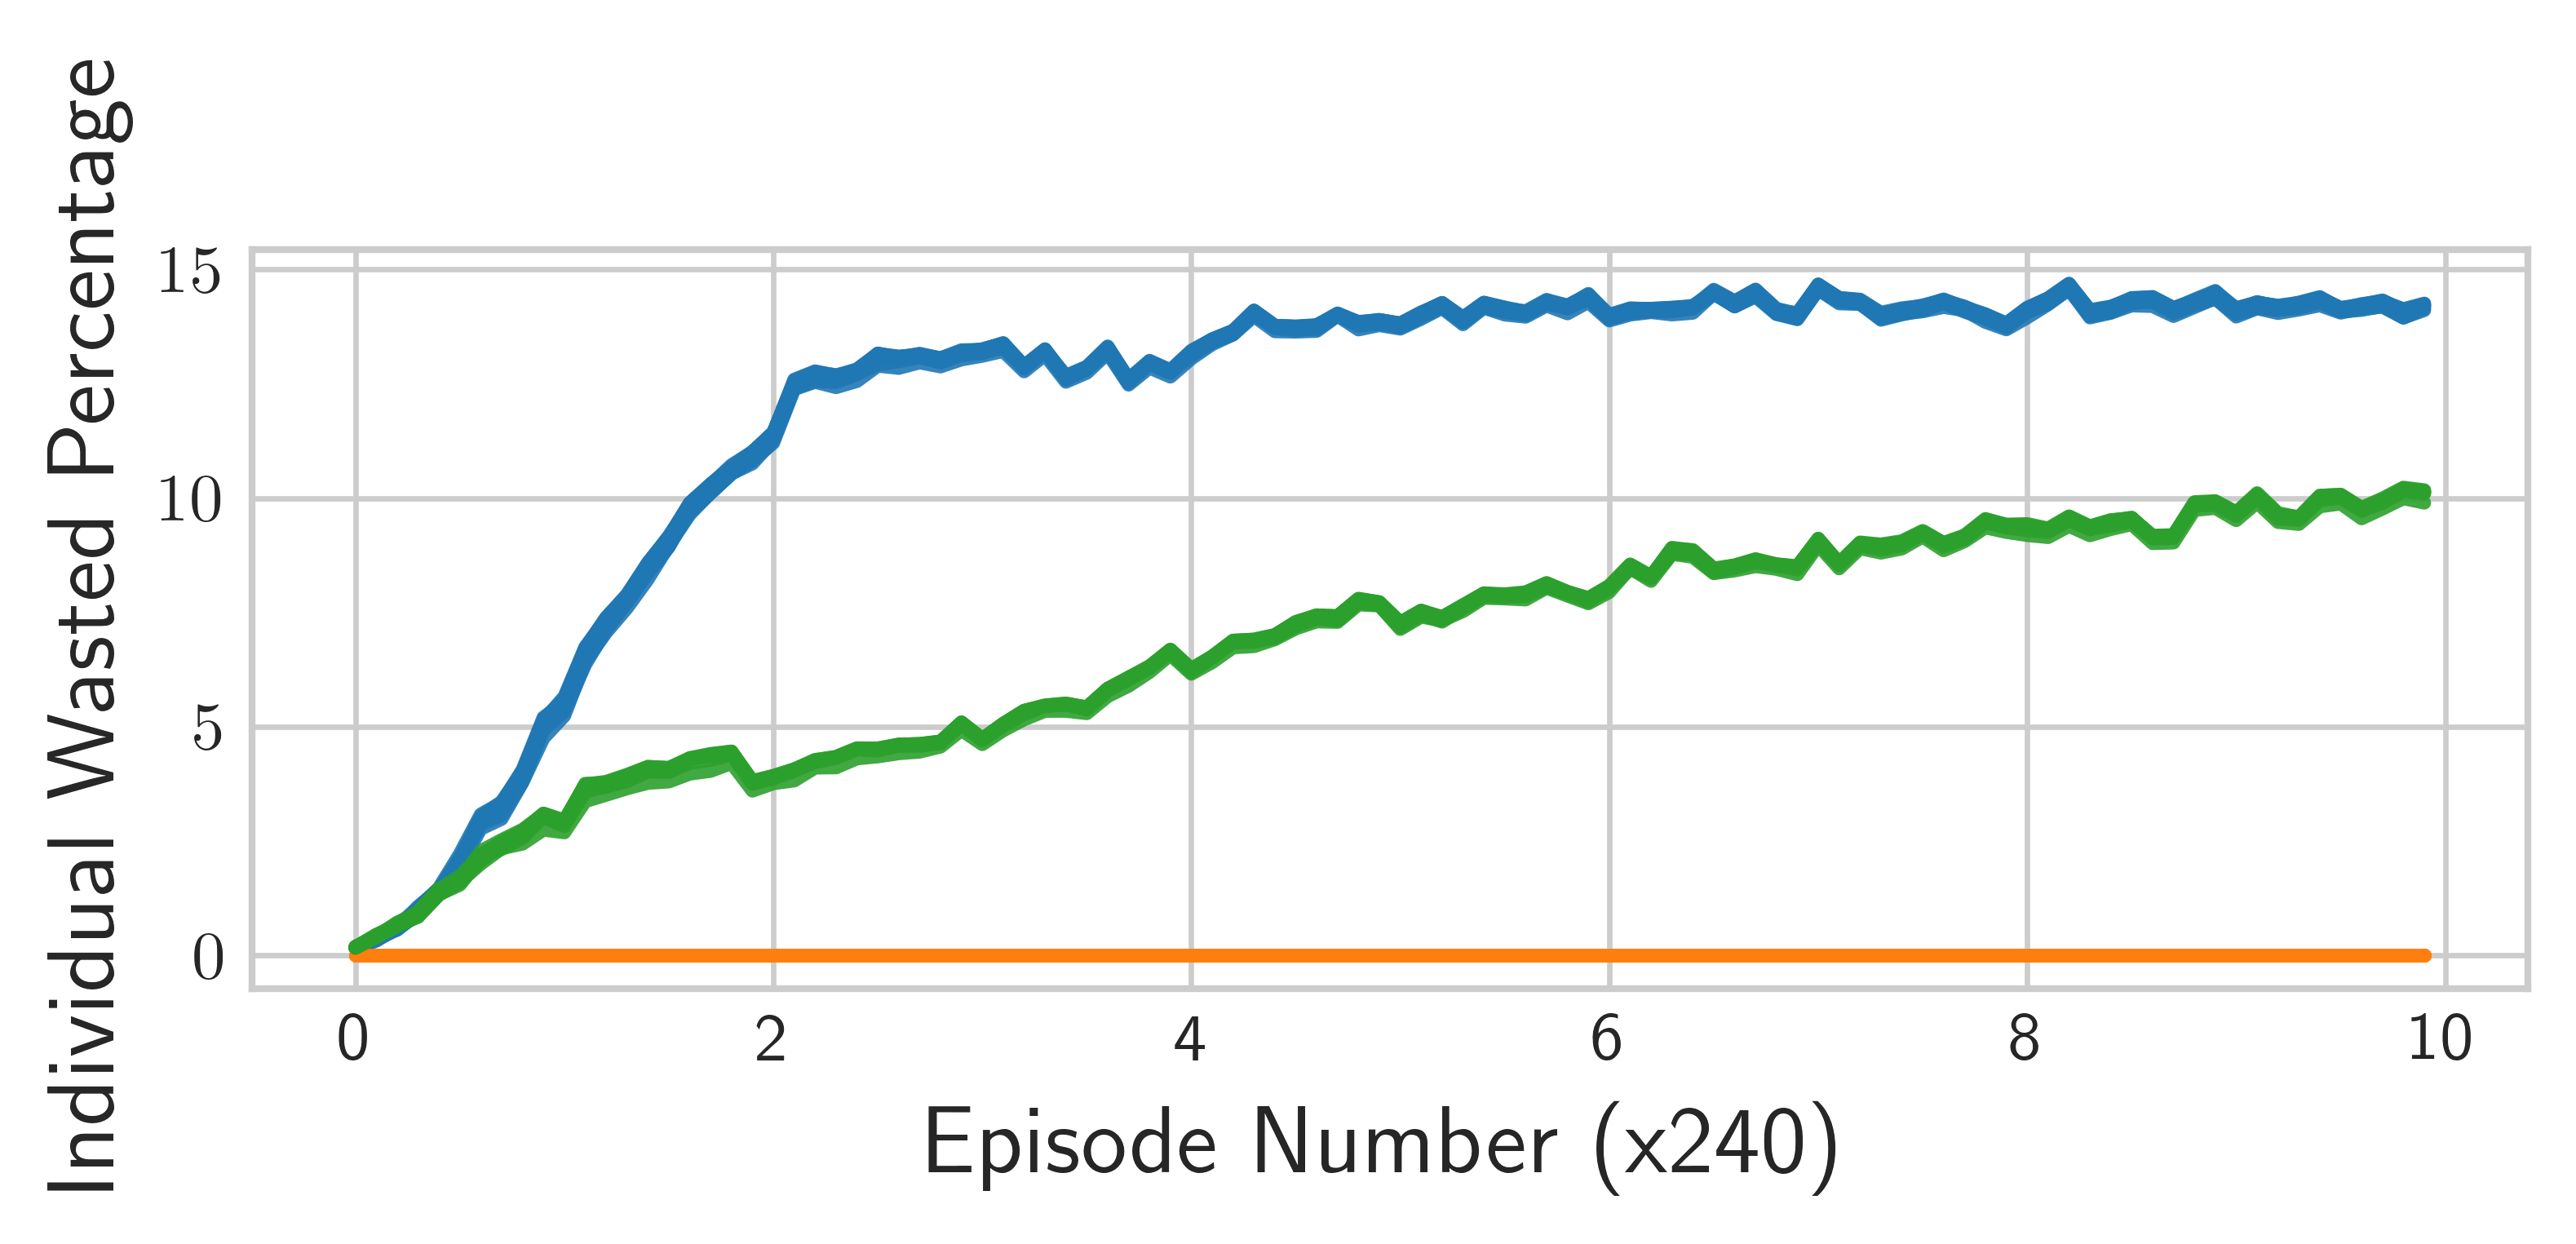

In [20]:
# Individual Wasted Percentage
y_axis_title = r'Individual Wasted Percentage'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['wasted_percentage'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['wasted_percentage'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)
# Policymaker
plt.plot(x_axis, results['logs_sustainability']['wasted_percentage'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)

plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
# legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
# axes.set_ylim([0,5])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

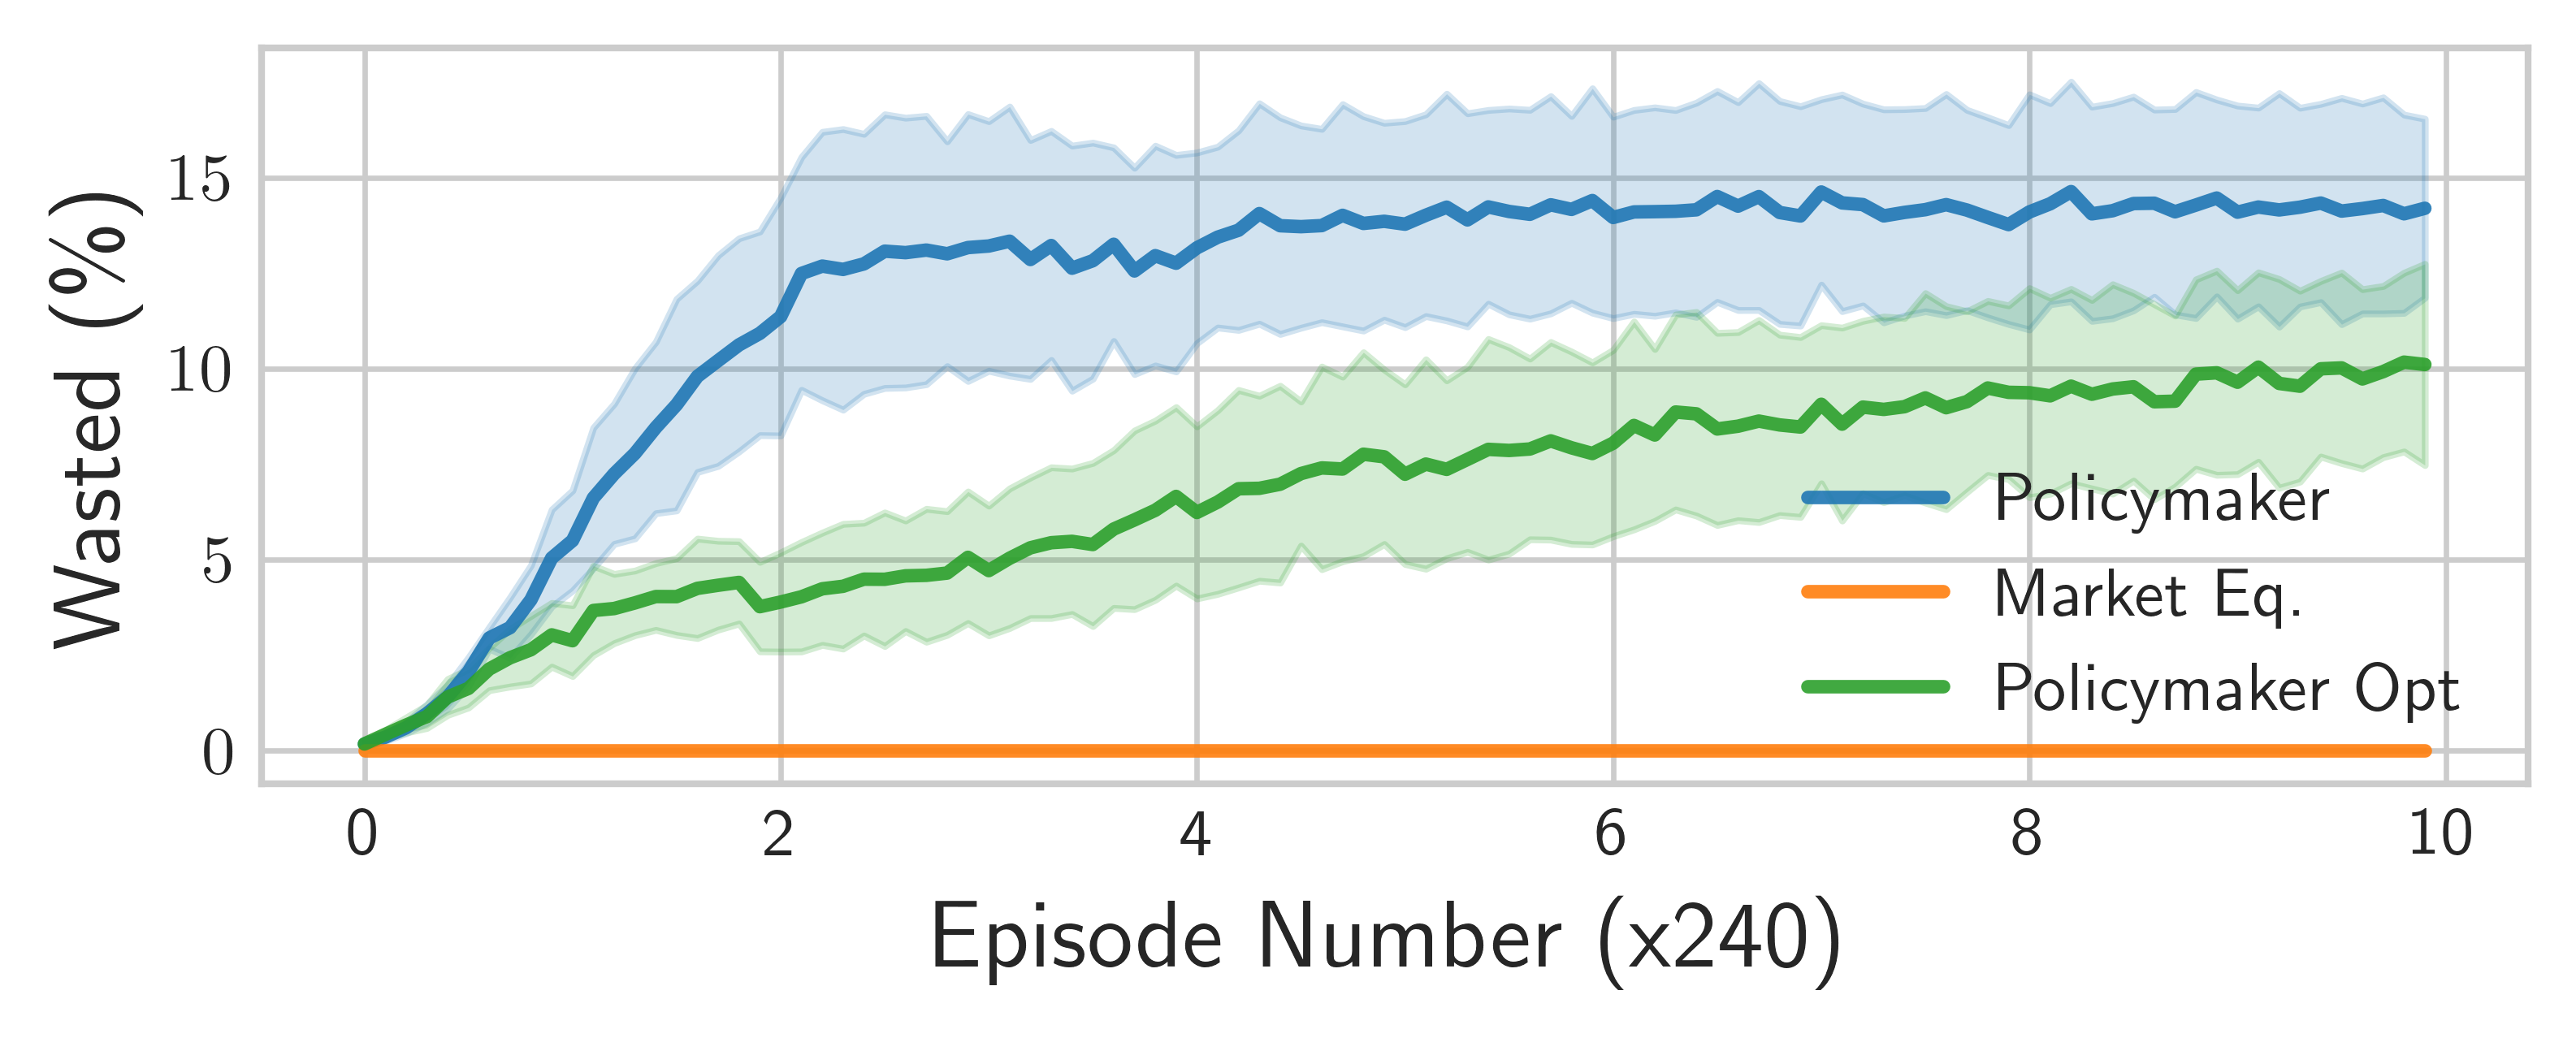

In [21]:
# Wasted Percentage Mean
y_axis_title = r'Wasted (\%)'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['wasted_percentage_mean'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker')
plt.fill_between(x_axis, np.array(results['logs']['wasted_percentage_mean']) - np.array(results['logs']['wasted_percentage_mean_sd']), np.array(results['logs']['wasted_percentage_mean']) + np.array(results['logs']['wasted_percentage_mean_sd']), color=palette(0), alpha=0.2)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['wasted_percentage_mean'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Market Eq.')
plt.fill_between(x_axis, np.array(results['logs_true']['wasted_percentage_mean']) - np.array(results['logs_true']['wasted_percentage_mean_sd']), np.array(results['logs_true']['wasted_percentage_mean']) + np.array(results['logs_true']['wasted_percentage_mean_sd']), color=palette(1), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_sustainability']['wasted_percentage_mean'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker' + optimised)
plt.fill_between(x_axis, np.array(results['logs_sustainability']['wasted_percentage_mean']) - np.array(results['logs_sustainability']['wasted_percentage_mean_sd']), np.array(results['logs_sustainability']['wasted_percentage_mean']) + np.array(results['logs_sustainability']['wasted_percentage_mean_sd']), color=palette(2), alpha=0.2)

plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
# axes.set_ylim([0,5])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

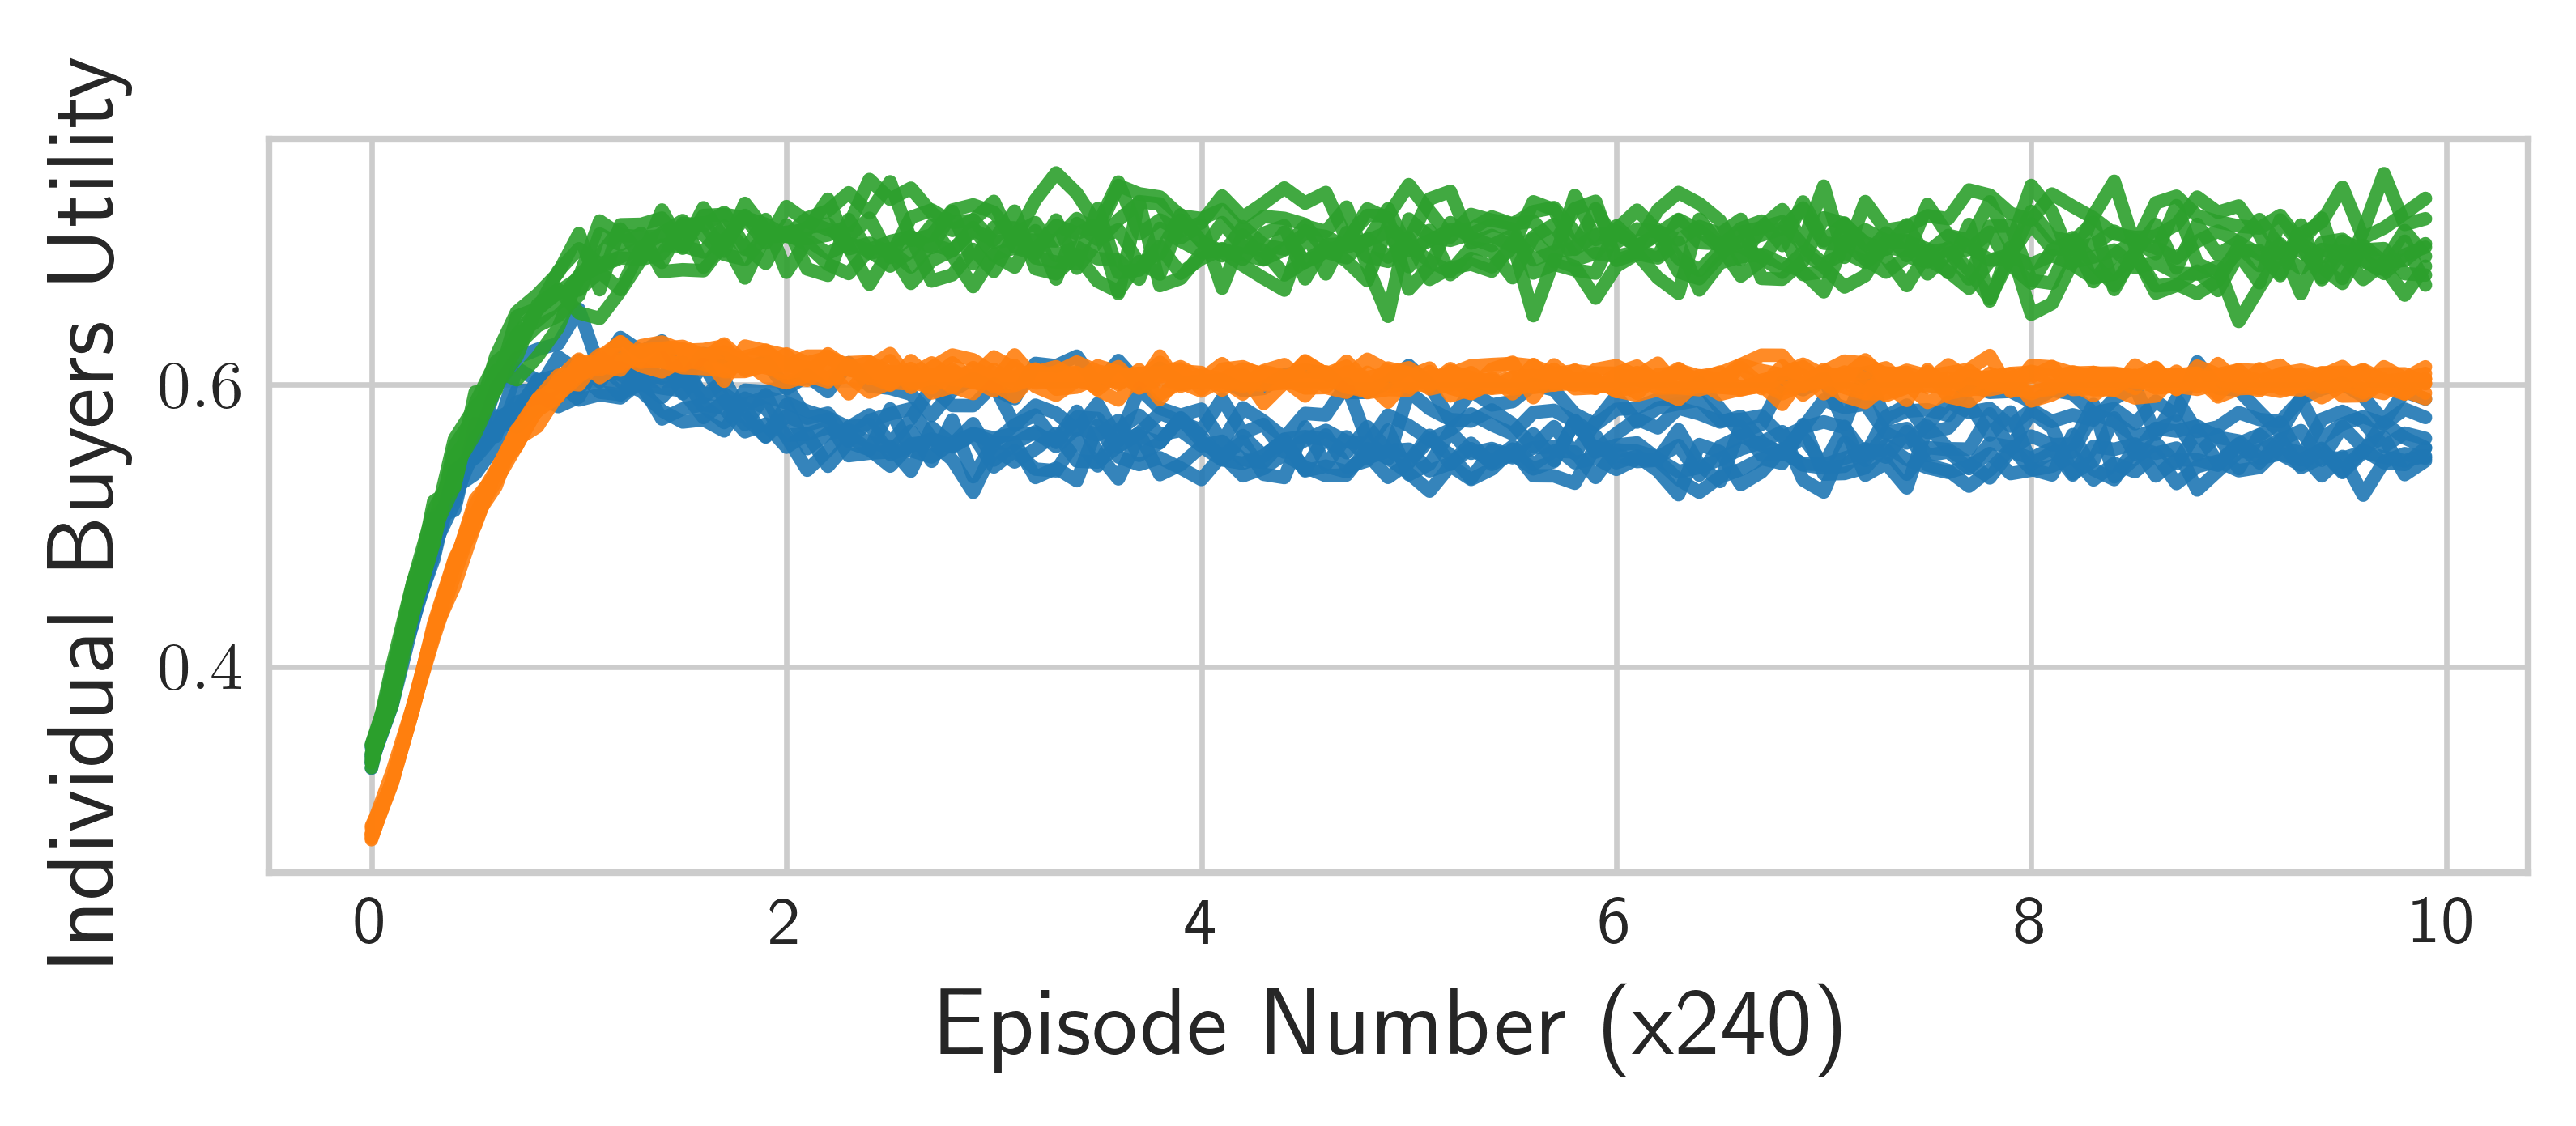

In [22]:
# Individual Buyers Utility
y_axis_title = r'Individual Buyers Utility'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['buyers_utility'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['buyers_utility'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)
# Policymaker
plt.plot(x_axis, results['logs_buyers']['buyers_utility'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)

plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
# legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
# axes.set_ylim([0,5])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

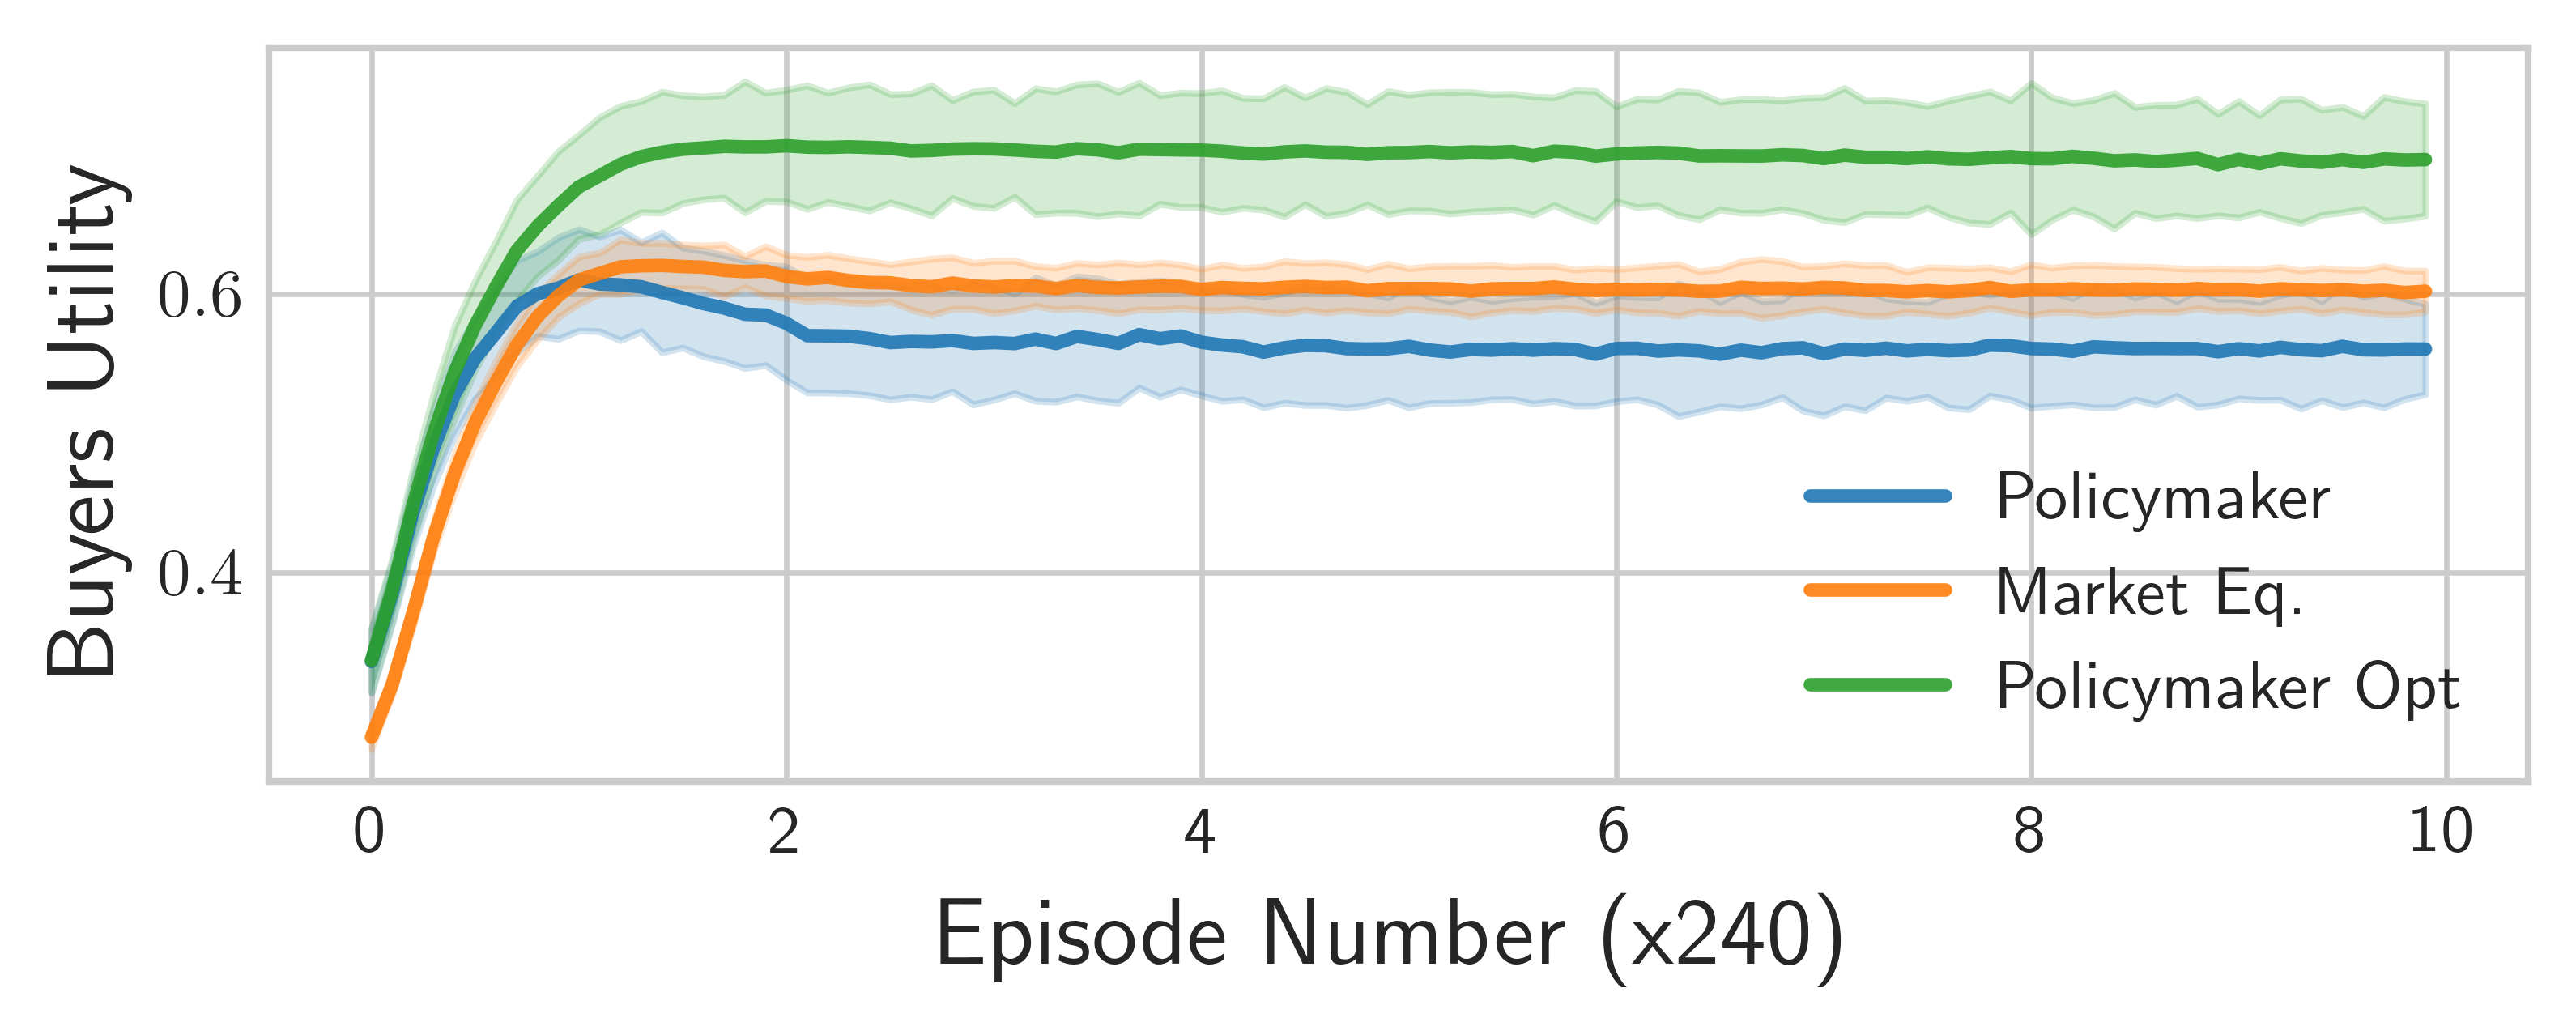

In [23]:
# Buyers Utility Mean
y_axis_title = r'Buyers Utility'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['buyers_utility_mean'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker')
plt.fill_between(x_axis, np.array(results['logs']['buyers_utility_mean']) - np.array(results['logs']['buyers_utility_mean_sd']), np.array(results['logs']['buyers_utility_mean']) + np.array(results['logs']['buyers_utility_mean_sd']), color=palette(0), alpha=0.2)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['buyers_utility_mean'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Market Eq.')
plt.fill_between(x_axis, np.array(results['logs_true']['buyers_utility_mean']) - np.array(results['logs_true']['buyers_utility_mean_sd']), np.array(results['logs_true']['buyers_utility_mean']) + np.array(results['logs_true']['buyers_utility_mean_sd']), color=palette(1), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_buyers']['buyers_utility_mean'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker' + optimised)
plt.fill_between(x_axis, np.array(results['logs_buyers']['buyers_utility_mean']) - np.array(results['logs_buyers']['buyers_utility_mean_sd']), np.array(results['logs_buyers']['buyers_utility_mean']) + np.array(results['logs_buyers']['buyers_utility_mean_sd']), color=palette(2), alpha=0.2)

plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
# axes.set_ylim([0,5])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

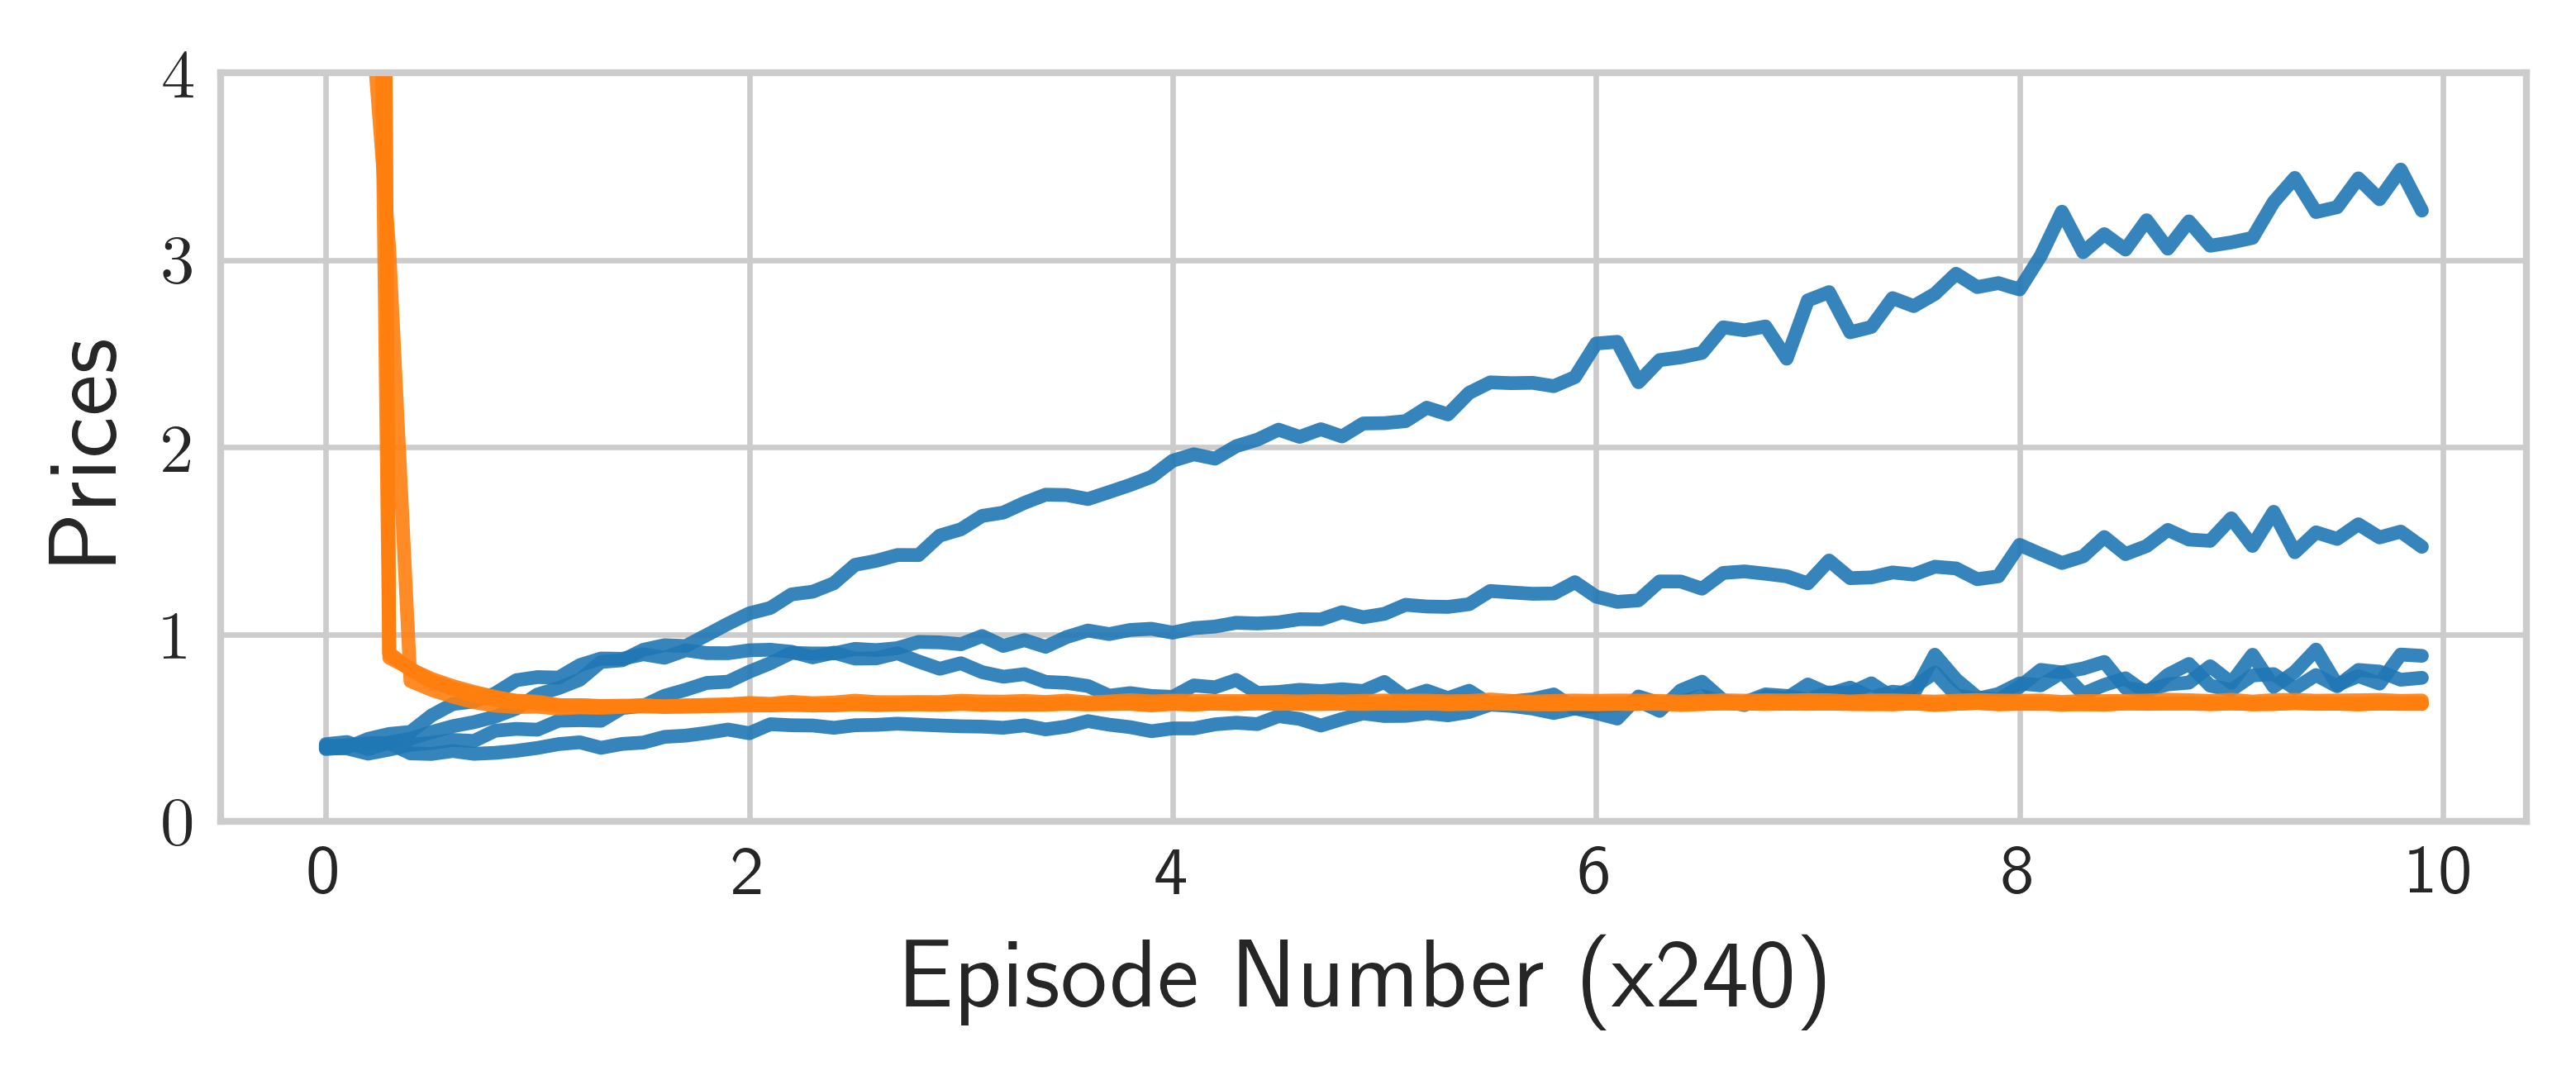

In [24]:
# Prices
y_axis_title = r'Prices'

figure = plt.figure(figsize=figure_size, dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['prices'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['prices'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9)

plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
# legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
axes.set_ylim([0,4])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower()
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

In [25]:
directory_name = 'logs_true_Ms_0p45'
print('Parsing ' + directory_name)
directory = os.path.join(logs_path, directory_name)
l_list = [name for name in listdir(directory) if 'workerID' in name]
# print(l_list)
# print(len(l_list))

logs = []
for l in l_list:
    with gzip.open(os.path.join(directory, l), 'rb') as f:
        p = pickle.Unpickler(f)
        log = p.load()
        logs.append(log)

counter = 0
total = 0
min_length = 9999
ep_length = []
for log in logs:
    for episode in log['episodes']:
#         print(episode['ep_len'])
        ep_length.append(episode['ep_len'])
        total = total + 1
        if episode['ep_len'] < 1000:
            counter = counter + 1
        if episode['ep_len'] < min_length:
            min_length = episode['ep_len']

ep_length = np.array(ep_length)
print('Mean = ' + str(np.mean(ep_length)))
print('Failed in ' + str(counter) + '/' + str(total) + ' or ' + str(100 * counter / total) + '%')
print('Min episode length = ' + str(min_length))

Parsing logs_true_Ms_0p45
Mean = 953.8934324659232
Failed in 79/807 or 9.789343246592317%
Min episode length = 48


In [26]:
directory_name = 'logs_Ms_0p45'
print('Parsing ' + directory_name)
directory = os.path.join(logs_path, directory_name)
l_list = [name for name in listdir(directory) if 'workerID' in name]
# print(l_list)
# print(len(l_list))

logs = []
for l in l_list:
    with gzip.open(os.path.join(directory, l), 'rb') as f:
        p = pickle.Unpickler(f)
        log = p.load()
        logs.append(log)

counter = 0
total = 0
min_length = 9999
ep_length = []
for log in logs:
    for episode in log['episodes']:
#         print(episode['ep_len'])
        ep_length.append(episode['ep_len'])
        total = total + 1
        if episode['ep_len'] < 1000:
            counter = counter + 1
        if episode['ep_len'] < min_length:
            min_length = episode['ep_len']

ep_length = np.array(ep_length)
print('Mean = ' + str(np.mean(ep_length)))
print('Failed in ' + str(counter) + '/' + str(total) + ' or ' + str(100 * counter / total) + '%')
print('Min episode length = ' + str(min_length))

Parsing logs_Ms_0p45
Mean = 980.2059553349876
Failed in 37/806 or 4.590570719602978%
Min episode length = 180


In [27]:
directory_name = 'logs_Ms_0p45_sustainability'
print('Parsing ' + directory_name)
directory = os.path.join(logs_path, directory_name)
l_list = [name for name in listdir(directory) if 'workerID' in name]
# print(l_list)
# print(len(l_list))

logs = []
for l in l_list:
    with gzip.open(os.path.join(directory, l), 'rb') as f:
        p = pickle.Unpickler(f)
        log = p.load()
        logs.append(log)

counter = 0
total = 0
min_length = 9999
ep_length = []
for log in logs:
    for episode in log['episodes']:
#         print(episode['ep_len'])
        ep_length.append(episode['ep_len'])
        total = total + 1
        if episode['ep_len'] < 1000:
            counter = counter + 1
        if episode['ep_len'] < min_length:
            min_length = episode['ep_len']

ep_length = np.array(ep_length)
print('Mean = ' + str(np.mean(ep_length)))
print('Failed in ' + str(counter) + '/' + str(total) + ' or ' + str(100 * counter / total) + '%')
print('Min episode length = ' + str(min_length))

Parsing logs_Ms_0p45_sustainability
Mean = 989.5815691158157
Failed in 18/803 or 2.2415940224159403%
Min episode length = 258


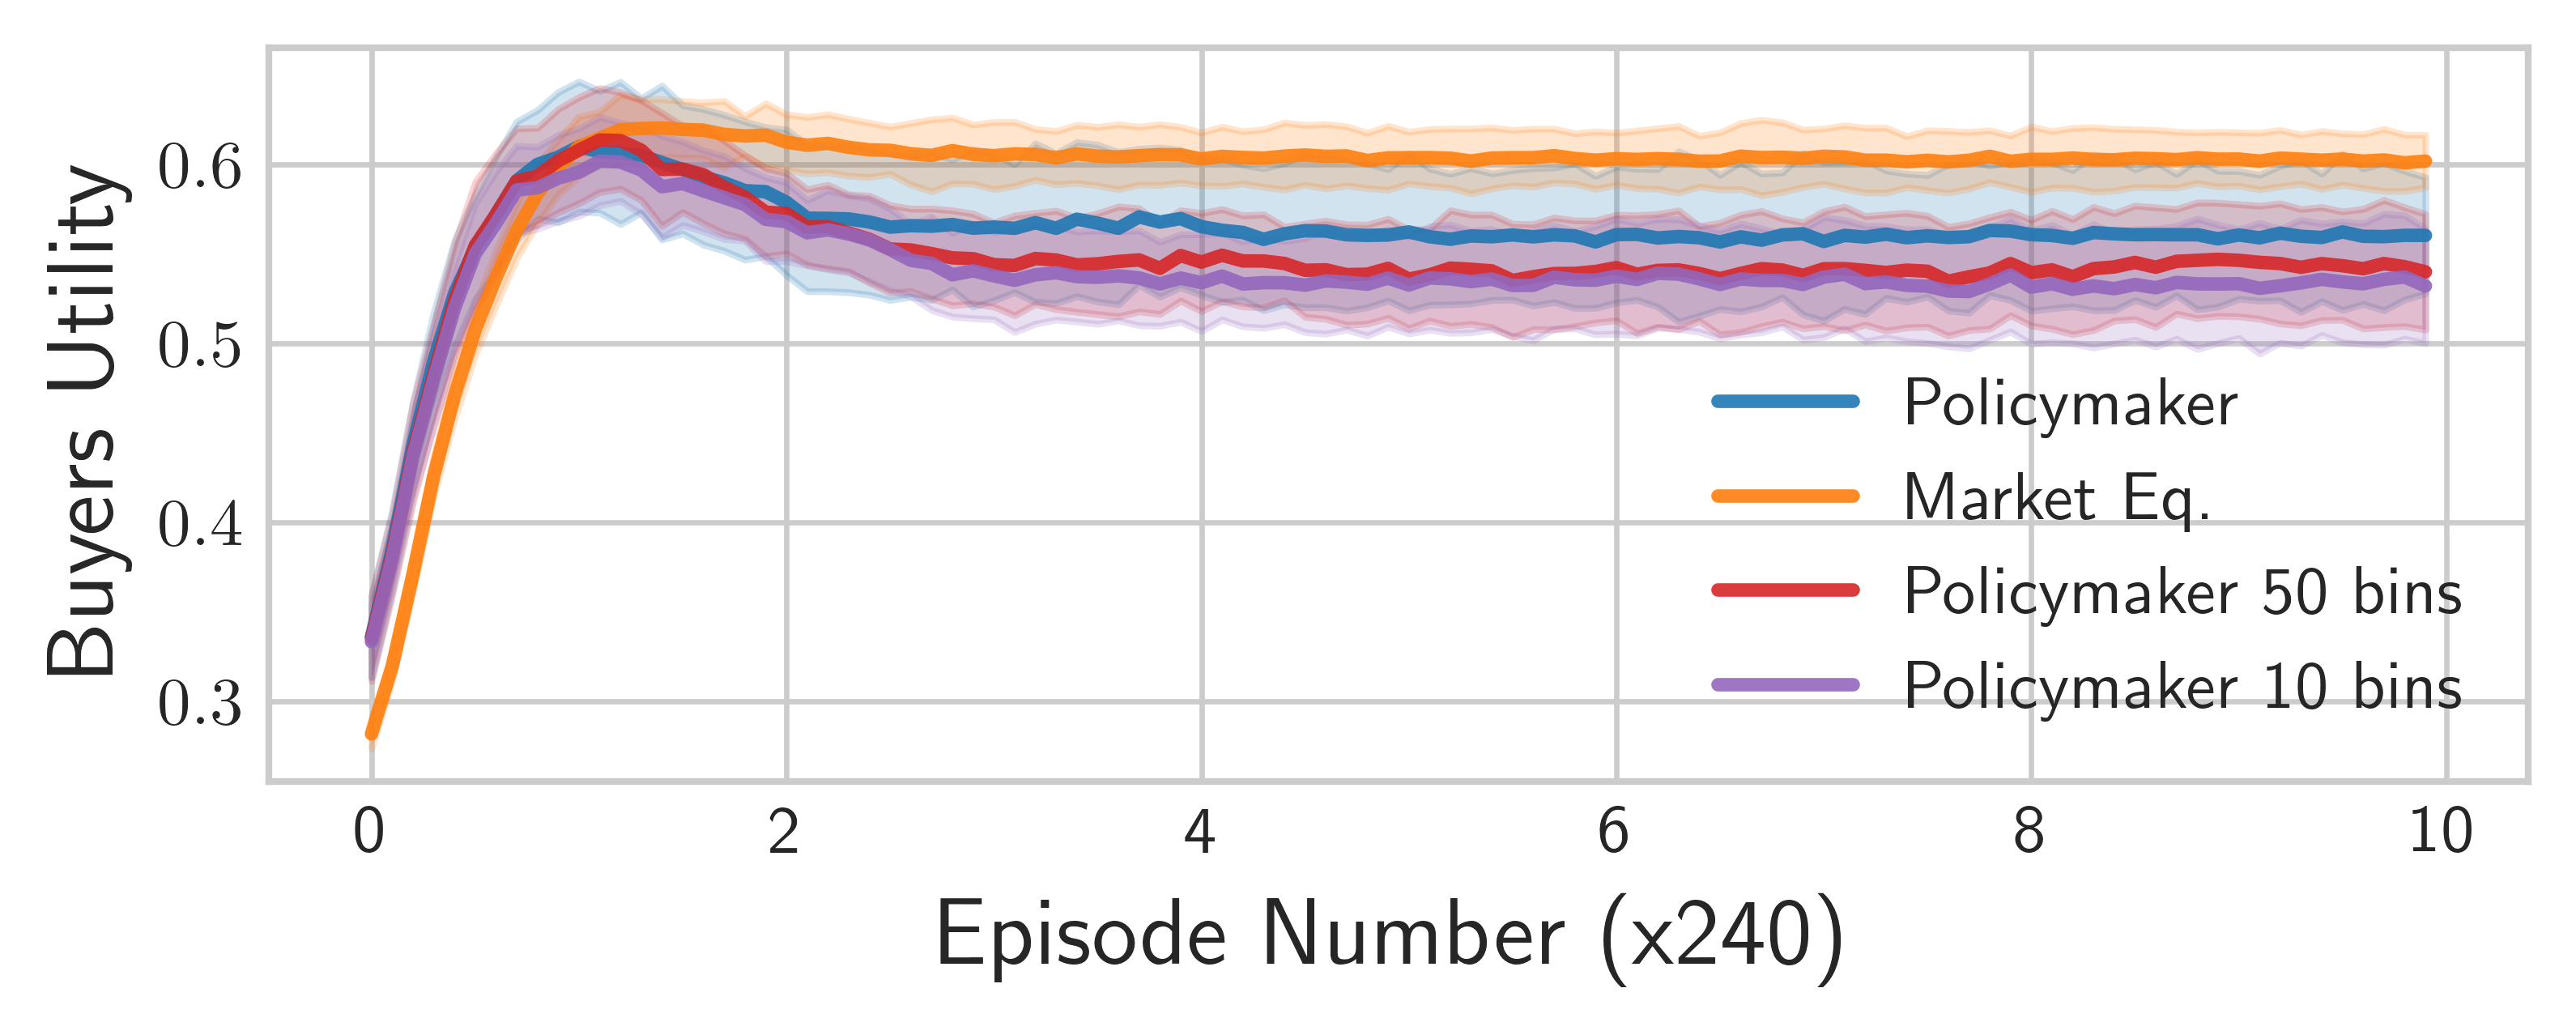

In [28]:
# Buyers Utility Noisy
y_axis_title = r'Buyers Utility'

figure = plt.figure(figsize=(6, 2), dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['buyers_utility_mean'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker')
plt.fill_between(x_axis, np.array(results['logs']['buyers_utility_mean']) - np.array(results['logs']['buyers_utility_mean_sd']), np.array(results['logs']['buyers_utility_mean']) + np.array(results['logs']['buyers_utility_mean_sd']), color=palette(0), alpha=0.2)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['buyers_utility_mean'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Market Eq.')
plt.fill_between(x_axis, np.array(results['logs_true']['buyers_utility_mean']) - np.array(results['logs_true']['buyers_utility_mean_sd']), np.array(results['logs_true']['buyers_utility_mean']) + np.array(results['logs_true']['buyers_utility_mean_sd']), color=palette(1), alpha=0.2)
# Policymaker
# plt.plot(x_axis, results['logs_buyers']['buyers_utility_mean'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker' + optimised)
# plt.fill_between(x_axis, np.array(results['logs_buyers']['buyers_utility_mean']) - np.array(results['logs_buyers']['buyers_utility_mean_sd']), np.array(results['logs_buyers']['buyers_utility_mean']) + np.array(results['logs_buyers']['buyers_utility_mean_sd']), color=palette(2), alpha=0.2)

# # Policymaker
# plt.plot(x_axis, results['logs_bins_100']['buyers_utility_mean'], color=palette(4), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'bins 100')
# plt.fill_between(x_axis, np.array(results['logs_bins_100']['buyers_utility_mean']) - np.array(results['logs_bins_100']['buyers_utility_mean_sd']), np.array(results['logs_bins_100']['buyers_utility_mean']) + np.array(results['logs_bins_100']['buyers_utility_mean_sd']), color=palette(4), alpha=0.2)
# # Policymaker
# plt.plot(x_axis, results['logs_bins_75']['buyers_utility_mean'], color=palette(5), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'bins 75')
# plt.fill_between(x_axis, np.array(results['logs_bins_75']['buyers_utility_mean']) - np.array(results['logs_bins_75']['buyers_utility_mean_sd']), np.array(results['logs_bins_75']['buyers_utility_mean']) + np.array(results['logs_bins_75']['buyers_utility_mean_sd']), color=palette(5), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_bins_50']['buyers_utility_mean'], color=palette(3), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker 50 bins')
plt.fill_between(x_axis, np.array(results['logs_bins_50']['buyers_utility_mean']) - np.array(results['logs_bins_50']['buyers_utility_mean_sd']), np.array(results['logs_bins_50']['buyers_utility_mean']) + np.array(results['logs_bins_50']['buyers_utility_mean_sd']), color=palette(3), alpha=0.2)
# # Policymaker
# plt.plot(x_axis, results['logs_bins_25']['buyers_utility_mean'], color=palette(7), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'bins 25')
# plt.fill_between(x_axis, np.array(results['logs_bins_25']['buyers_utility_mean']) - np.array(results['logs_bins_25']['buyers_utility_mean_sd']), np.array(results['logs_bins_25']['buyers_utility_mean']) + np.array(results['logs_bins_25']['buyers_utility_mean_sd']), color=palette(7), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_bins_10']['buyers_utility_mean'], color=palette(4), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker 10 bins')
plt.fill_between(x_axis, np.array(results['logs_bins_10']['buyers_utility_mean']) - np.array(results['logs_bins_10']['buyers_utility_mean_sd']), np.array(results['logs_bins_10']['buyers_utility_mean']) + np.array(results['logs_bins_10']['buyers_utility_mean_sd']), color=palette(4), alpha=0.2)



plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
# axes.set_ylim([0,5])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower() + '_noisy_valuations_bins'
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

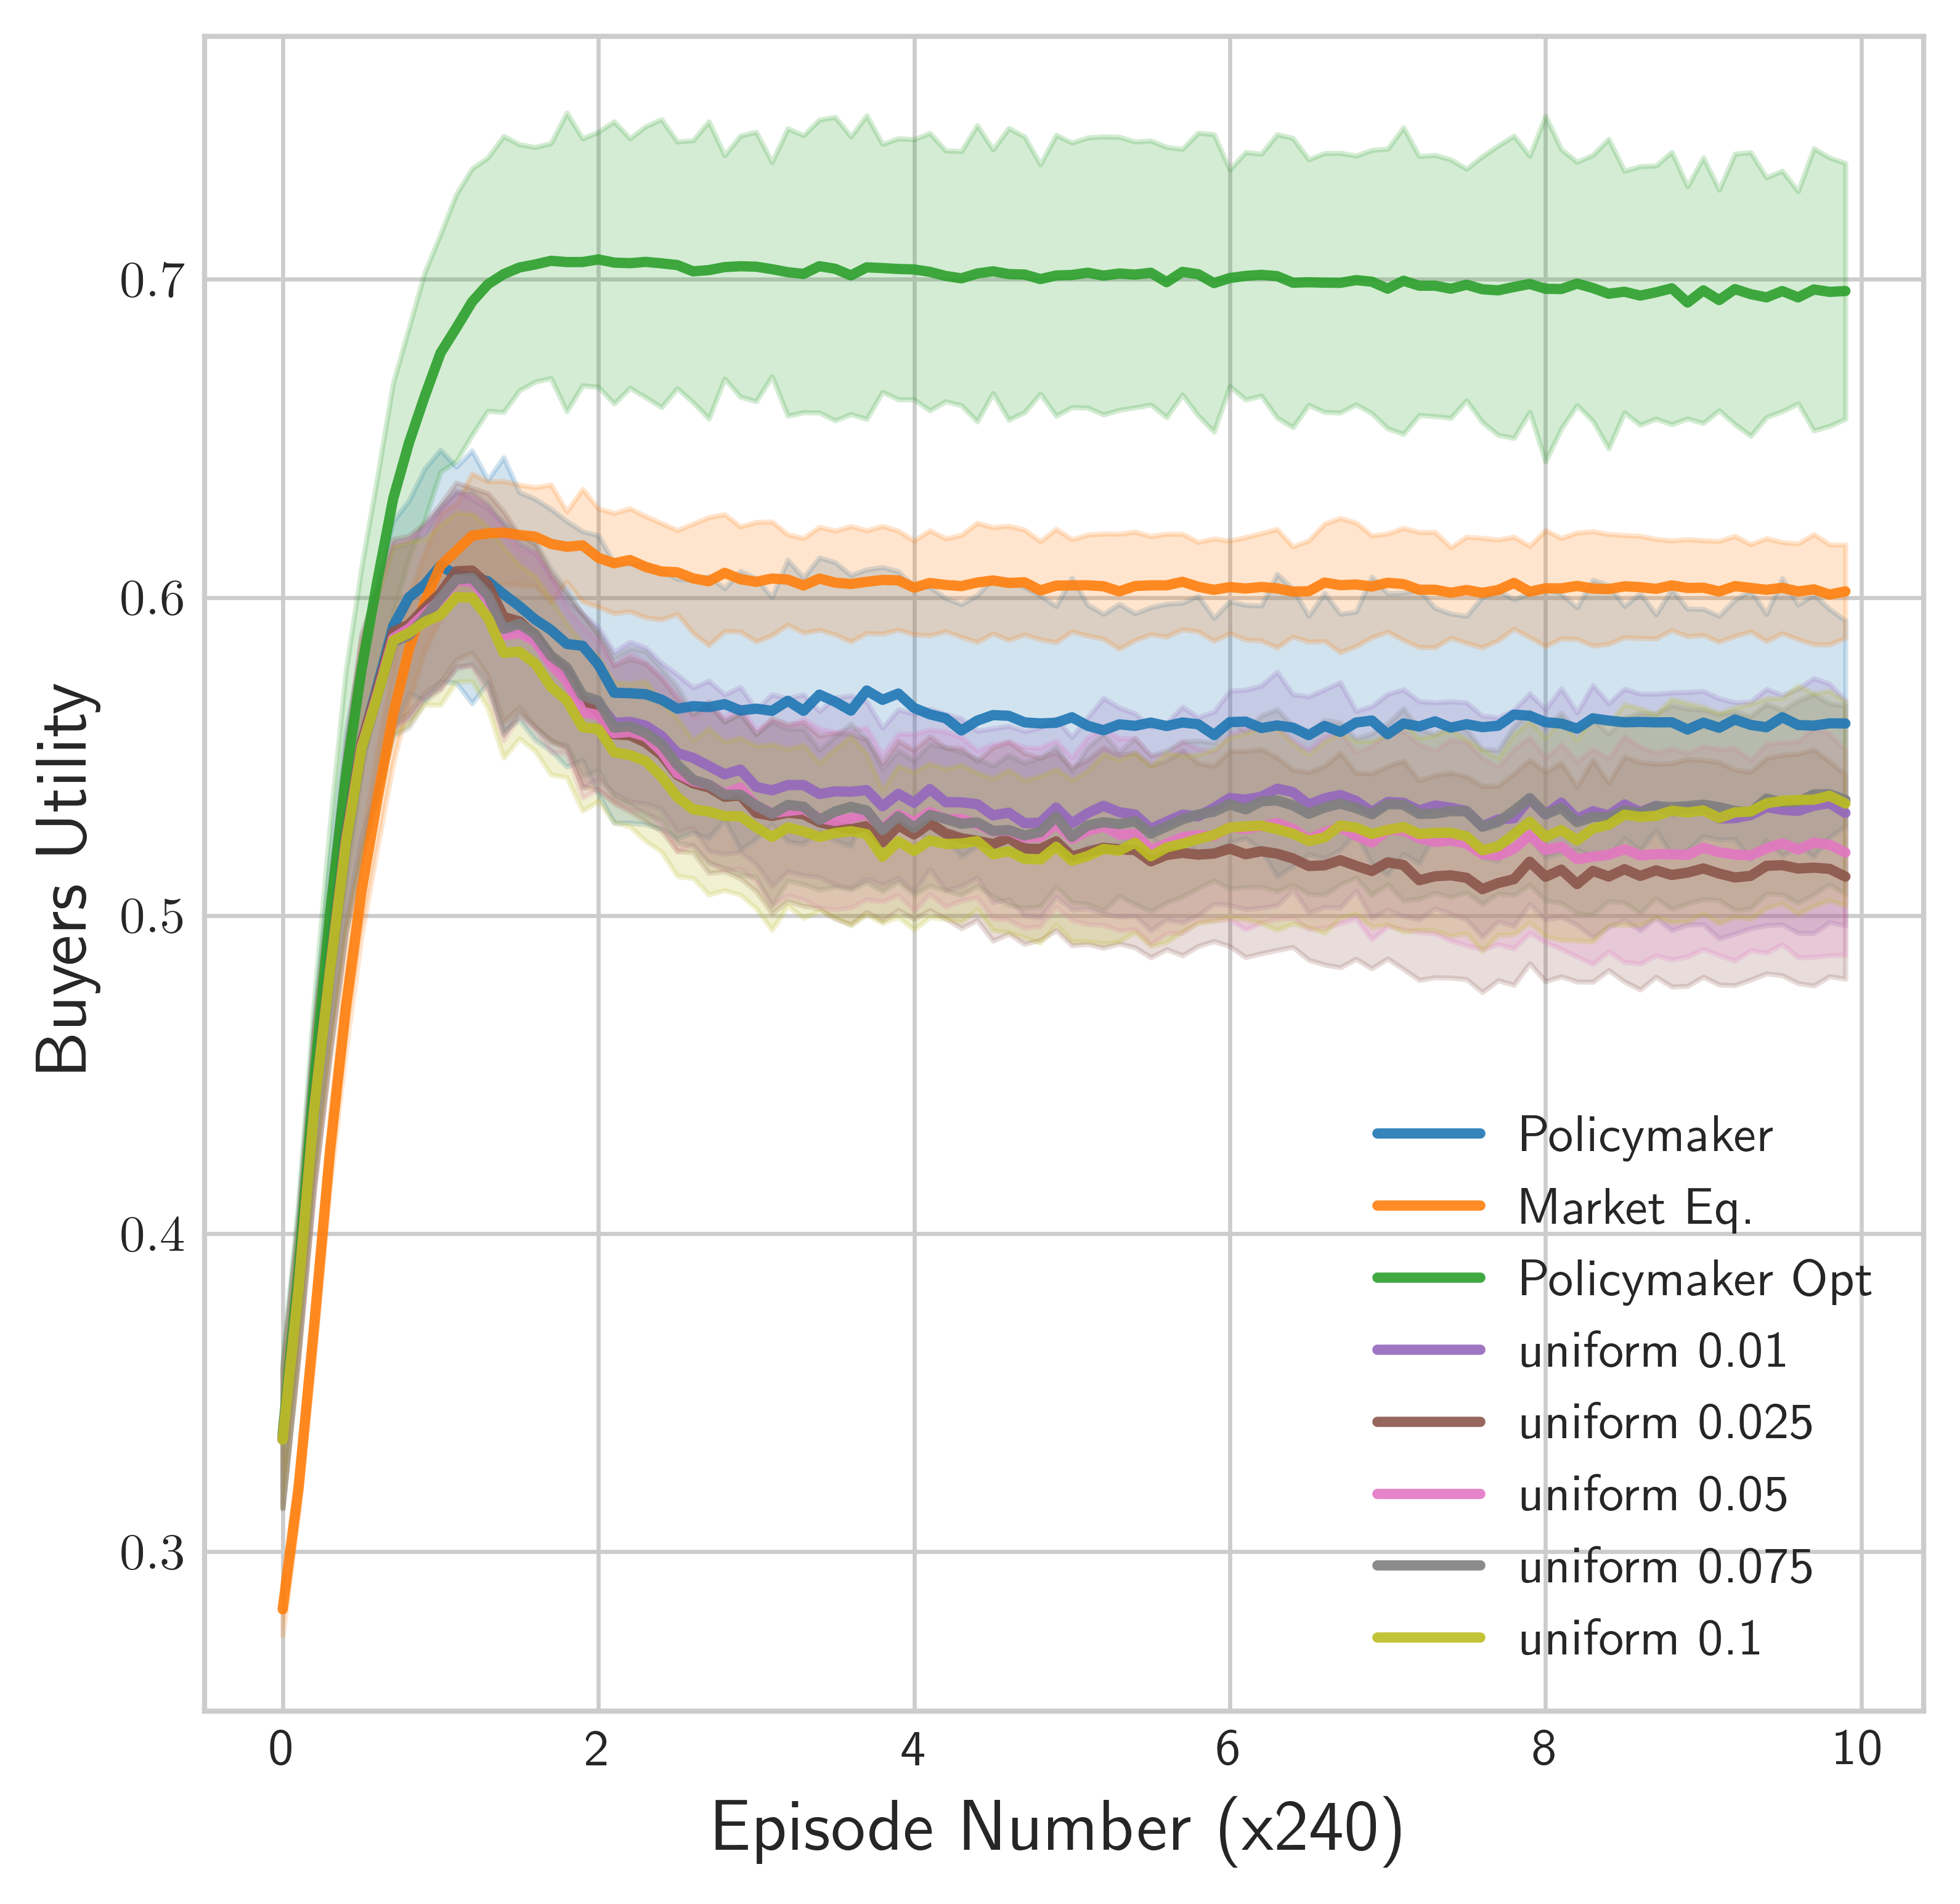

In [29]:
# Buyers Utility Noisy
y_axis_title = r'Buyers Utility'

figure = plt.figure(figsize=(6, 6), dpi=600)
plt.style.use('seaborn-whitegrid')
x_axis = range(results['logs']['num_episodes'])

# Policymaker
plt.plot(x_axis, results['logs']['buyers_utility_mean'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker')
plt.fill_between(x_axis, np.array(results['logs']['buyers_utility_mean']) - np.array(results['logs']['buyers_utility_mean_sd']), np.array(results['logs']['buyers_utility_mean']) + np.array(results['logs']['buyers_utility_mean_sd']), color=palette(0), alpha=0.2)
# Market Equilibrium
plt.plot(x_axis, results['logs_true']['buyers_utility_mean'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Market Eq.')
plt.fill_between(x_axis, np.array(results['logs_true']['buyers_utility_mean']) - np.array(results['logs_true']['buyers_utility_mean_sd']), np.array(results['logs_true']['buyers_utility_mean']) + np.array(results['logs_true']['buyers_utility_mean_sd']), color=palette(1), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_buyers']['buyers_utility_mean'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker' + optimised)
plt.fill_between(x_axis, np.array(results['logs_buyers']['buyers_utility_mean']) - np.array(results['logs_buyers']['buyers_utility_mean_sd']), np.array(results['logs_buyers']['buyers_utility_mean']) + np.array(results['logs_buyers']['buyers_utility_mean_sd']), color=palette(2), alpha=0.2)

# Policymaker
plt.plot(x_axis, results['logs_uniform_0p01']['buyers_utility_mean'], color=palette(4), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'uniform 0.01')
plt.fill_between(x_axis, np.array(results['logs_uniform_0p01']['buyers_utility_mean']) - np.array(results['logs_uniform_0p01']['buyers_utility_mean_sd']), np.array(results['logs_uniform_0p01']['buyers_utility_mean']) + np.array(results['logs_uniform_0p01']['buyers_utility_mean_sd']), color=palette(4), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_uniform_0p025']['buyers_utility_mean'], color=palette(5), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'uniform 0.025')
plt.fill_between(x_axis, np.array(results['logs_uniform_0p025']['buyers_utility_mean']) - np.array(results['logs_uniform_0p025']['buyers_utility_mean_sd']), np.array(results['logs_uniform_0p025']['buyers_utility_mean']) + np.array(results['logs_uniform_0p025']['buyers_utility_mean_sd']), color=palette(5), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_uniform_0p05']['buyers_utility_mean'], color=palette(6), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'uniform 0.05')
plt.fill_between(x_axis, np.array(results['logs_uniform_0p05']['buyers_utility_mean']) - np.array(results['logs_uniform_0p05']['buyers_utility_mean_sd']), np.array(results['logs_uniform_0p05']['buyers_utility_mean']) + np.array(results['logs_uniform_0p05']['buyers_utility_mean_sd']), color=palette(6), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_uniform_0p075']['buyers_utility_mean'], color=palette(7), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'uniform 0.075')
plt.fill_between(x_axis, np.array(results['logs_uniform_0p075']['buyers_utility_mean']) - np.array(results['logs_uniform_0p075']['buyers_utility_mean_sd']), np.array(results['logs_uniform_0p075']['buyers_utility_mean']) + np.array(results['logs_uniform_0p075']['buyers_utility_mean_sd']), color=palette(7), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_uniform_0p1']['buyers_utility_mean'], color=palette(8), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'uniform 0.1')
plt.fill_between(x_axis, np.array(results['logs_uniform_0p1']['buyers_utility_mean']) - np.array(results['logs_uniform_0p1']['buyers_utility_mean_sd']), np.array(results['logs_uniform_0p1']['buyers_utility_mean']) + np.array(results['logs_uniform_0p1']['buyers_utility_mean_sd']), color=palette(8), alpha=0.2)



plt.xticks([0, 20, 40, 60, 80, 100], np.array([0, 2, 4, 6, 8, 10]))# * 240)
plt.xlabel(r'Episode Number (x240)')
plt.ylabel(y_axis_title)
legend = plt.legend(loc='best')
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes = plt.gca()
# axes.set_ylim([0,5])
plt.show()

filename = y_axis_title.replace(' (', '').replace(')', '').replace('\\', '').replace('%', '').replace(' ', '_').lower() + '_noisy_valuations_uniform_noise'
if SAVE:
    figure.savefig(os.path.join(path, filename + ".png"), bbox_inches='tight')
    figure.savefig(os.path.join(path, filename + ".pdf"), bbox_inches='tight', format='pdf')

In [30]:
print(np.mean(results['logs_true']['numerical_social_welfare']))
print(np.mean(results['logs']['numerical_social_welfare']))
print(np.mean(results['logs_harvesters']['numerical_social_welfare']))
[stat, pval] = stats.ttest_ind(results['logs_true']['numerical_social_welfare'], results['logs']['numerical_social_welfare'])
print(pval)
[stat, pval] = stats.ttest_ind(results['logs_harvesters']['numerical_social_welfare'], results['logs']['numerical_social_welfare'])
print(pval)
print()

print(np.mean(results['logs_true']['numerical_fairness_jain']))
print(np.mean(results['logs']['numerical_fairness_jain']))
print(np.mean(results['logs_fairness']['numerical_fairness_jain']))
[stat, pval] = stats.ttest_ind(results['logs_true']['numerical_fairness_jain'], results['logs']['numerical_fairness_jain'])
print(pval)
[stat, pval] = stats.ttest_ind(results['logs_fairness']['numerical_fairness_jain'], results['logs']['numerical_fairness_jain'])
print(pval)
print()

print(np.mean(results['logs_true']['numerical_fairness_gini']))
print(np.mean(results['logs']['numerical_fairness_gini']))
print(np.mean(results['logs_gini_fairness']['numerical_fairness_gini']))
[stat, pval] = stats.ttest_ind(results['logs_true']['numerical_fairness_gini'], results['logs']['numerical_fairness_gini'])
print(pval)
[stat, pval] = stats.ttest_ind(results['logs_gini_fairness']['numerical_fairness_gini'], results['logs']['numerical_fairness_gini'])
print(pval)
print()

print(np.mean(results['logs_true']['numerical_fairness_atkinson']))
print(np.mean(results['logs']['numerical_fairness_atkinson']))
print(np.mean(results['logs_atkinson_fairness']['numerical_fairness_atkinson']))
[stat, pval] = stats.ttest_ind(results['logs_true']['numerical_fairness_atkinson'], results['logs']['numerical_fairness_atkinson'])
print(pval)
[stat, pval] = stats.ttest_ind(results['logs_atkinson_fairness']['numerical_fairness_atkinson'], results['logs']['numerical_fairness_atkinson'])
print(pval)
print()

69.21458460696503
64.06206362696089
68.00691632233907
1.2098170782617263e-08
4.155481457310262e-07

0.9953433453551442
0.9893096650244365
0.993914570552084
0.003706141832649051
0.021262974069396447

0.9716766299119224
0.9446203704079195
0.9589573353322174
0.0002872009658793494
0.031076308719236227

0.9974265710025638
0.9945554799950684
0.9965958821307561
0.004453425156719584
0.0467723298477746



In [47]:
# numerical_fairness_jain
# numerical_fairness_gini
# numerical_fairness_atkinson
# numerical_social_welfare
# numerical_fairness_revenue_jain
# numerical_fairness_revenue_gini
# numerical_fairness_revenue_atkinson
# numerical_social_welfare_revenue
# numerical_stock_difference
# numerical_wasted_percentage
# numerical_fairness_buyers_jain
# numerical_fairness_buyers_gini
# numerical_fairness_buyers_atkinson
# numerical_social_welfare_buyers

n_digits = 2
append_pval = False

numerical_results = []

for value in ['numerical_social_welfare', 'numerical_social_welfare_buyers', 'numerical_stock_difference', 'numerical_wasted_percentage', 'numerical_fairness_jain', 'numerical_fairness_gini', 'numerical_fairness_atkinson', 'numerical_fairness_buyers_jain', 'numerical_fairness_buyers_gini', 'numerical_fairness_buyers_atkinson']:
    row = []

    row.append(value)
    
    # Policymaker
    original_log = 'logs_true'
    final_log = 'logs'

    original = results[original_log][value]
    final = results[final_log][value]
    [stat, pval] = stats.ttest_ind(original, final)
    difference = 100 * (np.mean(final) - np.mean(original)) / np.mean(original)
    # difference = round(difference, n_digits)
    row.append(difference)
    if append_pval:
        row.append(pval)
        
    
#     row.append('') ################################################################

        
    # Policymaker - Harvester
    original_log = 'logs_true'
    final_log = 'logs_harvesters'

    original = results[original_log][value]
    final = results[final_log][value]
    difference = 100 * (np.mean(final) - np.mean(original)) / np.mean(original)

    original_log = 'logs'
    original = results[original_log][value]
    [stat, pval] = stats.ttest_ind(original, final)

    row.append(difference)
    if append_pval:
        row.append(pval)

        
    # Policymaker - Buyers
    original_log = 'logs_true'
    final_log = 'logs_buyers'

    original = results[original_log][value]
    final = results[final_log][value]
    difference = 100 * (np.mean(final) - np.mean(original)) / np.mean(original)

    original_log = 'logs'
    original = results[original_log][value]
    [stat, pval] = stats.ttest_ind(original, final)

    row.append(difference)
    if append_pval:
        row.append(pval)


    # Policymaker - Sustainability
    original_log = 'logs_true'
    final_log = 'logs_sustainability'

    original = results[original_log][value]
    final = results[final_log][value]
    difference = 100 * (np.mean(final) - np.mean(original)) / np.mean(original)

    original_log = 'logs'
    original = results[original_log][value]
    [stat, pval] = stats.ttest_ind(original, final)

    row.append(difference)
    if append_pval:
        row.append(pval) 


    # Policymaker - Fairness
    original_log = 'logs_true'
    final_log = 'logs_fairness'

    original = results[original_log][value]
    final = results[final_log][value]
    difference = 100 * (np.mean(final) - np.mean(original)) / np.mean(original)

    original_log = 'logs'
    original = results[original_log][value]
    [stat, pval] = stats.ttest_ind(original, final)

    row.append(difference)
    if append_pval:
        row.append(pval)   
    
#     row.append('') ################################################################
    
    # Policymaker - Noisy 50 bins
    original_log = 'logs_true'
    final_log = 'logs_bins_50'

    original = results[original_log][value]
    final = results[final_log][value]
    difference = 100 * (np.mean(final) - np.mean(original)) / np.mean(original)

    original_log = 'logs'
    original = results[original_log][value]
    [stat, pval] = stats.ttest_ind(original, final)

    row.append(difference)
    if append_pval:
        row.append(pval)   
    
    
    # Policymaker - Noisy 10 bins
    original_log = 'logs_true'
    final_log = 'logs_bins_10'

    original = results[original_log][value]
    final = results[final_log][value]
    difference = 100 * (np.mean(final) - np.mean(original)) / np.mean(original)

    original_log = 'logs'
    original = results[original_log][value]
    [stat, pval] = stats.ttest_ind(original, final)

    row.append(difference)
    if append_pval:
        row.append(pval)   
    
    
    numerical_results.append(row)
    
pprint(numerical_results)

pd.DataFrame(numerical_results).to_csv(os.path.join(path, "numerical_results.csv"))

[['numerical_social_welfare',
  -7.444270610396244,
  -1.7448176442634318,
  -72.90693329644355,
  -31.36545882094149,
  -34.13948189013284,
  -11.353455928018583,
  -9.711083615378037],
 ['numerical_social_welfare_buyers',
  -7.005198007624413,
  -24.70706799758868,
  15.42246867771794,
  1.234939100537404,
  2.8847546156481756,
  -9.734887799364444,
  -11.507646140047289],
 ['numerical_stock_difference',
  -15.30144612089468,
  -2.6350193569730926,
  -10.578413045855946,
  -21.826353818440733,
  -12.99034997850471,
  -23.39821294726475,
  -21.726186029619697],
 ['numerical_wasted_percentage',
  1.4683802305295396e+20,
  2.8675651493781914e+20,
  1.346108000691571e+19,
  1.003820510216944e+20,
  8.23955902673246e+19,
  1.8335513770008058e+20,
  1.8833532883040895e+20],
 ['numerical_fairness_jain',
  -0.6061908545291849,
  -0.053914646335790614,
  -0.6364009416735456,
  -0.7200699204075516,
  -0.1435459241002366,
  -1.1640139043098297,
  -1.0374552977248932],
 ['numerical_fairness_gini

In [51]:
for value in ['numerical_fairness_jain', 'numerical_fairness_gini', 'numerical_fairness_atkinson', 'numerical_fairness_buyers_jain', 'numerical_fairness_buyers_gini', 'numerical_fairness_buyers_atkinson']:
    original_log = 'logs_true'
    final_log = 'logs_bins_10'

    original = results[original_log][value]
    final = results[final_log][value]
    
    print(value)
    print(min(original))
    print(min(final))
    print()

numerical_fairness_jain
0.9947003170843457
0.984480329711822

numerical_fairness_gini
0.9648572066859844
0.930764879324981

numerical_fairness_atkinson
0.997134642971264
0.9923396212926757

numerical_fairness_buyers_jain
0.9999130071393235
0.9963846936597659

numerical_fairness_buyers_gini
0.9951319630678608
0.9662768544801349

numerical_fairness_buyers_atkinson
0.999956177312993
0.9981913518759681



In [ ]:
# Policymaker
plt.plot(x_axis, results['logs_Ms_0p45']['stock_difference'], color=palette(0), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker')
plt.fill_between(x_axis, np.array(results['logs_Ms_0p45']['stock_difference']) - np.array(results['logs_Ms_0p45']['stock_difference_sd']), np.array(results['logs_Ms_0p45']['stock_difference']) + np.array(results['logs_Ms_0p45']['stock_difference_sd']), color=palette(0), alpha=0.2)
# Market Equilibrium
plt.plot(x_axis, results['logs_true_Ms_0p45']['stock_difference'], color=palette(1), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Market Eq.')
plt.fill_between(x_axis, np.array(results['logs_true_Ms_0p45']['stock_difference']) - np.array(results['logs_true_Ms_0p45']['stock_difference_sd']), np.array(results['logs_true_Ms_0p45']['stock_difference']) + np.array(results['logs_true_Ms_0p45']['stock_difference_sd']), color=palette(1), alpha=0.2)
# Policymaker
plt.plot(x_axis, results['logs_Ms_0p45_sustainability']['stock_difference'], color=palette(2), marker=markers[0], linestyle=linestyles[0], linewidth=LINEWIDTH, alpha=0.9, label=r'Policymaker' + optimised)
plt.fill_between(x_axis, np.array(results['logs_Ms_0p45_sustainability']['stock_difference']) - np.array(results['logs_Ms_0p45_sustainability']['stock_difference_sd']), np.array(results['logs_Ms_0p45_sustainability']['stock_difference']) + np.array(results['logs_Ms_0p45_sustainability']['stock_difference_sd']), color=palette(2), alpha=0.2)


In [58]:
print(results['logs']['wasted_percentage'])

[[ 0.19371254  0.17985406  0.16987005  0.17130377  0.16372391  0.17511435
   0.17208803  0.15749347]
 [ 0.400111    0.34336405  0.34409231  0.39331095  0.33774148  0.32753413
   0.36534457  0.32053898]
 [ 0.56152487  0.65995448  0.61441     0.61136714  0.56877618  0.61658247
   0.56333069  0.60286539]
 [ 0.94552913  1.0415857   0.98563911  0.90441486  0.89696994  0.98711435
   0.92619558  1.07205425]
 [ 1.37218688  1.47927088  1.42667834  1.33049141  1.39832074  1.44234662
   1.37476073  1.45214755]
 [ 2.0010107   2.22352999  2.11960565  1.93389994  2.05637332  2.12295519
   2.01796107  2.08090503]
 [ 2.93945302  3.08598418  3.03721935  2.76877566  2.90307019  3.01931346
   2.86665913  2.98155107]
 [ 3.2502019   3.34045041  3.36423671  2.98592332  3.26159546  3.30631285
   3.06728901  3.19694389]
 [ 3.93552795  4.066136    4.01776973  3.78351546  4.04187693  3.98278872
   3.79489325  3.97273838]
 [ 4.95967529  5.20524021  5.13484646  4.74962483  5.13080509  5.17329374
   4.93106857  5.

In [59]:
print(results['logs_sustainability']['wasted_percentage'])

[[ 0.18663286  0.19310508  0.17665105  0.1664245   0.1751918   0.17656702
   0.18437696  0.16193083]
 [ 0.4495642   0.4197533   0.43631495  0.45423984  0.39841426  0.40039942
   0.45059628  0.39715834]
 [ 0.64929342  0.72182504  0.68057764  0.67723268  0.65392046  0.63862348
   0.63524954  0.70515563]
 [ 0.86704875  0.94083826  0.95723235  0.86819224  0.83992627  0.88404396
   0.86162553  0.91933327]
 [ 1.46228956  1.44816727  1.45534524  1.33528229  1.32444443  1.41911679
   1.34053436  1.45499509]
 [ 1.60886451  1.73763488  1.64760746  1.54364512  1.58626868  1.66279132
   1.60955209  1.65665392]
 [ 2.12055789  2.20275488  2.28461635  2.11694513  2.06425292  2.15855166
   2.00182575  2.15239508]
 [ 2.47535838  2.48749164  2.5275988   2.40563241  2.4123845   2.49230148
   2.34051255  2.32351864]
 [ 2.72019463  2.7109214   2.75256979  2.63946862  2.58739606  2.72626378
   2.44189539  2.56481422]
 [ 3.10500505  3.08239642  3.08402589  3.02511341  3.07692711  3.104241
   2.7468487   3.03